# Background

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

#### Goal(s):

Predict if the customer will subscribe (yes/no) to a term deposit (variable y)
Success Metric(s):
Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.
Bonus(es):
Determine which customers are more likely to be interested in investment products. What makes the customers buy? Tell us which feature we should be focusing more on.

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
import plotly.express as px
import plotly.graph_objs as go
from statsmodels.graphics.mosaicplot import mosaic
from itertools import product

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, roc_auc_score, roc_curve, auc, f1_score, recall_score, precision_score, accuracy_score


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Data

In [2]:
data = pd.read_csv("term-deposit-marketing-2020.csv")

In [3]:
data.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign   y  
0  unknown    5   may       261         1  no  
1  unknown    5   may       151         1  no  
2  unknown    5   may        76         1  no  
3  unknown    5   may        92         1  no  
4  unknown    5   may       198         1  no

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


##### Target Variable

y - has the client subscribed to a term deposit? (binary)

In [5]:
data.describe()

age        balance           day      duration      campaign
count  40000.000000   40000.000000  40000.000000  40000.000000  40000.000000
mean      40.544600    1274.277550     16.017225    254.824300      2.882175
std        9.641776    2903.769716      8.278127    259.366498      3.239051
min       19.000000   -8019.000000      1.000000      0.000000      1.000000
25%       33.000000      54.000000      8.000000    100.000000      1.000000
50%       39.000000     407.000000     17.000000    175.000000      2.000000
75%       48.000000    1319.000000     21.000000    313.000000      3.000000
max       95.000000  102127.000000     31.000000   4918.000000     63.000000

The months are easy to turn into numerical values, so let's go ahead and change the data types. 

In [6]:
data.month.unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr'], dtype=object)

In [7]:
months_dict = {'jan': 1, 'feb': 2, 'mar' : 3,
              'apr': 4, 'may': 5, 'jun': 6,
              'jul': 7, 'aug': 8, 'sep': 9, 
              'oct': 10, 'nov': 11, 'dec': 12}

In [8]:
data.replace({'month': months_dict}, inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  int64 
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(6), object(8)
memory usage: 4.3+ MB


In [10]:
data.describe()

age        balance           day         month      duration  \
count  40000.000000   40000.000000  40000.000000  40000.000000  40000.000000   
mean      40.544600    1274.277550     16.017225      6.009800    254.824300   
std        9.641776    2903.769716      8.278127      2.301095    259.366498   
min       19.000000   -8019.000000      1.000000      1.000000      0.000000   
25%       33.000000      54.000000      8.000000      5.000000    100.000000   
50%       39.000000     407.000000     17.000000      6.000000    175.000000   
75%       48.000000    1319.000000     21.000000      7.000000    313.000000   
max       95.000000  102127.000000     31.000000     12.000000   4918.000000   

           campaign  
count  40000.000000  
mean       2.882175  
std        3.239051  
min        1.000000  
25%        1.000000  
50%        2.000000  
75%        3.000000  
max       63.000000

#### Missing Data

In [11]:
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [12]:
data.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day  month  duration  campaign   y  
0  unknown    5      5       261         1  no  
1  unknown    5      5       151         1  no  
2  unknown    5      5        76         1  no  
3  unknown    5      5        92         1  no  
4  unknown    5      5       198         1  no

In [13]:
data = data.sample(frac=1)
data.head()

age         job  marital  education default  balance housing loan  \
20749   38  technician  married   tertiary      no      128      no   no   
22532   34  management   single  secondary      no        0      no   no   
16174   34  management   single   tertiary      no      184      no   no   
36796   31  technician   single  secondary      no        1     yes   no   
12882   47  technician   single  secondary      no     -239     yes  yes   

        contact  day  month  duration  campaign    y  
20749  cellular   13      8       183         5   no  
22532  cellular   22      8       132         4   no  
16174  cellular   22      7       203         4   no  
36796  cellular   12      5       223         1   no  
12882  cellular    7      7       973         3  yes

# EDA

### Distribution of Data

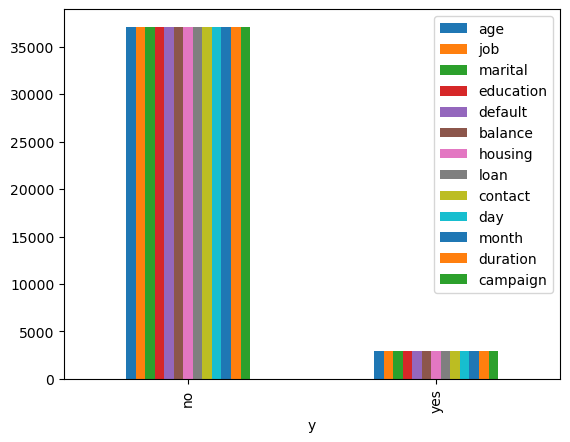

In [14]:
ax = data.groupby('y').count().plot(kind='bar')
plt.show();

We can see the dataset is clearly unbalanced. Let's have a look at the distribution of the two different classes. 

In [15]:
print('Percentage of clients not subscribed: ', (len(data[data['y'] == 'no'])/len(data)*100 ))
print('Percentage of clients subscribed: ', (len(data[data['y'] == 'yes'])/len(data)*100 ))

Percentage of clients not subscribed:  92.75999999999999
Percentage of clients subscribed:  7.24


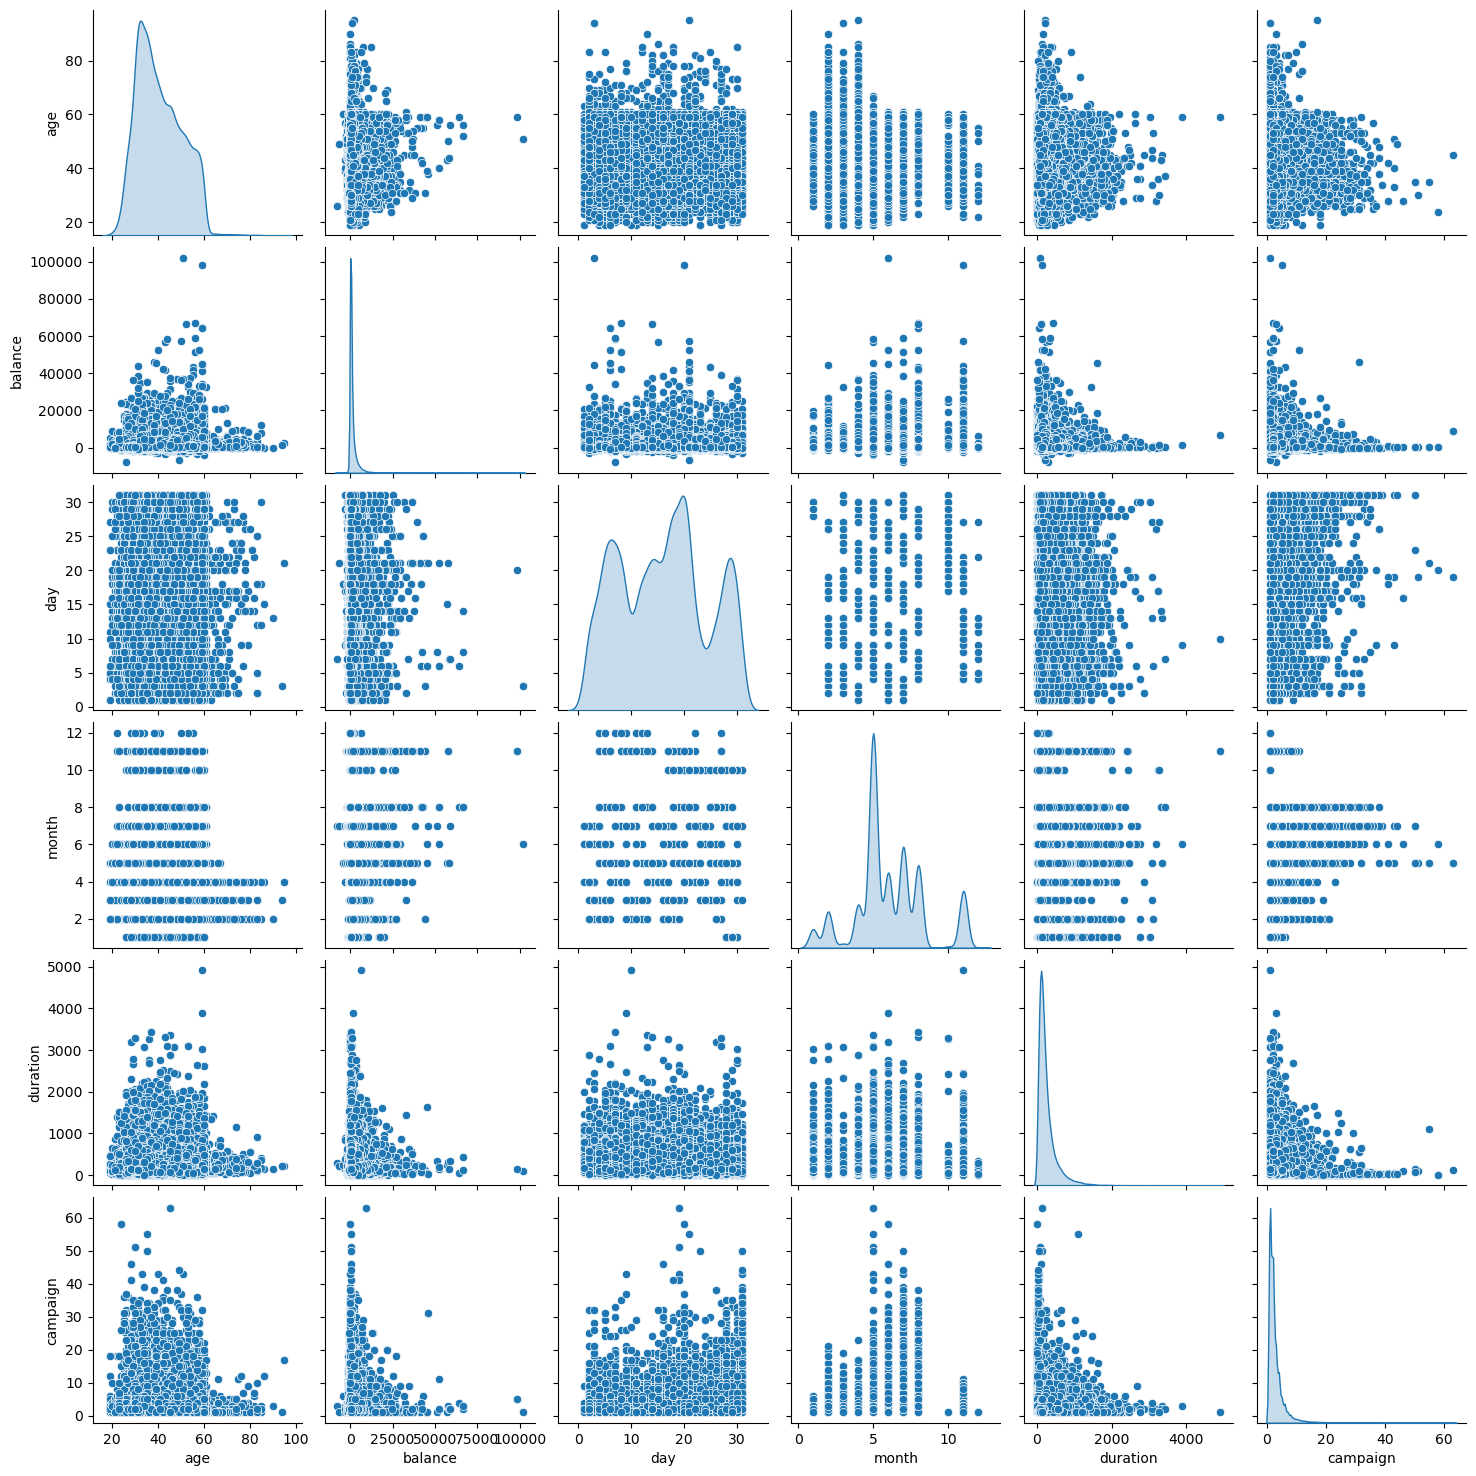

In [16]:
sns.pairplot(data, diag_kind = 'kde')
plt.show();

In [17]:
data.skew()

C:\Users\ibane\AppData\Local\Temp\ipykernel_1696\1188251951.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



age         0.436080
balance     8.259236
day         0.067930
month       0.335219
duration    3.165307
campaign    4.730901
dtype: float64

## Customer Profiling
Some of the features in the dataset can be used to categorise cusotmers: age, jobs, martial status, and education

### Age of customer

Type of Data: Numeric (integers)


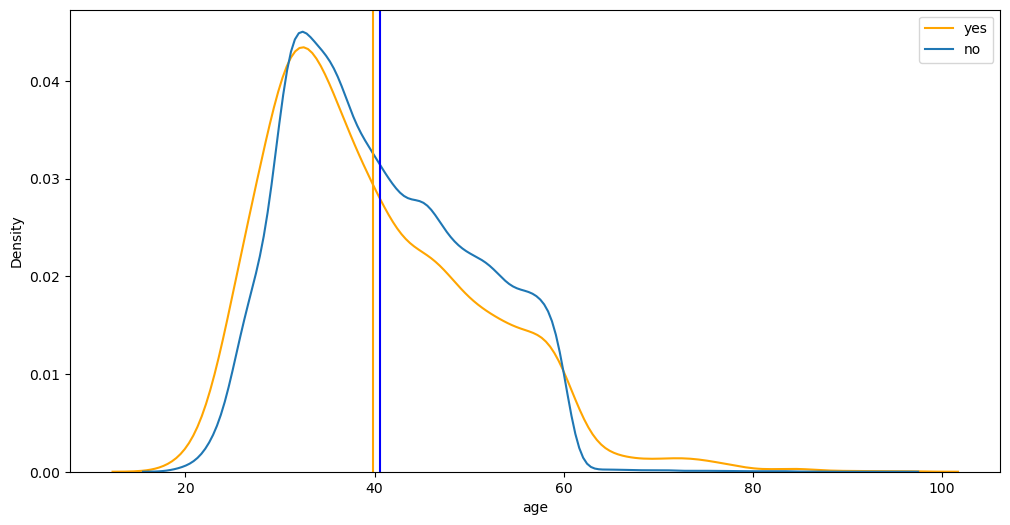

In [18]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.kdeplot(data[data['y']=='yes']['age'], color = 'orange', ax = ax, label = 'yes')
sns.kdeplot(data[data['y']=='no']['age'], ax = ax, label = 'no')
plt.axvline(np.mean((data[data['y']=='yes']['age'])), c = 'orange')
plt.axvline(np.mean((data[data['y']=='no']['age'])), c = 'blue')
ax.legend()
plt.show();

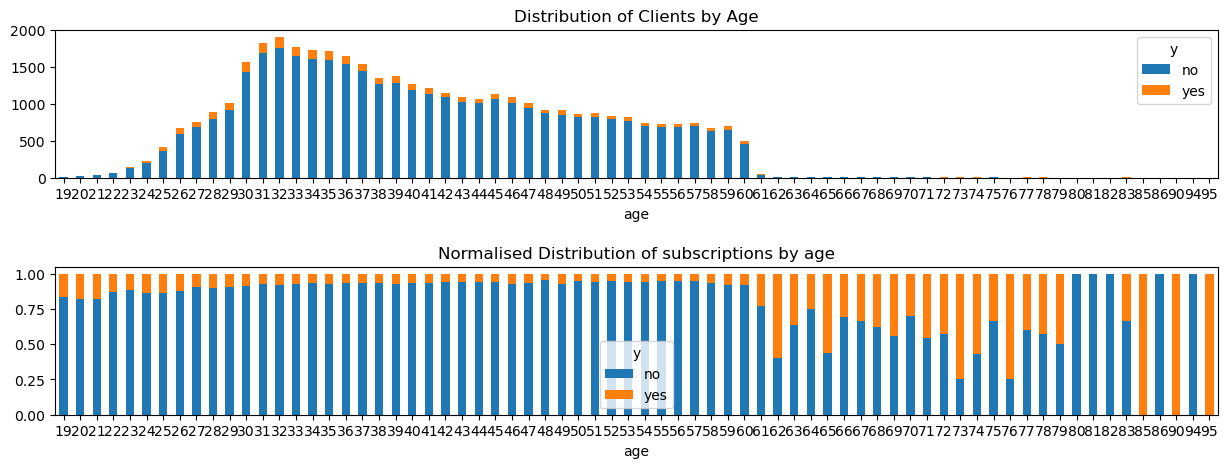

In [19]:
fig, axes = plt.subplots(nrows=2, ncols = 1, figsize = (15,5))
pd.crosstab(data['age'], data['y']).plot(kind='bar', stacked=True, rot=0, ax = axes[0], 
                                         title = 'Distribution of Clients by Age')
data.groupby('age')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 0,
                                                                             title = 'Normalised Distribution of subscriptions by age')
plt.subplots_adjust(wspace=0.6, hspace=0.6)
plt.show();

In [20]:
print('No. of clients aged 62: ', data[data['age']==62].size)
print('No of 62 year old clients who subscribed: ',data.query('age==62 & y == "yes"').size)
126/210*100

No. of clients aged 62:  210
No of 62 year old clients who subscribed:  126


60.0

In [21]:
print('No. of clients aged 65: ', data[data['age']==65].size)
print('No of 65 year old clients who subscribed: ',data.query('age==65 & y == "yes"').size)
126/224*100

No. of clients aged 65:  224
No of 65 year old clients who subscribed:  126


56.25

In [22]:
print('No. of clients aged 73: ', data[data['age']==73].size)
print('No of 73 year old clients who subscribed: ',data.query('age==73 & y == "yes"').size)
84/112*100

No. of clients aged 73:  112
No of 73 year old clients who subscribed:  84


75.0

In [23]:
print('No. of clients aged 85: ', data[data['age']==85].size)
print('No of 85 year old clients who subscribed: ',data.query('age==85 & y == "yes"').size)
42/42*100

No. of clients aged 85:  42
No of 85 year old clients who subscribed:  42


100.0

In [24]:
print('No. of clients aged 90: ', data[data['age']==90].size)
print('No of 90 year old clients who subscribed: ',data.query('age==90 & y == "yes"').size)
14/14*100

No. of clients aged 90:  14
No of 90 year old clients who subscribed:  14


100.0

In [25]:
print('No. of clients aged 95: ', data[data['age']==95].size)
print('No of 95 year old clients who subscribed: ',data.query('age==95 & y == "yes"').size)
95/95*100

No. of clients aged 95:  14
No of 95 year old clients who subscribed:  14


100.0

In [26]:
print('No. of clients aged 80: ', data[data['age']==80].size)
print('No of 80 year old clients who subscribed: ',data.query('age==80 & y == "yes"').size)

No. of clients aged 80:  28
No of 80 year old clients who subscribed:  0


In [27]:
print('No. of clients aged 81: ', data[data['age']==81].size)
print('No of 81 year old clients who subscribed: ',data.query('age==81 & y == "yes"').size)

No. of clients aged 81:  14
No of 81 year old clients who subscribed:  0


In [28]:
print('No. of clients aged 82: ', data[data['age']==82].size)
print('No of 82 year old clients who subscribed: ',data.query('age==82 & y == "yes"').size)

No. of clients aged 82:  42
No of 82 year old clients who subscribed:  0


In [29]:
print('No. of clients aged 86: ', data[data['age']==86].size)
print('No of 86 year old clients who subscribed: ',data.query('age==86 & y == "yes"').size)

No. of clients aged 86:  14
No of 86 year old clients who subscribed:  0


In [30]:
print('No. of clients aged 94: ', data[data['age']==94].size)
print('No of 94 year old clients who subscribed: ',data.query('age==94 & y == "yes"').size)

No. of clients aged 94:  14
No of 94 year old clients who subscribed:  0


There's some clear age groups where there is a higher percentage of clients who sign up for term deposits. It's worth noting that custimers aged 90 and 95 have exactly the same number of people, all of whom have subscribed for term deposits. This could possible be spurious or a mere coincidence. For now, there's not sufficient information to suggest these groups out outliers and so I'll leave them in the dataset. 

It's also interesting to note that the dataset has a higher proportion of clients aged between 26 to 60, but the percertage of clients who sign up for term deposits is higher for clients who are older. 

Age groups worth exploring further are 80-82 inclusive, 86 and 94 as these groups exclusively have customers who didn't subscribe for term deposits

In [31]:
print('Age of youngest customer: ', data['age'].min())
print('Age of oldest customer: ',data['age'].max())
print('\n')
print('Age by quartile: \n', data['age'].quantile([0.25, 0.5, 0.75]));

Age of youngest customer:  19
Age of oldest customer:  95


Age by quartile: 
 0.25    33.0
0.50    39.0
0.75    48.0
Name: age, dtype: float64


Age of youngest customer (Yes):  19
Age of oldest customer (Yes):  95


Age by quartile (yes): 
 0.25    31.0
0.50    37.0
0.75    47.0
Name: age, dtype: float64
Age of youngest customer (No):  19
Age of oldest customer (No):  94


Age by quartile:  0.25    33.0
0.50    39.0
0.75    48.0
Name: age, dtype: float64


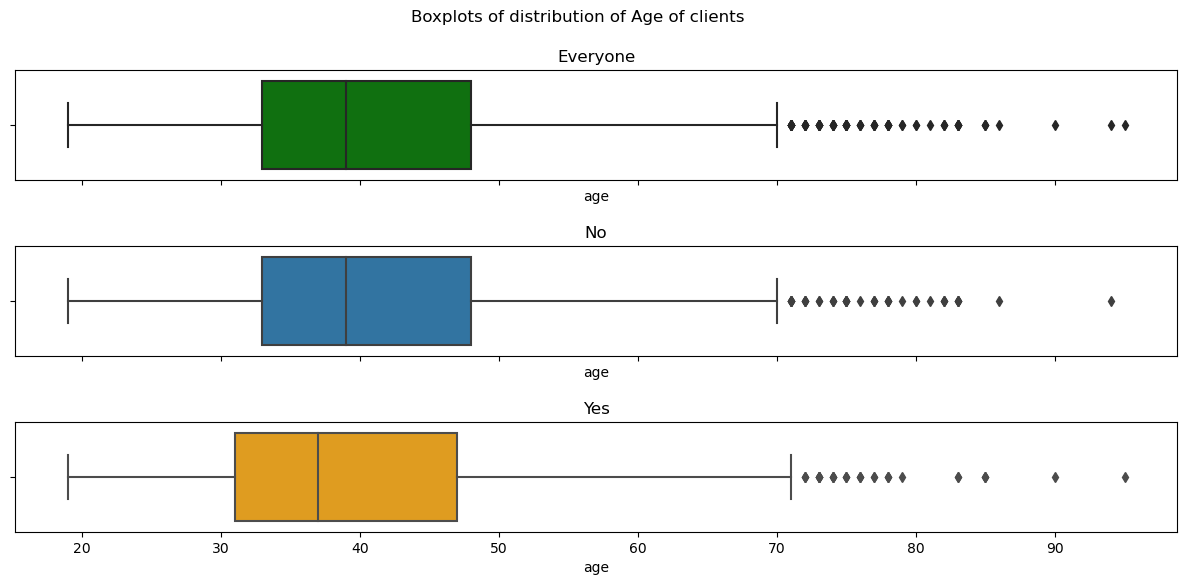

In [32]:
print('Age of youngest customer (Yes): ', data[data['y']=='yes']['age'].min())
print('Age of oldest customer (Yes): ',data[data['y']=='yes']['age'].max())
print('\n')
print('Age by quartile (yes): \n', data[data['y']=='yes']['age'].quantile([0.25, 0.5, 0.75]))
print('Age of youngest customer (No): ', data[data['y']=='no']['age'].min())
print('Age of oldest customer (No): ',data[data['y']=='no']['age'].max())
print('\n')
print('Age by quartile: ', data[data['y']=='no']['age'].quantile([0.25, 0.5, 0.75]))
fig, axes = plt.subplots(3, 1, sharex = True, figsize=(15,6))
fig.suptitle('Boxplots of distribution of Age of clients')
sns.boxplot(ax = axes[0],x='age', data = data, color= 'green')
axes[0].set_title('Everyone')
sns.boxplot(ax = axes[1],x='age', data = data[data['y']=='no'])
axes[1].set_title('No')
sns.boxplot(ax = axes[2], x='age', data = data[data['y']=='yes'], color = 'orange')
axes[2].set_title('Yes')
plt.subplots_adjust(wspace=0.6, hspace=0.6)
plt.show();

The distribution of the agegroups of clients in the whole dataset is roughly comparable between those clients who did and didn't subscribe of term deposits. The median is slightly lower for those who with term deposit subscriptions when comared to those clients who didn't register for subscriptions: 37 compared to 39. 

### Jobs

Type of Data: Categorical

In [33]:
data['job'].unique()

array(['technician', 'management', 'blue-collar', 'services', 'retired',
       'housemaid', 'admin', 'entrepreneur', 'unemployed',
       'self-employed', 'student', 'unknown'], dtype=object)

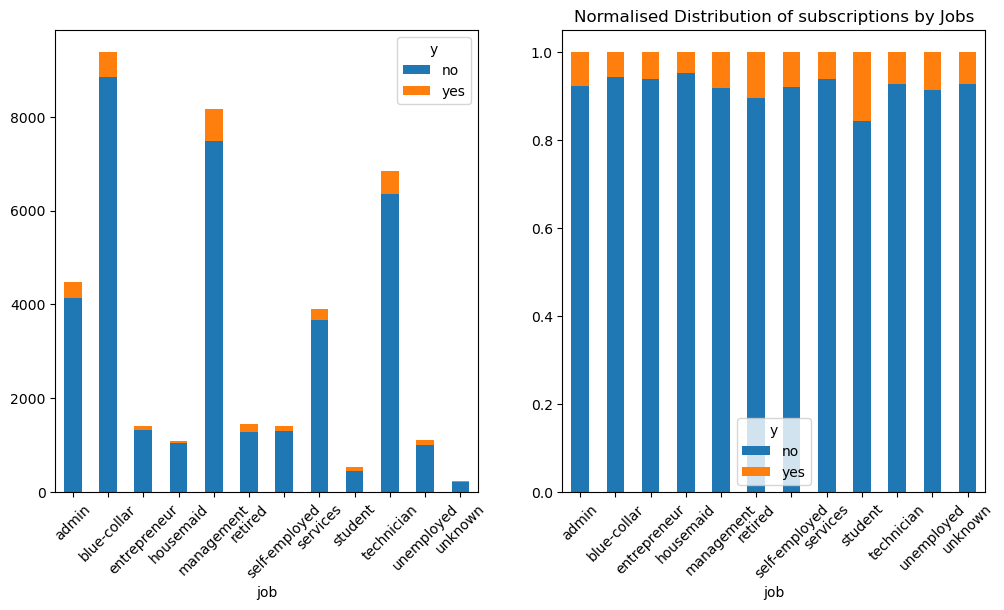

In [34]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (12,6))
pd.crosstab(data['job'], data['y']).plot(kind='bar', stacked=True, ax=axes[0], rot=45)
data.groupby('job')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 45,
                                                                             title = 'Normalised Distribution of subscriptions by Jobs')
plt.show();

Count of Clients by Jobs who subscribed for term deposits: 
 management       23.342541
blue-collar      18.473757
technician       17.161602
admin            12.120166
services          8.218232
retired           5.214088
self-employed     3.867403
unemployed        3.314917
entrepreneur      3.038674
student           2.831492
housemaid         1.830110
unknown           0.587017
Name: job, dtype: float64


Count of Clients by Jobs who didn't subscribe for term deposits: 
 blue-collar      23.846486
management       20.186503
technician       17.127533
admin            11.136266
services          9.896507
entrepreneur      3.549483
self-employed     3.509056
retired           3.465934
housemaid         2.786762
unemployed        2.716688
student           1.191246
unknown           0.587538
Name: job, dtype: float64


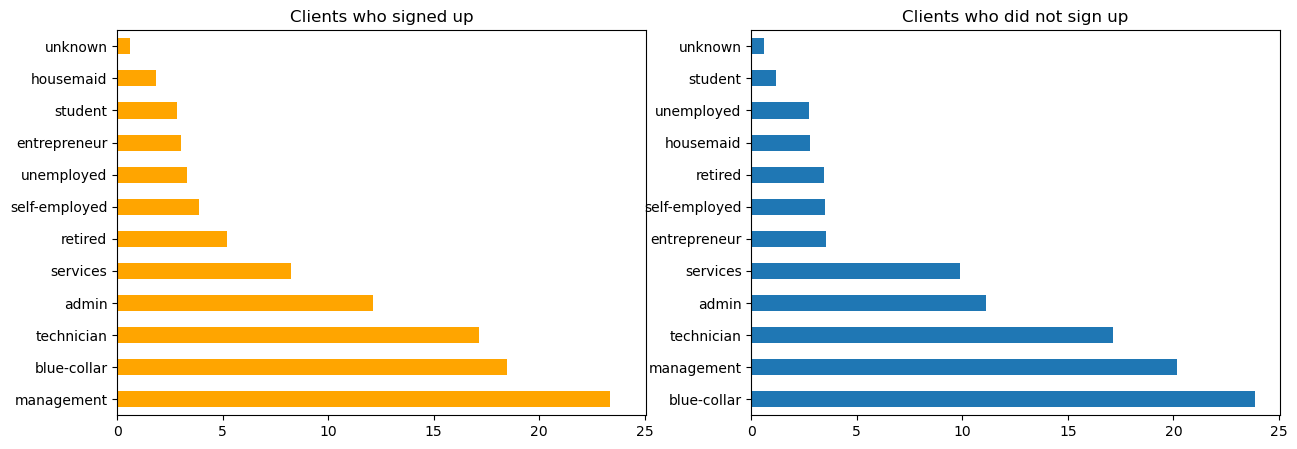

In [35]:
print("Count of Clients by Jobs who subscribed for term deposits: \n",
      (data[data['y']=='yes']['job'].value_counts()/len(data[data['y']=='yes']['job']))*100)
print('\n')
print("Count of Clients by Jobs who didn't subscribe for term deposits: \n",
      (data[data['y']=='no']['job'].value_counts()/len(data[data['y']=='no']['job']))*100)
fig, axes = plt.subplots(1, 2, sharex = True, figsize = (15,5))
((data[data['y']=='yes']['job'].value_counts()/len(data[data['y']=='yes']['job']))*100).plot(ax=axes[0],kind='barh', color = 'orange', 
                                                                                             title = 'Clients who signed up' )
((data[data['y']=='no']['job'].value_counts()/len(data[data['y']=='no']['job']))*100).plot(kind='barh', ax= axes[1], 
                                                                                          title = 'Clients who did not sign up')
plt.show();

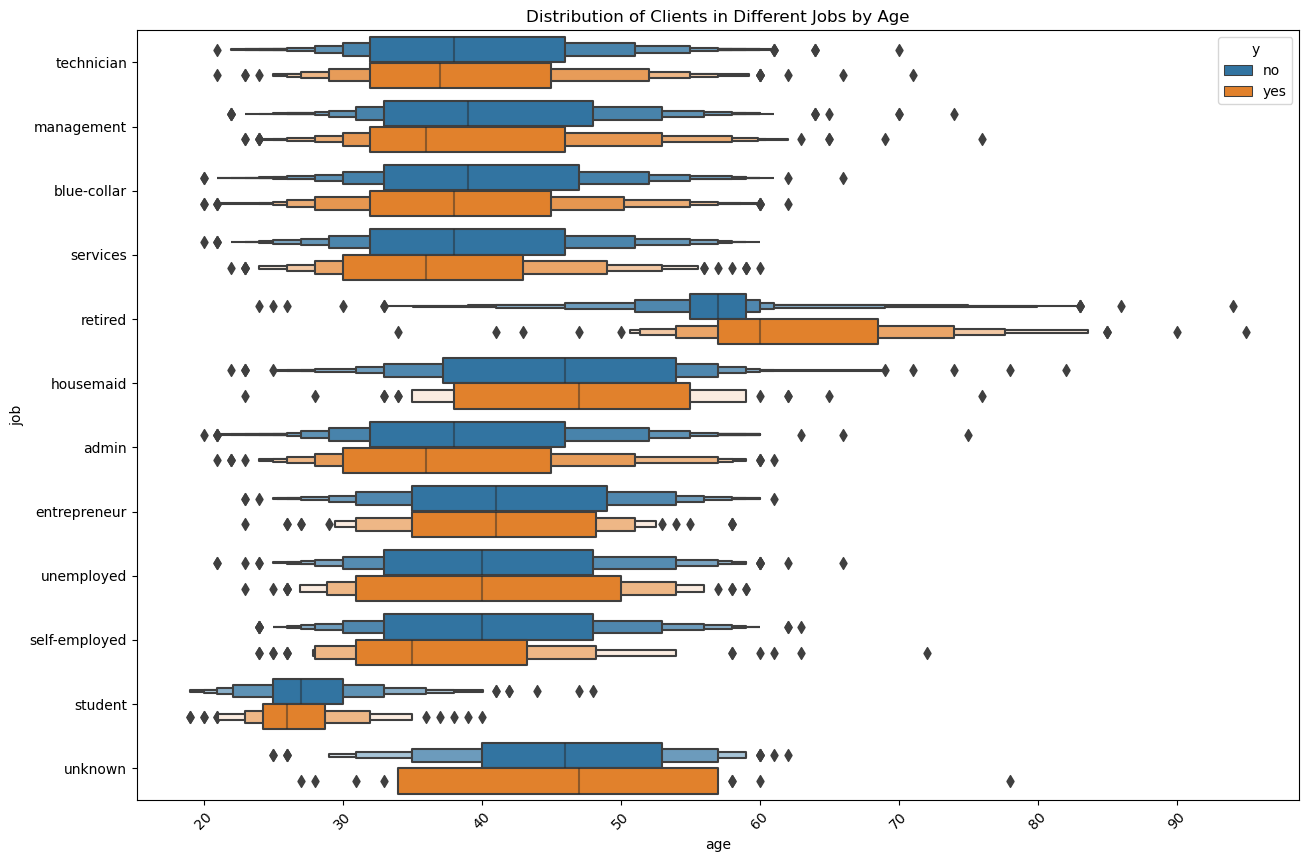

In [36]:
plt.figure(figsize=(15,10))
sns.boxenplot(x='age', y='job', data = data, hue = 'y')
plt.xticks(rotation = 45)
plt.title('Distribution of Clients in Different Jobs by Age')
plt.show();

When we group the clients by their jobs and the different ages they fall into we see roughly each profession, students, the unemployed, and those whose employment information is recorded as unknown have very similar distributions. The exceptions are the retired clients where we see the orange boxplot are at a much higher agegroup compared to the blue boxplot. This roughly supports what we saw earlier about the percentage of clients who subscribed for term deposits were of an older agegroup. 

### Marital

Type of Data: Categorical

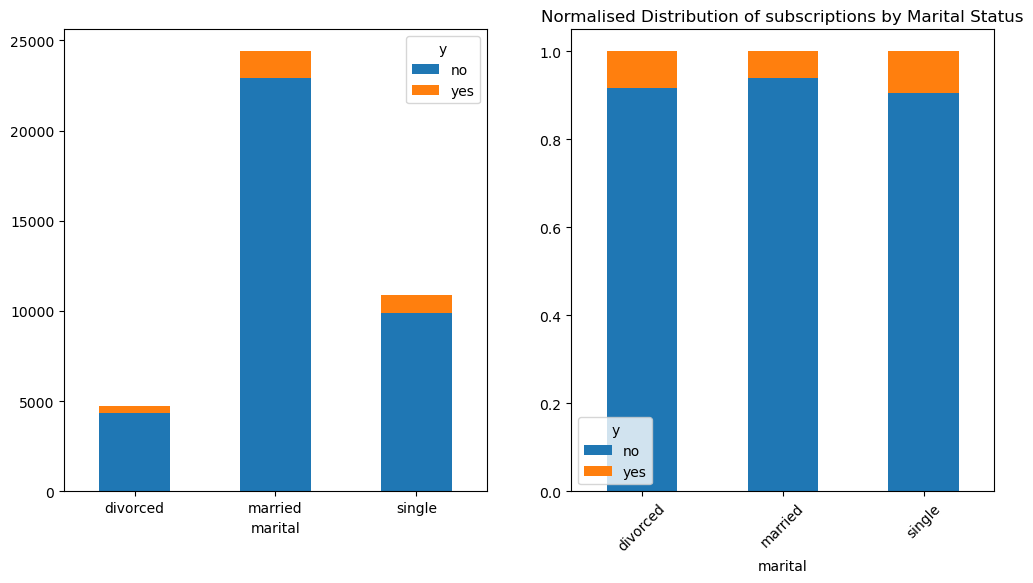

In [37]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (12,6))
pd.crosstab(data['marital'], data['y']).plot(kind='bar', stacked=True, rot=0, ax=axes[0])
data.groupby('marital')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 45,
                                                                             title = 'Normalised Distribution of subscriptions by Marital Status')
plt.show();


Count of Clients by Marital Status who subscribed for term deposits: 
 married     51.035912
single      35.462707
divorced    13.501381
Name: marital, dtype: float64


Count of Clients by Marital Status who didn't subscribe for term deposits: 
 married     61.739974
single      26.579345
divorced    11.680681
Name: marital, dtype: float64


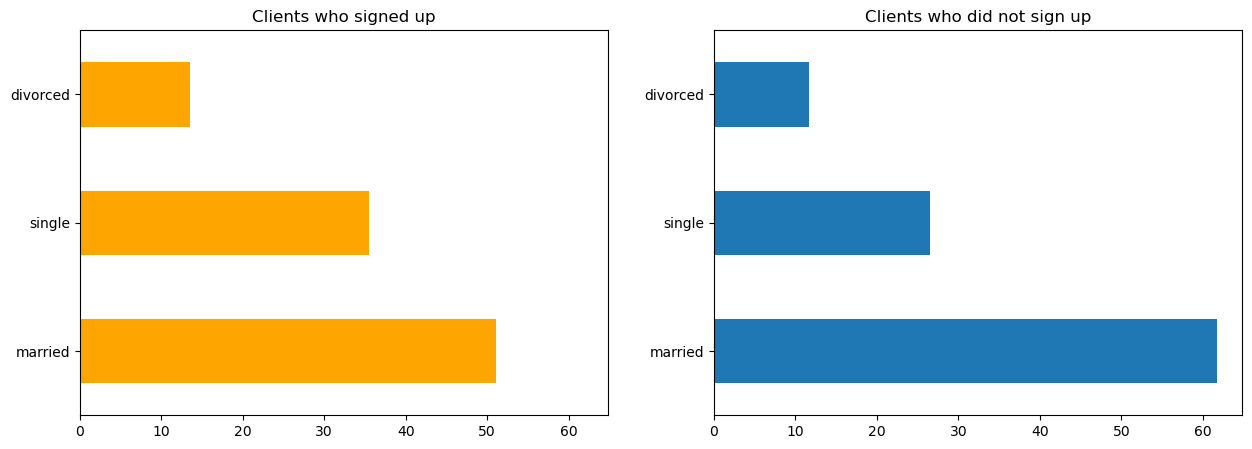

In [38]:
print("Count of Clients by Marital Status who subscribed for term deposits: \n",
      (data[data['y']=='yes']['marital'].value_counts()/len(data[data['y']=='yes']['marital']))*100)
print('\n')
print("Count of Clients by Marital Status who didn't subscribe for term deposits: \n",
      (data[data['y']=='no']['marital'].value_counts()/len(data[data['y']=='no']['marital']))*100)
      

fig, axes = plt.subplots(1, 2, sharex = True, figsize = (15,5))
((data[data['y']=='yes']['marital'].value_counts()/len(data[data['y']=='yes']['marital']))*100).plot(ax = axes[0], kind='barh',
                                                                                                     color = 'orange',
                                                                                                     title = 'Clients who signed up')


((data[data['y']=='no']['marital'].value_counts()/len(data[data['y']=='no']['marital']))*100).plot(ax = axes[1], kind='barh', 
                                                                                                   title = 'Clients who did not sign up')
plt.show();

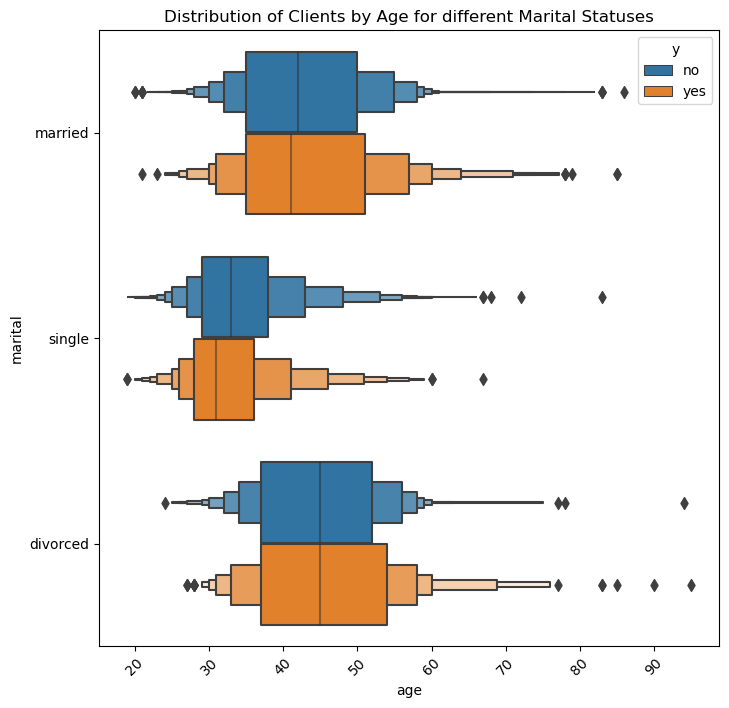

In [39]:
plt.figure(figsize=(8,8))
sns.boxenplot(x='age', y='marital', data = data, hue = 'y')
plt.xticks(rotation = 45)
plt.title('Distribution of Clients by Age for different Marital Statuses')
plt.show();

In [40]:
married = data[data['marital']== 'married']
single = data[data['marital']== 'single']
divorced = data[data['marital']== 'divorced']

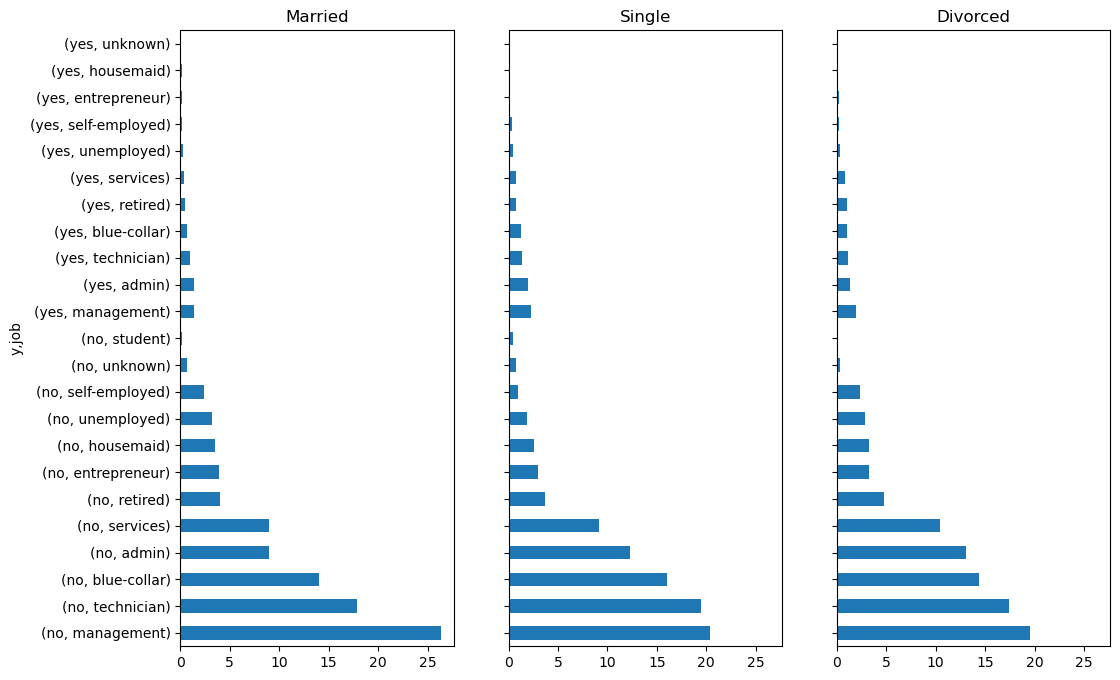

In [41]:
fig, axes = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (12,8))

(married.groupby('y')['job'].value_counts()/len(married)*100).plot(kind='barh', ax=axes[0],
                                                                            title = 'Married')

(single.groupby('y')['job'].value_counts()/len(single)*100).plot(kind='barh', ax = axes[1], 
                                                                      title = 'Single')

(divorced.groupby('y')['job'].value_counts()/len(divorced)*100).plot(kind='barh', ax = axes[2], 
                                                                      title = 'Divorced')
plt.show();


### Education

Tye of Data: Categorical

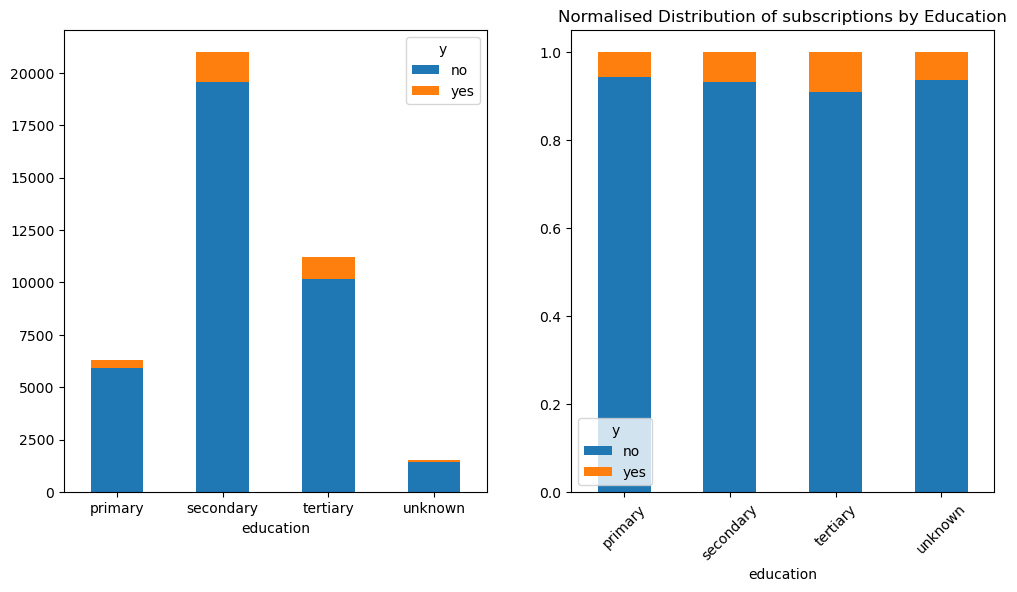

In [42]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (12,6))
pd.crosstab(data['education'], data['y']).plot(ax = axes[0],kind='bar', stacked=True, rot=0)
data.groupby('education')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 45,
                                                                             title = 'Normalised Distribution of subscriptions by Education')

plt.show();

It looks like those with tertiary education backgrounds seem to have a higher proportion of subscriptions. 

Count of Clients by Education background who subscribed for term deposits: 
 secondary    48.964088
tertiary     35.531768
primary      12.189227
unknown       3.314917
Name: education, dtype: float64


Count of Clients by Education background who didn't subscribe for term deposits: 
 secondary    52.757115
tertiary     27.428310
primary      15.947068
unknown       3.867508
Name: education, dtype: float64


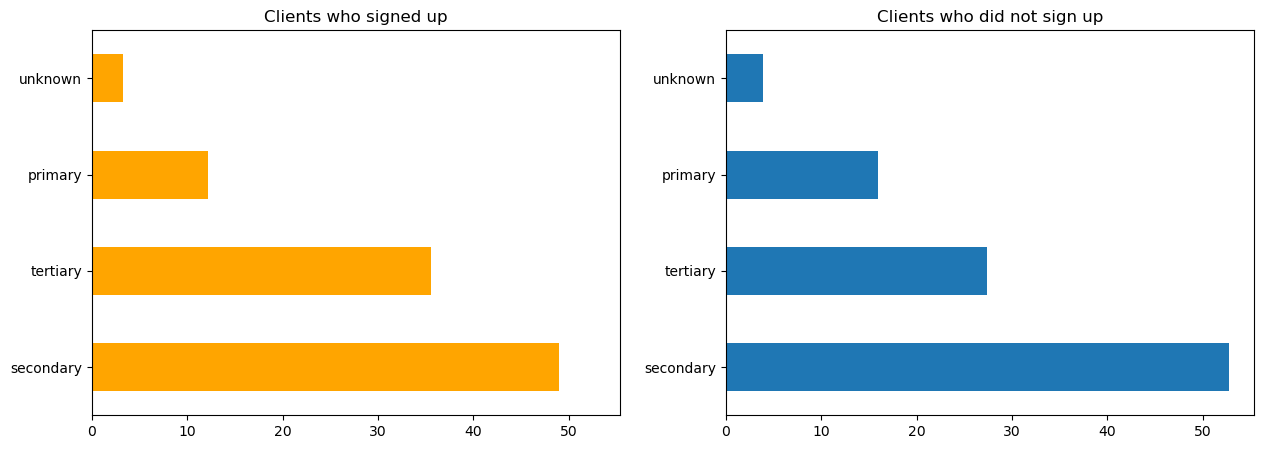

In [43]:
print("Count of Clients by Education background who subscribed for term deposits: \n",
      (data[data['y']=='yes']['education'].value_counts()/len(data[data['y']=='yes']['education']))*100)
print('\n')
print("Count of Clients by Education background who didn't subscribe for term deposits: \n",
      (data[data['y']=='no']['education'].value_counts()/len(data[data['y']=='no']['education']))*100)
      

fig, axes = plt.subplots(1, 2, sharex = True, figsize = (15,5))
((data[data['y']=='yes']['education'].value_counts()/len(data[data['y']=='yes']['education']))*100).plot(ax = axes[0], kind='barh',
                                                                                                     color = 'orange',
                                                                                                     title = 'Clients who signed up')


((data[data['y']=='no']['education'].value_counts()/len(data[data['y']=='no']['education']))*100).plot(ax = axes[1], kind='barh', 
                                                                                                   title = 'Clients who did not sign up')
plt.show();


We see a very similar distribution between clients who did sign up and those who didn't for term deposits. however, it's very obvious that those with a tertiary background is a larger group with subscriptions when compared to those who don't have subscriptions to term deposits. 

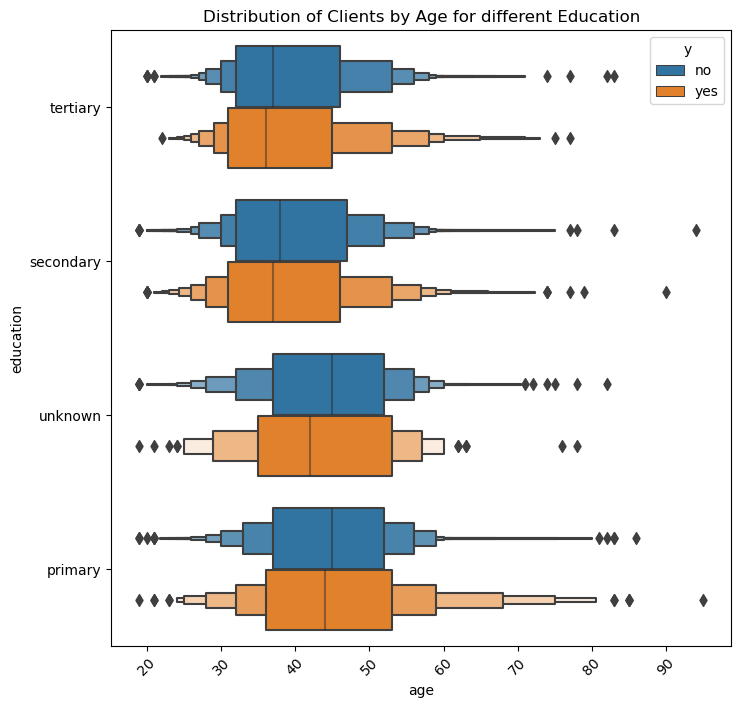

In [44]:
plt.figure(figsize=(8,8))
sns.boxenplot(x='age', y='education', data = data, hue = 'y')
plt.xticks(rotation = 45)
plt.title('Distribution of Clients by Age for different Education')
plt.show();

We see rougly the same distribution in ages between the different education groups. 

In [45]:
crosstable = pd.crosstab(data['education'], data['marital'])
crosstable = pd.DataFrame(crosstable)
crosstable

marital    divorced  married  single
education                           
primary         652     4836     782
secondary      2614    12560    5819
tertiary       1317     5999    3890
unknown         142      991     398

In [46]:
column_names = list(crosstable.columns)
data_names = list(data.columns)

<Figure size 2000x2000 with 0 Axes>

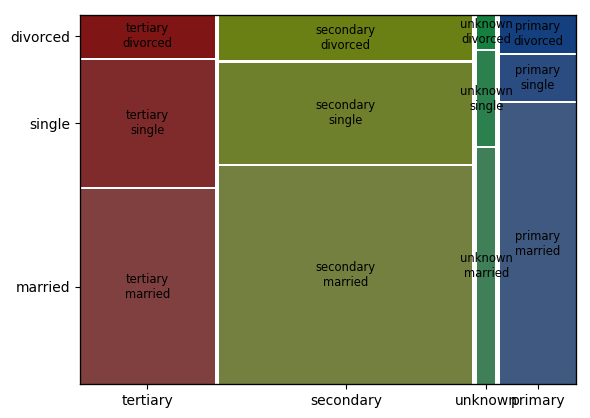

In [47]:
plt.figure(figsize = (20,20))
props = {}
props[(column_names[1], str(crosstable.index[1]))] = {'facecolor': 'red', 'edgecolor': 'white'}
props[(column_names[1], str(crosstable.index[0]))] = {'facecolor': 'yellow', 'edgecolor': 'white'}
props[(column_names[1], str(crosstable.index[2]))] = {'facecolor': 'blue', 'edgecolor': 'white'}
props[(column_names[0], str(crosstable.index[2]))] = {'facecolor': 'green', 'edgecolor': 'white'}
props[(column_names[0], str(crosstable.index[1]))] = {'facecolor': 'orange', 'edgecolor': 'white'}
props[(column_names[0], str(crosstable.index[0]))] = {'facecolor': 'brown', 'edgecolor': 'white'}
props[(column_names[2], str(crosstable.index[0]))] = {'facecolor': 'purple', 'edgecolor': 'white'}
props[(column_names[2], str(crosstable.index[1]))] = {'facecolor': 'cyan', 'edgecolor': 'white'}
props[(column_names[2], str(crosstable.index[2]))] = {'facecolor': 'gray', 'edgecolor': 'white'}
mosaic(data, [data_names[3], data_names[2]], properties = props, gap=0.01 )
plt.show();

## Financial Profile
Some of the features can be used to group customers according to known financial information. For example, we can try to group customers based on their balance, previous borrowing history such as whether they have defaul on loans, if they have housing and personal loans, 
### Default

Type of Data: Binary where 'yes' indicates the customer defaulted on a loan

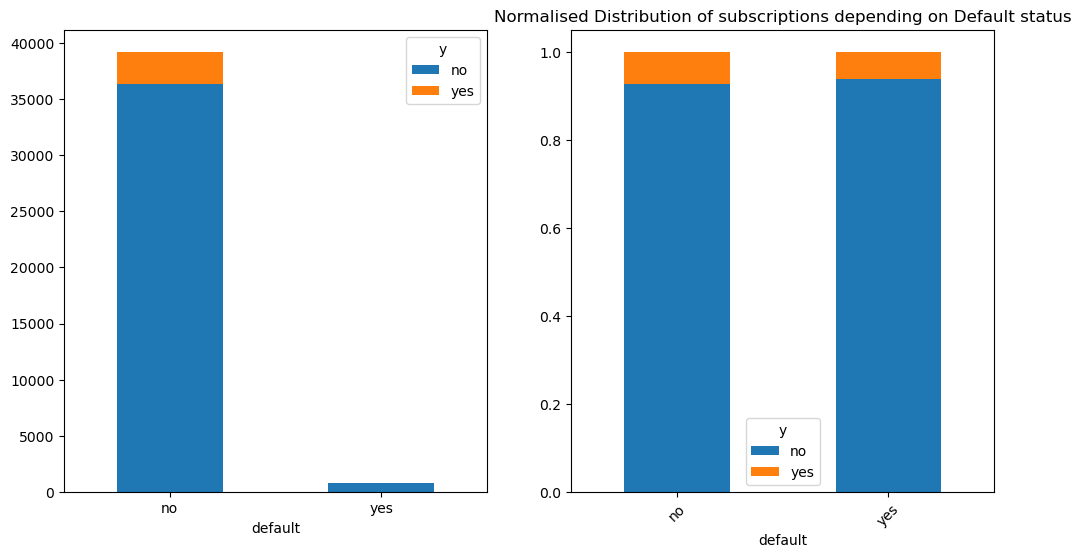

In [48]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (12,6))
pd.crosstab(data['default'], data['y']).plot(ax = axes[0],kind='bar', stacked=True, rot=0)
data.groupby('default')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 45,
                                                                                  title = 'Normalised Distribution of subscriptions depending on Default status')
plt.show();

In [49]:
default_cust = data[data['default']=='yes']
default_cust.describe()

age       balance         day       month     duration  \
count  809.000000    809.000000  809.000000  809.000000   809.000000   
mean    39.547590   -141.856613   16.379481    6.401731   239.304079   
std      9.286849    907.028464    8.570940    2.171610   214.758670   
min     21.000000  -8019.000000    1.000000    1.000000     3.000000   
25%     32.000000   -344.000000    8.000000    5.000000    97.000000   
50%     38.000000     -7.000000   17.000000    6.000000   172.000000   
75%     47.000000     13.000000   23.000000    7.000000   305.000000   
max     60.000000  16486.000000   31.000000   11.000000  1558.000000   

         campaign  
count  809.000000  
mean     3.155748  
std      3.637738  
min      1.000000  
25%      1.000000  
50%      2.000000  
75%      4.000000  
max     36.000000

In [50]:
rest_cust = data[data['default']=='no']
rest_cust.describe()

age        balance           day         month      duration  \
count  39191.000000   39191.000000  39191.000000  39191.000000  39191.000000   
mean      40.565181    1303.510092     16.009747      6.001710    255.144676   
std        9.647993    2923.477921      8.271920      2.303014    260.199300   
min       19.000000   -4057.000000      1.000000      1.000000      0.000000   
25%       33.000000      67.000000      8.000000      5.000000    100.000000   
50%       39.000000     425.000000     16.000000      5.000000    175.000000   
75%       48.000000    1348.000000     21.000000      7.000000    313.000000   
max       95.000000  102127.000000     31.000000     12.000000   4918.000000   

           campaign  
count  39191.000000  
mean       2.876528  
std        3.230111  
min        1.000000  
25%        1.000000  
50%        2.000000  
75%        3.000000  
max       63.000000

In [51]:
print('Percentage of customers who default on loans and are either on 0 balance or overdrawn: ', len(default_cust[default_cust['balance']<=0])/len(default_cust) *100)
print('Percentage of customers who do not default on loans, but are on 0 balance or overdrawn: ', len(rest_cust[rest_cust['balance']<=0])/len(rest_cust) *100)

Percentage of customers who default on loans and are either on 0 balance or overdrawn:  68.60321384425217
Percentage of customers who do not default on loans, but are on 0 balance or overdrawn:  16.29200581766222


In [52]:
len(rest_cust[rest_cust['age']>=60])/len(rest_cust)*100

1.8371564900104616

Distribution of customers who have defaulted on loans by edcuation:
 y    education
no   secondary    53.028430
     tertiary     22.620519
     primary      14.833127
     unknown       3.461063
yes  secondary     3.461063
     tertiary      1.483313
     primary       0.618047
     unknown       0.494438
Name: education, dtype: float64


Distribution of customers who have not defaulted on loans by edcuation:
 y    education
no   secondary    48.853053
     tertiary     25.500753
     primary      14.791661
     unknown       3.590110
yes  secondary     3.546733
     tertiary      2.594984
     primary       0.887959
     unknown       0.234748
Name: education, dtype: float64


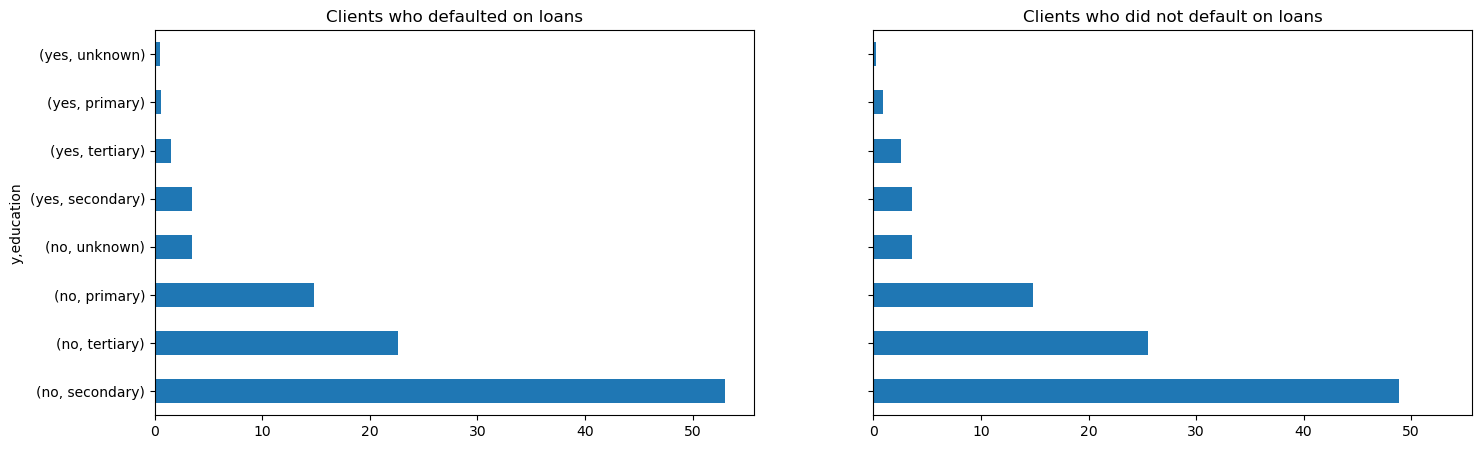

In [53]:
print('Distribution of customers who have defaulted on loans by edcuation:\n' , default_cust.groupby('y')['education'].value_counts()/len(default_cust)*100)
print('\n')
print('Distribution of customers who have not defaulted on loans by edcuation:\n' , rest_cust.groupby('y')['education'].value_counts()/len(rest_cust)*100)
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (17,5))

(default_cust.groupby('y')['education'].value_counts()/len(default_cust)*100).plot(kind='barh', ax=axes[0], title = 'Clients who defaulted on loans')

(rest_cust.groupby('y')['education'].value_counts()/len(rest_cust)*100).plot(kind='barh', ax=axes[1],
                                                                            title= 'Clients who did not default on loans')
plt.show();

Distribution of customers who have defaulted on loans segmented by jobs:
 y    job          
no   blue-collar      22.991347
     management       19.283066
     technician       14.709518
     admin             8.776267
     services          8.652658
     entrepreneur      6.056860
     self-employed     3.831891
     unemployed        3.461063
     retired           3.090235
     housemaid         2.595797
     student           0.247219
     unknown           0.247219
yes  blue-collar       1.854141
     technician        1.236094
     management        0.865266
     entrepreneur      0.741656
     services          0.494438
     admin             0.370828
     self-employed     0.247219
     housemaid         0.123609
     unemployed        0.123609
Name: job, dtype: float64


Distribution of customers who have not defaulted on loans segmented by jobs:
 y    job          
no   blue-collar      22.102013
     management       18.713480
     technician       15.911816
     admin    

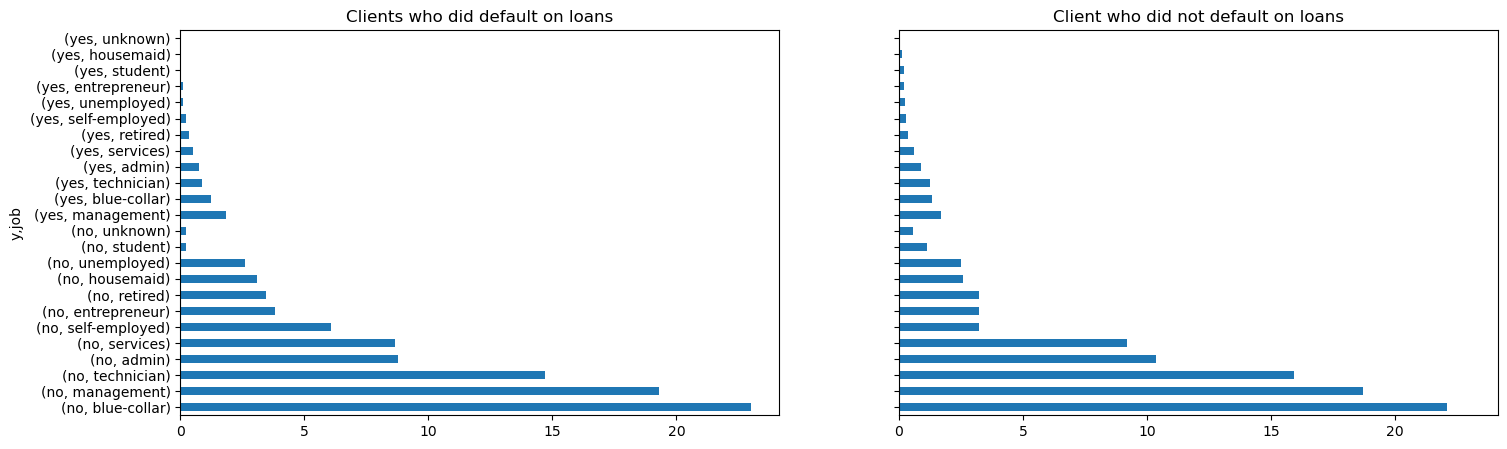

In [54]:
print('Distribution of customers who have defaulted on loans segmented by jobs:\n' , default_cust.groupby('y')['job'].value_counts()/len(default_cust)*100)
print('\n')
print('Distribution of customers who have not defaulted on loans segmented by jobs:\n' , rest_cust.groupby('y')['job'].value_counts()/len(rest_cust)*100)
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (17,5))

(default_cust.groupby('y')['job'].value_counts()/len(default_cust)*100).plot(kind='barh', ax=axes[0],
                                                                            title = 'Clients who did default on loans')

(rest_cust.groupby('y')['job'].value_counts()/len(rest_cust)*100).plot(kind='barh', ax = axes[1], 
                                                                      title = 'Client who did not default on loans')
plt.show();


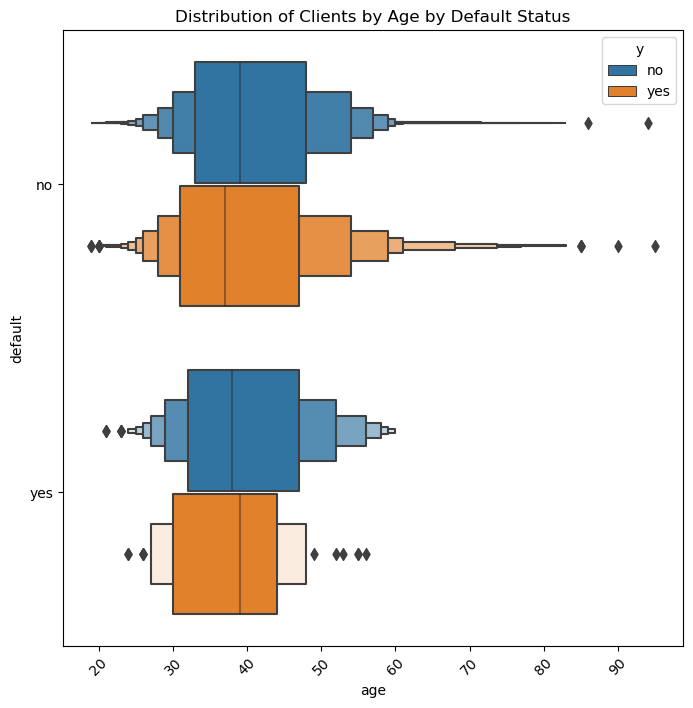

In [55]:
plt.figure(figsize=(8,8))
sns.boxenplot(x='age', y='default', data = data, hue = 'y')
plt.xticks(rotation = 45)
plt.title('Distribution of Clients by Age by Default Status')
plt.show();

As we would expect, those who have previously defaulted on loans mostly didn't sign up for term deposits. Those with secondary level education are the largest group of those who took out loans, again forming the largest segmentation of customers who did default on loans and had signed up for term deposits. This doens't necessarily mean that secondary education is what we should look for when trying to determine which customers to target and could be just a consequence of the inblanaced dataset. 

### Average Yearly Balance (Euros)

Type of Data: Numeric (integer)


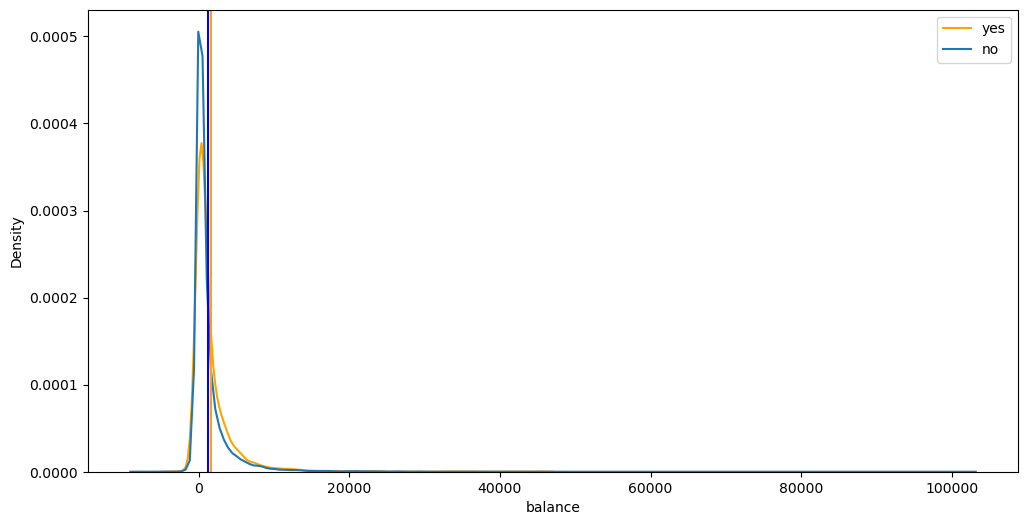

In [56]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.kdeplot(data[data['y']=='yes']['balance'], color = 'orange', ax = ax, label = 'yes')
sns.kdeplot(data[data['y']=='no']['balance'], ax = ax, label = 'no')
plt.axvline(np.mean((data[data['y']=='yes']['balance'])), c = 'orange')
plt.axvline(np.mean((data[data['y']=='no']['balance'])), c = 'blue')
ax.legend()
plt.show();

In [57]:
np.min(data['balance'])

-8019

In [58]:
print('Number of customers who have 0 or negative balance: ', len(data[data['balance']<=0]))
print('Percentage of the whole dataset who are overdrawn or on 0 balance: ',len(data[data['balance']<=0])/len(data)*100)

Number of customers who have 0 or negative balance:  6940
Percentage of the whole dataset who are overdrawn or on 0 balance:  17.349999999999998


In [59]:
overdrawn_customers = data[data['balance']<=0]
overdrawn_customers.head()

age         job  marital  education default  balance housing loan  \
22532   34  management   single  secondary      no        0      no   no   
12882   47  technician   single  secondary      no     -239     yes  yes   
19133   37  technician  married  secondary      no        0      no   no   
8006    33  technician   single  secondary      no     -244     yes   no   
12810   37  management   single   tertiary      no        0      no   no   

        contact  day  month  duration  campaign    y  
22532  cellular   22      8       132         4   no  
12882  cellular    7      7       973         3  yes  
19133  cellular    5      8       409         1   no  
8006    unknown    2      6        63         2   no  
12810  cellular    7      7       643         3   no

In [60]:
incredit_customers = data[data['balance']>0]
incredit_customers.head()

age          job  marital  education default  balance housing loan  \
20749   38   technician  married   tertiary      no      128      no   no   
16174   34   management   single   tertiary      no      184      no   no   
36796   31   technician   single  secondary      no        1     yes   no   
15078   51   management  married   tertiary      no      333      no  yes   
37238   43  blue-collar  married  secondary      no      171     yes   no   

        contact  day  month  duration  campaign   y  
20749  cellular   13      8       183         5  no  
16174  cellular   22      7       203         4  no  
36796  cellular   12      5       223         1  no  
15078  cellular   17      7       234         1  no  
37238  cellular   13      5        96         1  no

Percentage of Customers who have 0 balance or are overdrawn:  no     94.582133
yes     5.417867
Name: y, dtype: float64


Percentage of Customers who have more than 0 balance:  no     92.377495
yes     7.622505
Name: y, dtype: float64


<AxesSubplot:title={'center':'Clients with balance more than 0'}>

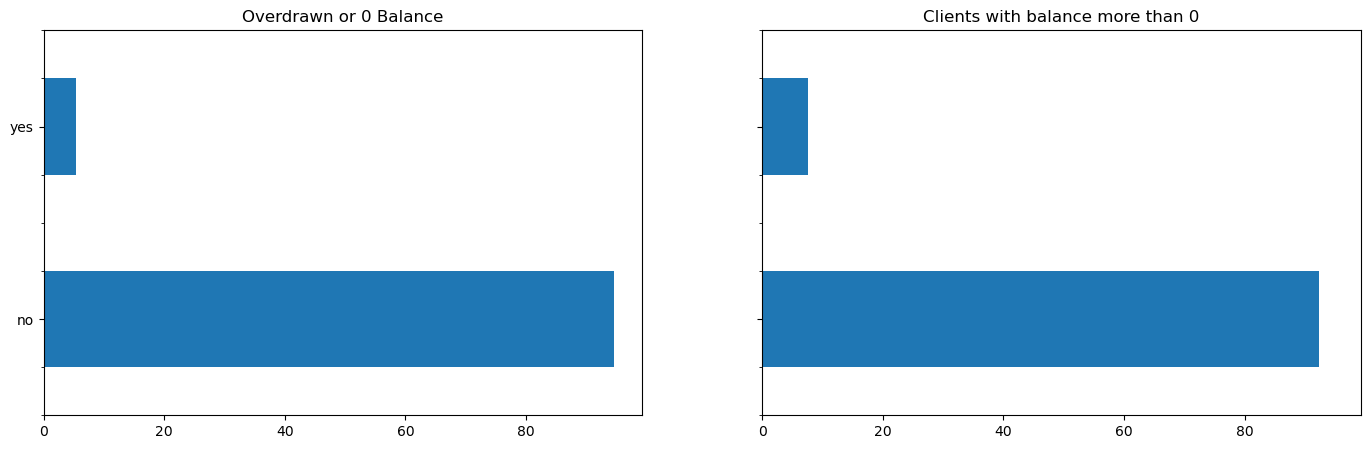

In [61]:
print('Percentage of Customers who have 0 balance or are overdrawn: ', overdrawn_customers['y'].value_counts()/len(overdrawn_customers)*100)
print('\n')
print('Percentage of Customers who have more than 0 balance: ',incredit_customers['y'].value_counts()/len(incredit_customers)*100)

fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (17,5))

(overdrawn_customers['y'].value_counts()/len(overdrawn_customers)*100).plot(ax = axes[0], 
                                                                            title= 'Overdrawn or 0 Balance',
                                                                            kind='barh')


(incredit_customers['y'].value_counts()/len(incredit_customers)*100).plot(ax = axes[1],
                                                                          title = "Clients with balance more than 0",
                                                                          kind='barh')

In [62]:
overdrawn_customers.describe()

age      balance          day        month     duration  \
count  6940.000000  6940.000000  6940.000000  6940.000000  6940.000000   
mean     40.302882  -171.647983    16.471182     6.101441   247.664265   
std       9.287698   314.382683     8.474296     2.044419   246.987243   
min      19.000000 -8019.000000     1.000000     1.000000     3.000000   
25%      33.000000  -254.000000     9.000000     5.000000   100.000000   
50%      39.000000   -17.000000    17.000000     6.000000   172.000000   
75%      47.000000     0.000000    23.000000     7.000000   304.000000   
max      86.000000     0.000000    31.000000    12.000000  3253.000000   

          campaign  
count  6940.000000  
mean      3.054035  
std       3.671885  
min       1.000000  
25%       1.000000  
50%       2.000000  
75%       3.000000  
max      43.000000

In [63]:
incredit_customers.describe()

age        balance           day         month      duration  \
count  33060.000000   33060.000000  33060.000000  33060.000000  33060.000000   
mean      40.595342    1577.808197     15.921930      5.990563    256.327344   
std        9.713838    3106.475225      8.233306      2.350996    261.869606   
min       19.000000       1.000000      1.000000      1.000000      0.000000   
25%       33.000000     214.000000      8.000000      5.000000     99.000000   
50%       39.000000     606.000000     16.000000      5.000000    176.000000   
75%       48.000000    1650.250000     21.000000      7.000000    315.000000   
max       95.000000  102127.000000     31.000000     12.000000   4918.000000   

           campaign  
count  33060.000000  
mean       2.846098  
std        3.139491  
min        1.000000  
25%        1.000000  
50%        2.000000  
75%        3.000000  
max       63.000000

Distribution of overdrawn customers by edcuation:
 y    education
no   secondary    53.011527
     tertiary     22.853026
     primary      15.201729
     unknown       3.515850
yes  secondary     2.881844
     tertiary      1.700288
     primary       0.749280
     unknown       0.086455
Name: education, dtype: float64
Distribution of incredit customers by edcuation:
 y    education
no   secondary    48.082275
     tertiary     25.986086
     primary      14.706594
     unknown       3.602541
yes  secondary     3.684211
     tertiary      2.755596
     primary       0.910466
     unknown       0.272232
Name: education, dtype: float64


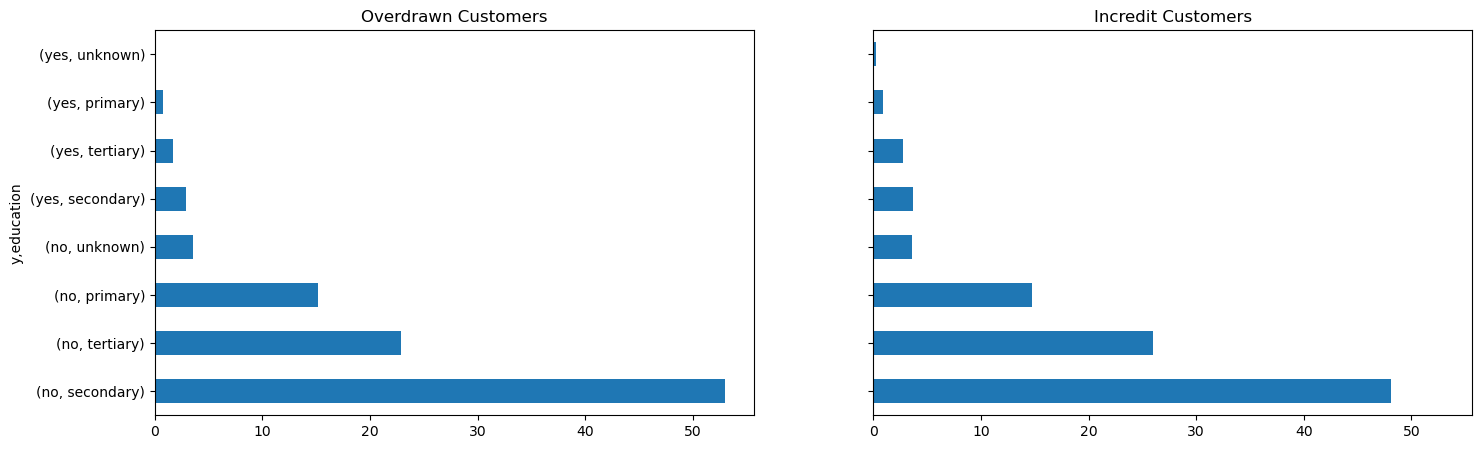

In [64]:
print('Distribution of overdrawn customers by edcuation:\n' , overdrawn_customers.groupby('y')['education'].value_counts()/len(overdrawn_customers)*100)
print('Distribution of incredit customers by edcuation:\n' , incredit_customers.groupby('y')['education'].value_counts()/len(incredit_customers)*100)
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (17,5))
(overdrawn_customers.groupby('y')['education'].value_counts()/len(overdrawn_customers)*100).plot(ax = axes[0],kind='barh', 
                                                                                 title= 'Overdrawn Customers')
(incredit_customers.groupby('y')['education'].value_counts()/len(incredit_customers)*100).plot(kind='barh', ax=axes[1], 
                                                                              title = 'Incredit Customers')
plt.show();

Distribution of overdrawn customers by employment:
 y    job          
no   blue-collar      23.371758
     management       18.198847
     technician       16.469741
     admin            10.936599
     services         10.619597
     entrepreneur      3.429395
     retired           3.097983
     self-employed     2.766571
     housemaid         2.449568
     unemployed        2.319885
     student           0.533141
     unknown           0.389049
yes  blue-collar       1.167147
     management        0.951009
     technician        0.907781
     services          0.691643
     admin             0.662824
     entrepreneur      0.331412
     self-employed     0.201729
     retired           0.187320
     unemployed        0.129683
     student           0.086455
     housemaid         0.072046
     unknown           0.028818
Name: job, dtype: float64


Distribution of incredit customers by employment:
 y    job          
no   blue-collar      21.857229
     management       18.835451

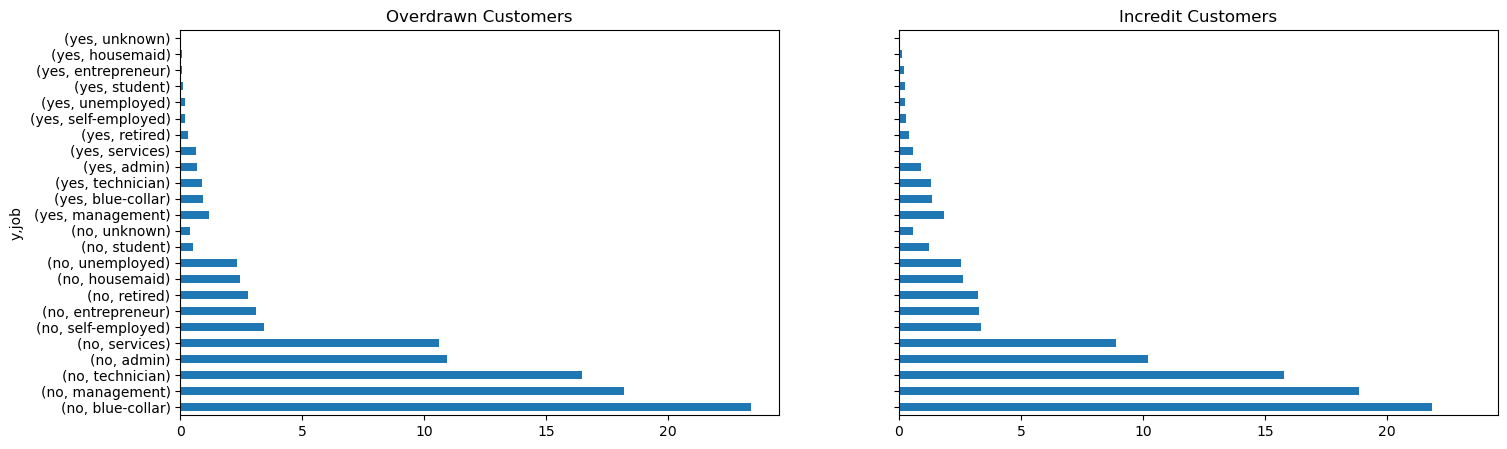

In [65]:
print('Distribution of overdrawn customers by employment:\n' , overdrawn_customers.groupby('y')['job'].value_counts()/len(overdrawn_customers)*100)
print('\n')
print('Distribution of incredit customers by employment:\n' , incredit_customers.groupby('y')['job'].value_counts()/len(incredit_customers)*100)
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (17,5))
(overdrawn_customers.groupby('y')['job'].value_counts()/len(overdrawn_customers)*100).plot(ax=axes[0],kind='barh', 
                                                                                          title = 'Overdrawn Customers')
(incredit_customers.groupby('y')['job'].value_counts()/len(incredit_customers)*100).plot(kind='barh', stacked=True, ax=axes[1], 
                                                                                        title = 'Incredit Customers')
plt.show();

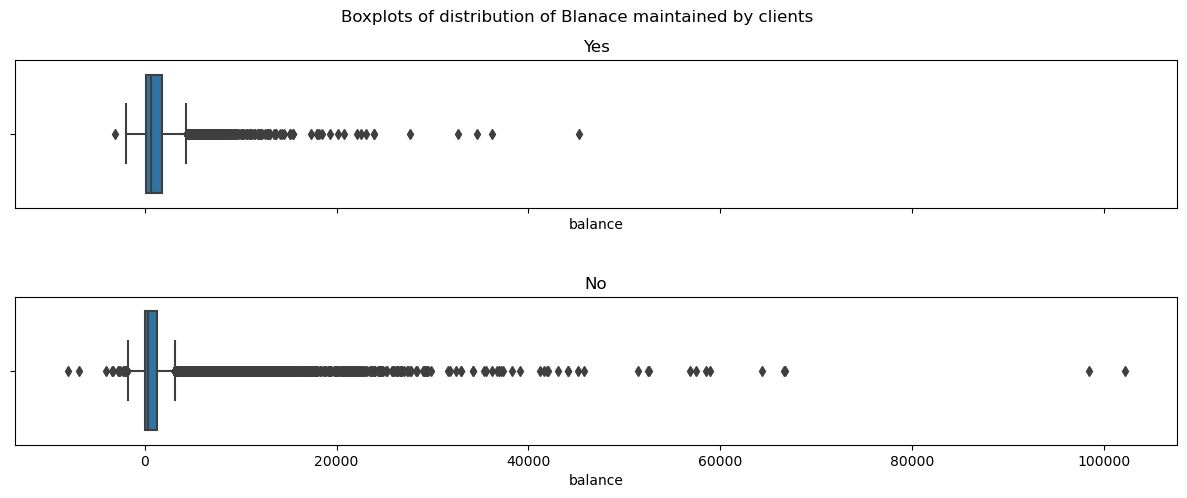

In [66]:
fig, axes = plt.subplots(2, 1, sharex = True, figsize = (15,5))
fig.suptitle('Boxplots of distribution of Blanace maintained by clients')
sns.boxplot(x='balance', data = data[data['y']=='yes'], ax= axes[0])
axes[0].set_title('Yes')
sns.boxplot(x='balance', data = data[data['y']=='no'], ax = axes[1] )
axes[1].set_title('No')
plt.subplots_adjust(wspace=0.6, hspace=0.6)
plt.show();

In [67]:
np.min(data[data['y']=='yes']['balance'])

-3058

In [68]:
np.max(data[data['y']=='no']['balance'])

102127

In [69]:
np.max(data[data['y']=='yes']['balance'])

45248

<AxesSubplot:xlabel='balance', ylabel='default'>

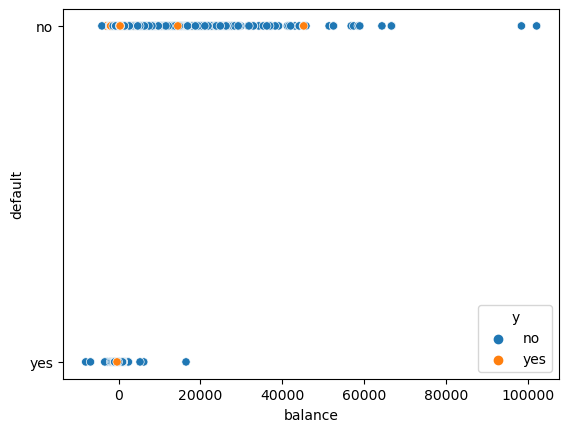

In [70]:
sns.scatterplot(x='balance', y='default', data=data, hue='y')

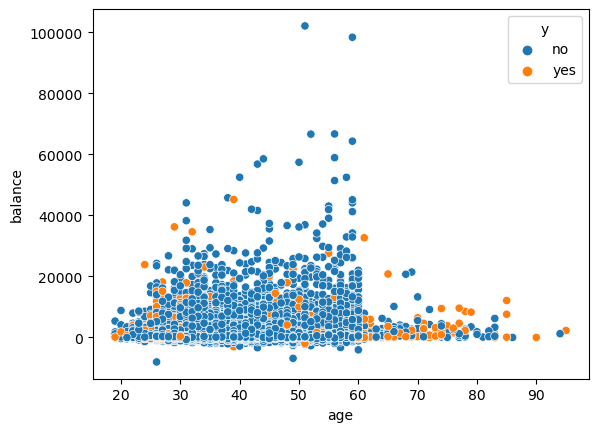

In [71]:
sns.scatterplot(x='age', y='balance', data = data, hue = 'y')
plt.show();

We see roughly 5% of customers who had defaulted on loans and had agreed to term deposits maintained an average annual balance of 0 or were overdrawn. This goes up to roughly 8% when we look at customers who haven't defaulted on loans. When we compare the customer profiling metrics between overdrawn and incredit customers we see that both of these groups have roughly the same distribution in ages of customers. We see the the percentages of customers from various education backgrounds and to some extent in jobs are also mimicked between those who are overdrawn and those who aren't. This suggests that looking to differentiate between customers with overdrawn as a feature is not useful. When we look at the balance of customers who have signed up for term deposits grouped by employmnet and education backgrounds, we do see that for every segment customers who have higher balances sign up for term deposits. This suggests balance is a possible key feature, however how to segment customers based on balance is something we need to dig deeper into. 

### Housing Loans

Type of data: Binary where 'yes' indicates whether the customer has housing loans or not

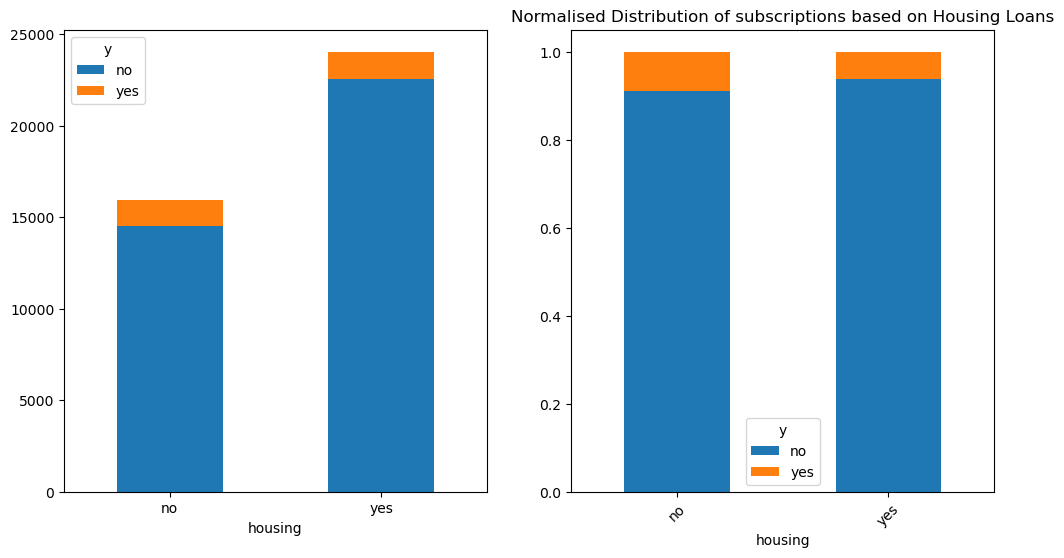

In [72]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (12,6))
pd.crosstab(data['housing'], data['y']).plot(kind='bar', stacked=True, rot=0, ax=axes[0])
data.groupby('housing')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 45,
                                                                             title = 'Normalised Distribution of subscriptions based on Housing Loans')
plt.show();

In [73]:
has_housing = data[data['housing']=='yes']
no_housing = data[data['housing']=='no']

Distribution of customers who have housing loans segmented by education:
 y    education
no   secondary    52.969082
     tertiary     22.679040
     primary      15.163747
     unknown       3.096001
yes  secondary     3.324872
     tertiary      1.747742
     primary       0.853065
     unknown       0.166452
Name: education, dtype: float64
Distribution of customers without housing loans segmented by education:
 y    education
no   secondary    42.870562
     tertiary     29.601102
     primary      14.233828
     unknown       4.327134
yes  secondary     3.876260
     tertiary      3.813639
     primary       0.926796
     unknown       0.350679
Name: education, dtype: float64


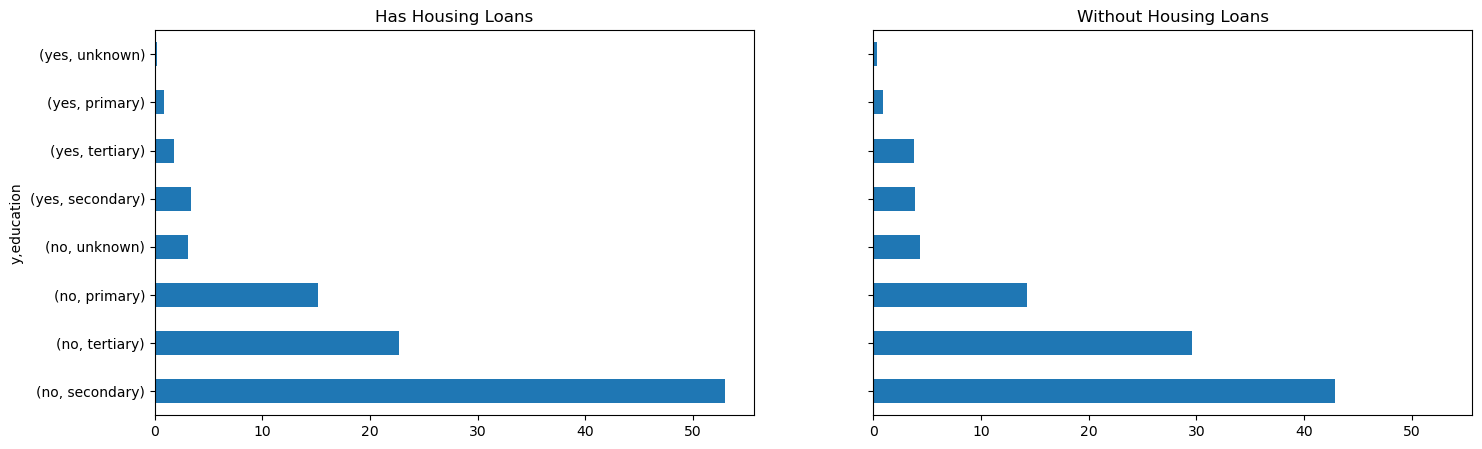

In [74]:
print('Distribution of customers who have housing loans segmented by education:\n' , has_housing.groupby('y')['education'].value_counts()/len(has_housing)*100)
print('Distribution of customers without housing loans segmented by education:\n' , no_housing.groupby('y')['education'].value_counts()/len(no_housing)*100)
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (17,5))
(has_housing.groupby('y')['education'].value_counts()/len(has_housing)*100).plot(ax = axes[0],kind='barh', 
                                                                                 title= 'Has Housing Loans')
(no_housing.groupby('y')['education'].value_counts()/len(no_housing)*100).plot(kind='barh', ax=axes[1], 
                                                                              title = 'Without Housing Loans')
plt.show();

Distribution of customers who have housing loans segmented by jobs:
 y    job          
no   blue-collar      27.281428
     management       16.940618
     technician       15.142940
     admin            11.401939
     services         10.644584
     entrepreneur      3.366485
     self-employed     2.821356
     unemployed        2.022388
     retired           1.776872
     housemaid         1.498065
     student           0.915484
     unknown           0.095710
yes  blue-collar       1.568807
     management        1.240065
     technician        0.998710
     admin             0.819774
     services          0.640839
     self-employed     0.228871
     entrepreneur      0.195581
     unemployed        0.120677
     retired           0.112355
     housemaid         0.079065
     student           0.079065
     unknown           0.008323
Name: job, dtype: float64
Distribution of customers without housing loans segmented by education:
 y    job          
no   management       21.4

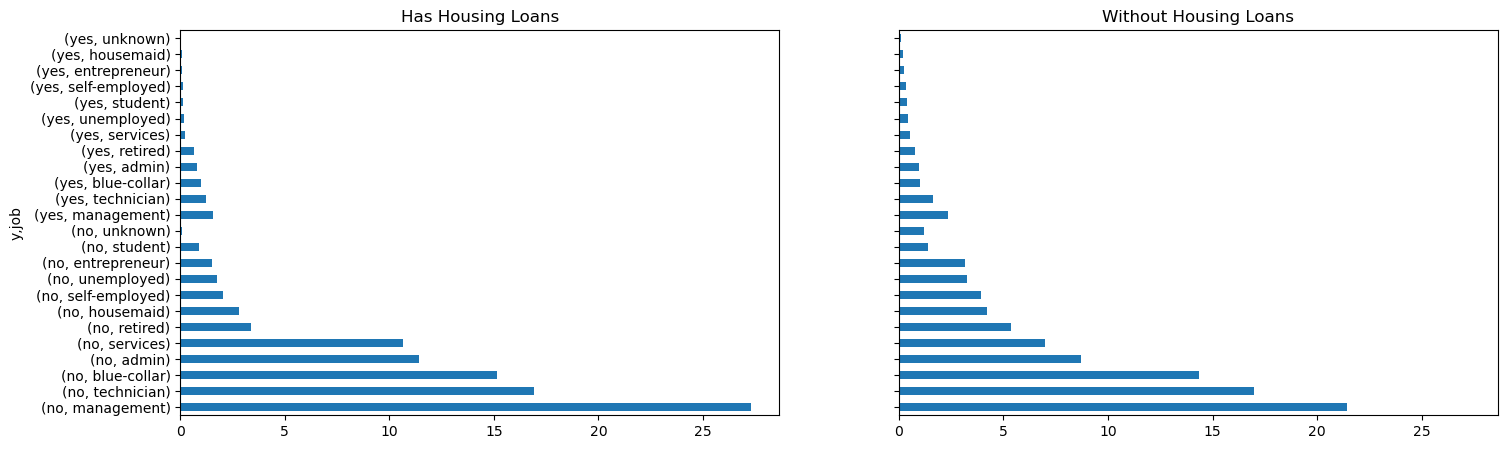

In [75]:
print('Distribution of customers who have housing loans segmented by jobs:\n' , has_housing.groupby('y')['job'].value_counts()/len(has_housing)*100)
print('Distribution of customers without housing loans segmented by education:\n' , no_housing.groupby('y')['job'].value_counts()/len(no_housing)*100)
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (17,5))
(has_housing.groupby('y')['job'].value_counts()/len(has_housing)*100).plot(ax = axes[0],kind='barh', 
                                                                                 title= 'Has Housing Loans')
(no_housing.groupby('y')['job'].value_counts()/len(no_housing)*100).plot(kind='barh', ax=axes[1], 
                                                                              title = 'Without Housing Loans')
plt.show();

In [76]:
has_housing

age          job  marital  education default  balance housing loan  \
36796   31   technician   single  secondary      no        1     yes   no   
12882   47   technician   single  secondary      no     -239     yes  yes   
37238   43  blue-collar  married  secondary      no      171     yes   no   
3300    44  blue-collar  married    unknown      no      146     yes   no   
34399   28  blue-collar   single  secondary      no     4229     yes  yes   
...    ...          ...      ...        ...     ...      ...     ...  ...   
4795    39   management  married   tertiary      no      151     yes   no   
35124   31   management  married   tertiary      no     -692     yes  yes   
28360   28  blue-collar  married  secondary      no      255     yes   no   
24250   45   technician  married  secondary      no     1477     yes   no   
37990   30  blue-collar  married  secondary      no      378     yes   no   

        contact  day  month  duration  campaign    y  
36796  cellular   12      5       223         1   no  
12882  cellular    7      7       973         3  yes  
37238  cellular   13      5        96         1   no  
3300    unknown   15      5       483         1  yes  
34399  cellular    5      5       205         2   no  
...         ...  ...    ...       ...       ...  ...  
4795    unknown   21      5       692         1   no  
35124  cellular    6      5       117         2   no  
28360  cellular   29      1       602         2   no  
24250  cellular   17     11        75         1   no  
37990  cellular   14      5       566         2  yes  

[24031 rows x 14 columns]

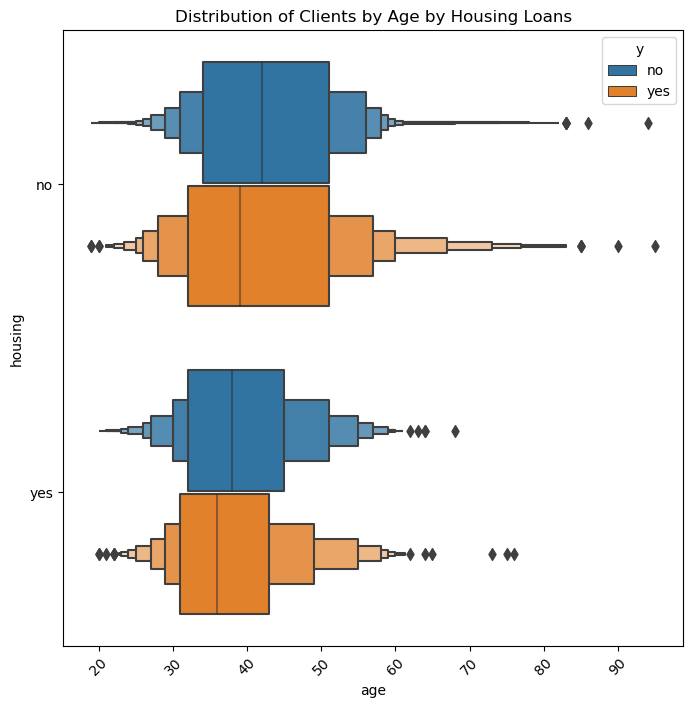

In [77]:
plt.figure(figsize=(8,8))
sns.boxenplot(x='age', y='housing', data = data, hue = 'y')
plt.xticks(rotation = 45)
plt.title('Distribution of Clients by Age by Housing Loans')
plt.show();

### Personal Loan

Type of Data: Binary data where 'yes' indicates the customer has personal loans 

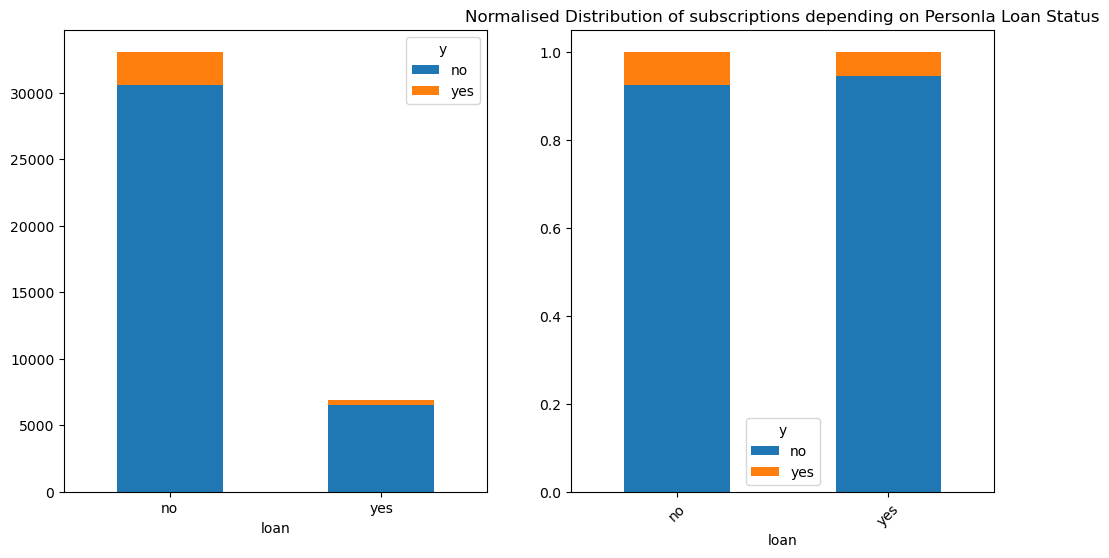

In [78]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (12,6))
pd.crosstab(data['loan'], data['y']).plot(ax = axes[0],kind='bar', stacked=True, rot=0)
data.groupby('loan')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 45,
                                                                                  title = 'Normalised Distribution of subscriptions depending on Personla Loan Status')
plt.show();

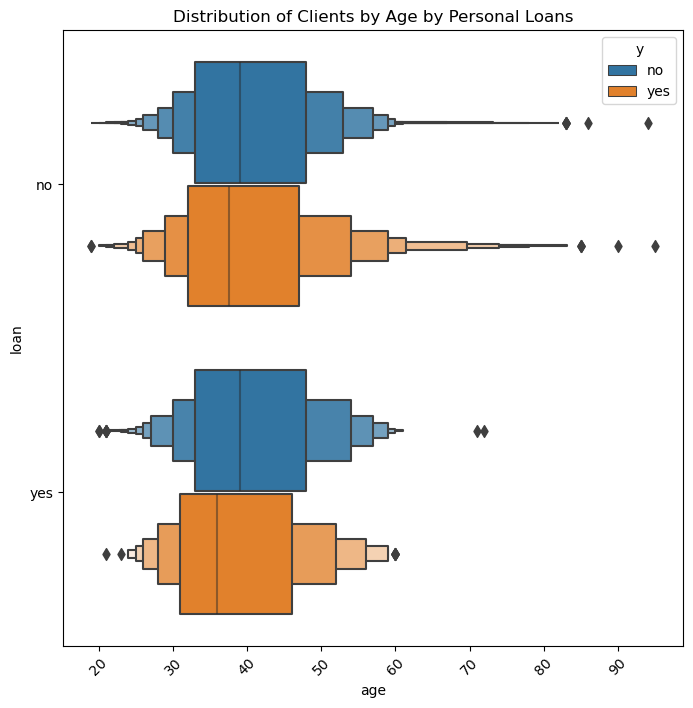

In [79]:
plt.figure(figsize=(8,8))
sns.boxenplot(x='age', y='loan', data = data, hue = 'y')
plt.xticks(rotation = 45)
plt.title('Distribution of Clients by Age by Personal Loans')
plt.show();

In [80]:
has_personal_loan = data[data['loan']=='yes']
has_no_loan = data[data['loan']=='no']

Distribution of customers with personal loans:
 y    education
no   secondary    56.349206
     tertiary     22.510823
     primary      13.924964
     unknown       1.731602
yes  secondary     3.275613
     tertiary      1.385281
     primary       0.721501
     unknown       0.101010
Name: education, dtype: float64


Distribution of customers without personal loans: 
 y    education
no   secondary    47.384336
     tertiary     26.056849
     primary      14.974297
     unknown       3.976414
yes  secondary     3.601451
     tertiary      2.821288
     primary       0.916238
     unknown       0.269126
Name: education, dtype: float64


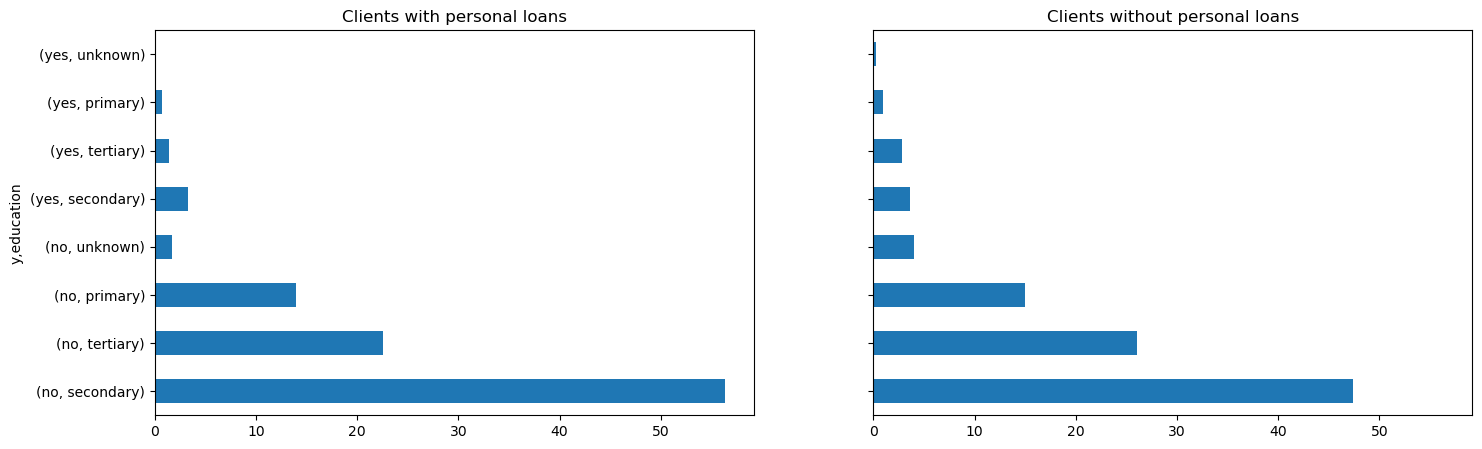

In [81]:
print('Distribution of customers with personal loans:\n' , has_personal_loan.groupby('y')['education'].value_counts()/len(has_personal_loan)*100)
print('\n')
print('Distribution of customers without personal loans: \n' , has_no_loan.groupby('y')['education'].value_counts()/len(has_no_loan)*100)
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (17,5))

(has_personal_loan.groupby('y')['education'].value_counts()/len(has_personal_loan)*100).plot(kind='barh', ax=axes[0], title = 'Clients with personal loans')

(has_no_loan.groupby('y')['education'].value_counts()/len(has_no_loan)*100).plot(kind='barh', ax=axes[1],
                                                                            title= 'Clients without personal loans')
plt.show();

Distribution of customers with personal loans:
 y    job          
no   blue-collar      22.582973
     technician       16.940837
     management       16.161616
     admin            12.077922
     services         11.269841
     entrepreneur      4.819625
     retired           4.098124
     self-employed     2.929293
     housemaid         2.049062
     unemployed        1.428571
     student           0.129870
     unknown           0.028860
yes  blue-collar       1.399711
     management        0.923521
     technician        0.880231
     admin             0.865801
     services          0.577201
     self-employed     0.245310
     entrepreneur      0.230880
     retired           0.202020
     housemaid         0.072150
     unemployed        0.057720
     unknown           0.028860
Name: job, dtype: float64


Distribution of customers without personal loans: 
 y    job          
no   blue-collar      22.022982
     management       19.262171
     technician       15.666767
  

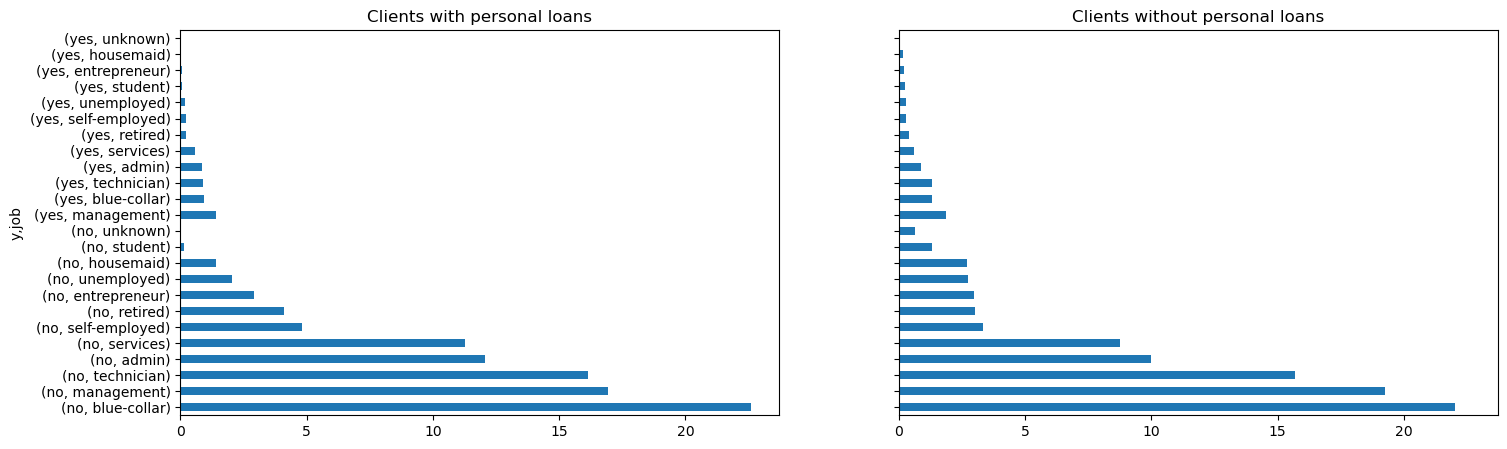

In [82]:
print('Distribution of customers with personal loans:\n' , has_personal_loan.groupby('y')['job'].value_counts()/len(has_personal_loan)*100)
print('\n')
print('Distribution of customers without personal loans: \n' , has_no_loan.groupby('y')['job'].value_counts()/len(has_no_loan)*100)
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (17,5))

(has_personal_loan.groupby('y')['job'].value_counts()/len(has_personal_loan)*100).plot(kind='barh', ax=axes[0], title = 'Clients with personal loans')

(has_no_loan.groupby('y')['job'].value_counts()/len(has_no_loan)*100).plot(kind='barh', ax=axes[1],
                                                                            title= 'Clients without personal loans')
plt.show();

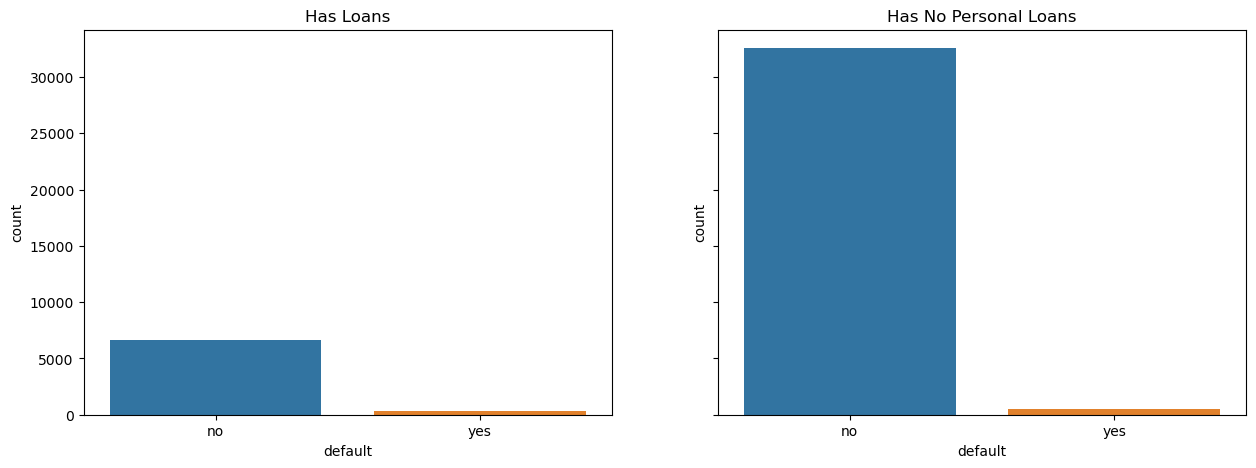

In [83]:
fig, axes = plt.subplots(1, 2, sharey = True, figsize = (15,5))
sns.countplot(x='default', data = has_personal_loan, ax=axes[0])
axes[0].set_title('Has Loans')
sns.countplot(x='default', data = has_no_loan, ax = axes[1])
axes[1].set_title('Has No Personal Loans')
plt.show();


## Marketing Strategies
We can finally explore features such as communication type, the last day and month of contact, duration of last contact, and number of times contacted during the last campaign to see if there are strategies that have yielded a higher number of subscriptions for term deposits. 

### Communication Type

Type of Data: categorical

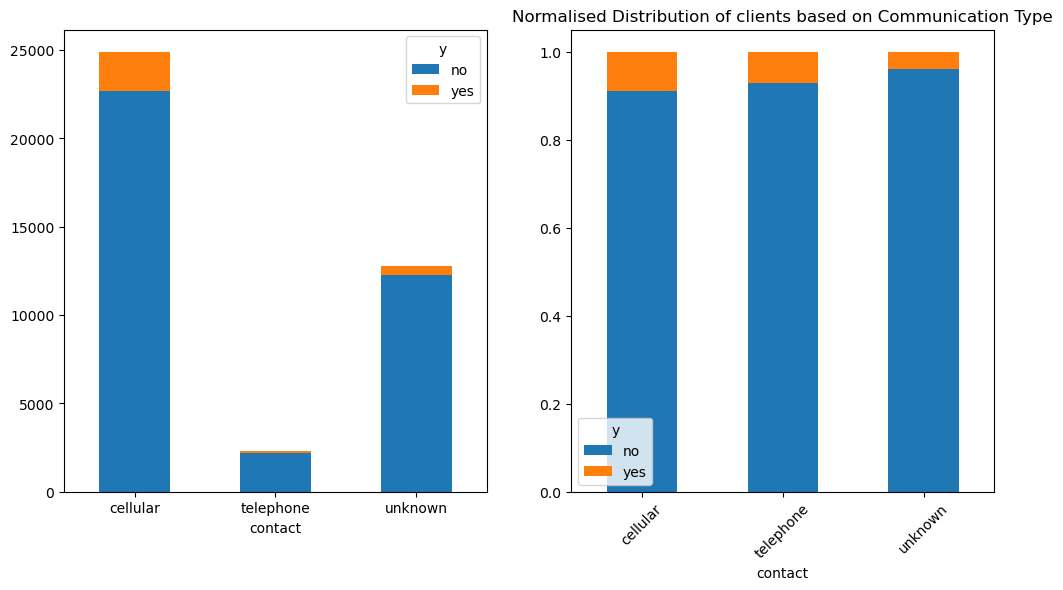

In [84]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (12,6))
pd.crosstab(data['contact'], data['y']).plot(kind='bar', stacked=True,rot=0, ax= axes[0])
data.groupby('contact')['y'].value_counts(normalize = True).unstack('y').plot.bar(rot = 45, stacked=True, ax = axes[1], 
                                                                                 title = 'Normalised Distribution of clients based on Communication Type')
plt.show();

In [85]:
cellular = data[data['contact']=='cellular']
tel_contact = data[data['contact']=='telephone']
misc_cont = data[data['contact']=='unknown']

Count of Clients by communication style who subscribed for term deposits: 
 cellular     77.106354
unknown      17.161602
telephone     5.732044
Name: contact, dtype: float64


Count of Clients by communication style who didn't subscribe for term deposits: 
 cellular     61.128180
unknown      33.063821
telephone     5.807999
Name: contact, dtype: float64


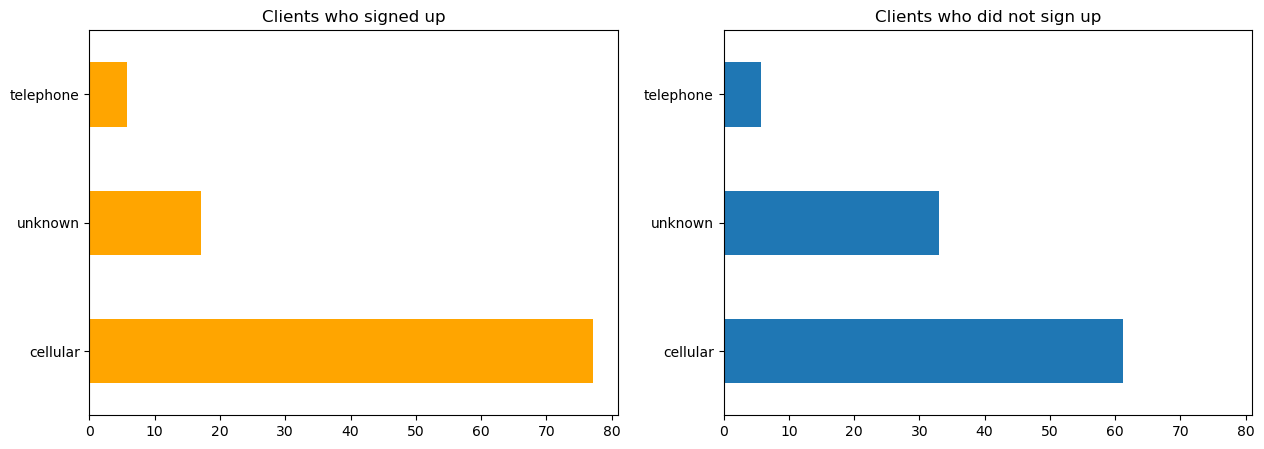

In [86]:
print("Count of Clients by communication style who subscribed for term deposits: \n",
      (data[data['y']=='yes']['contact'].value_counts()/len(data[data['y']=='yes']['contact']))*100)
print('\n')
print("Count of Clients by communication style who didn't subscribe for term deposits: \n",
      (data[data['y']=='no']['contact'].value_counts()/len(data[data['y']=='no']['contact']))*100)
fig, axes = plt.subplots(1, 2, sharex = True, figsize = (15,5))
((data[data['y']=='yes']['contact'].value_counts()/len(data[data['y']=='yes']['contact']))*100).plot(ax=axes[0],kind='barh', color = 'orange', 
                                                                                             title = 'Clients who signed up' )
((data[data['y']=='no']['contact'].value_counts()/len(data[data['y']=='no']['contact']))*100).plot(kind='barh', ax= axes[1], 
                                                                                          title = 'Clients who did not sign up')
plt.show();

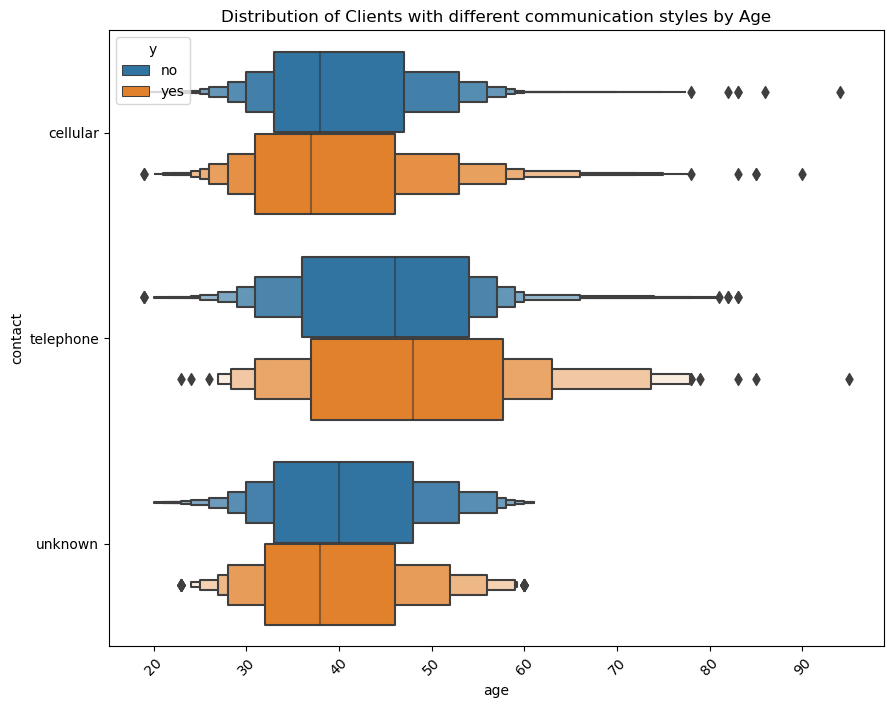

In [87]:
plt.figure(figsize=(10,8))
sns.boxenplot(x='age', y='contact', data = data, hue = 'y')
plt.xticks(rotation = 45)
plt.title('Distribution of Clients with different communication styles by Age')
plt.show();

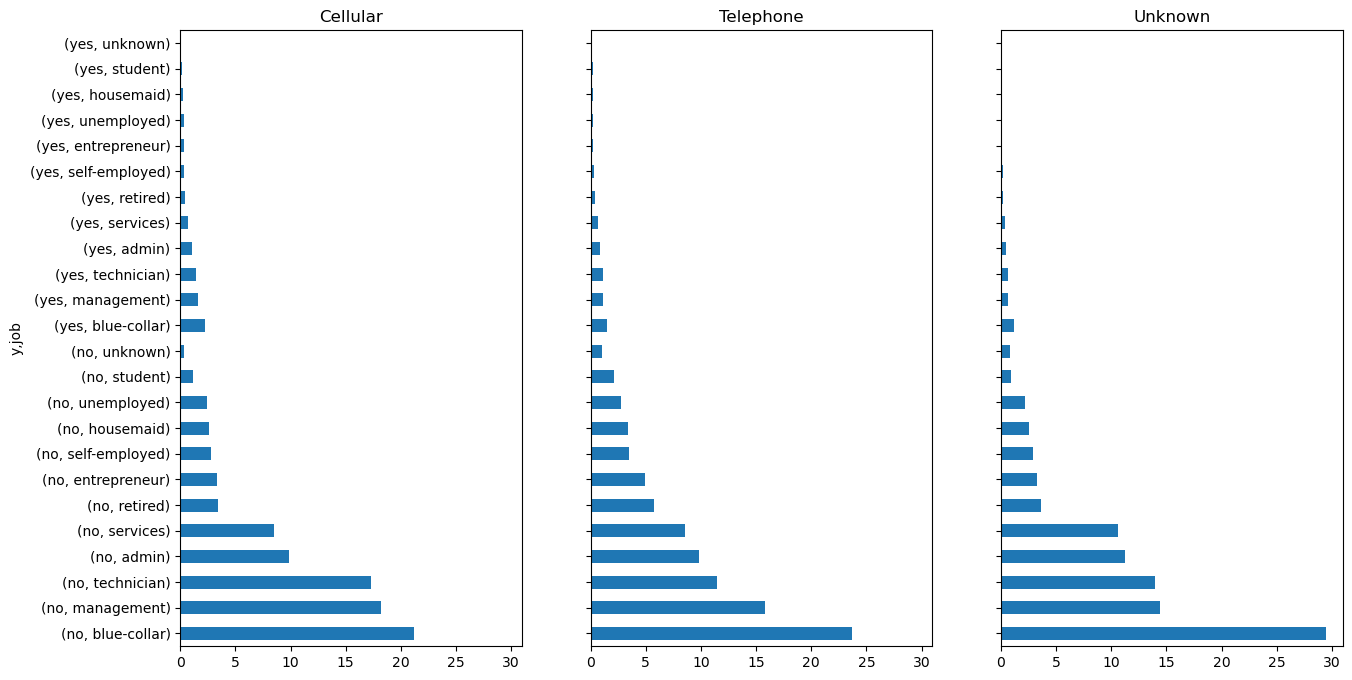

In [88]:
fig, axes = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (15,8))

(cellular.groupby('y')['job'].value_counts()/len(cellular)*100).plot(kind='barh', ax=axes[0],
                                                                            title = 'Cellular')

(tel_contact.groupby('y')['job'].value_counts()/len(tel_contact)*100).plot(kind='barh', ax = axes[1], 
                                                                      title = 'Telephone')

(misc_cont.groupby('y')['job'].value_counts()/len(misc_cont)*100).plot(kind='barh', ax = axes[2], 
                                                                      title = 'Unknown')
plt.show();


Similar distributions however we can see that celluar contact has a higher frequency amongst the clients who signed up for subsciptions. 

### Last Day of Contact of the Month

Type of Data: numeric

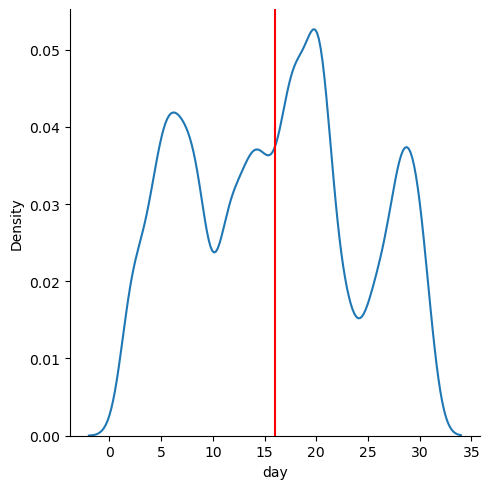

In [89]:
sns.displot(data['day'], kind='kde')
plt.axvline(np.mean(data['day']), c='red')
plt.show();

In [90]:
print("Day's of the month by freqeuncy:\n", data['day'].value_counts()/len(data)*100)

Day's of the month by freqeuncy:
 20    6.6375
18    5.4325
21    4.7850
17    4.5300
6     4.4450
5     4.2275
28    4.1250
19    4.1250
14    4.0900
8     4.0500
7     4.0300
29    4.0000
15    3.6700
30    3.6425
9     3.4350
13    3.3125
12    3.2225
11    3.1800
16    3.0375
4     2.9575
2     2.7725
27    2.4350
26    2.2375
3     2.1850
23    2.0575
22    1.9325
25    1.7375
31    1.4775
10    0.9100
24    0.8800
1     0.4400
Name: day, dtype: float64


The distribution looks multimodal.

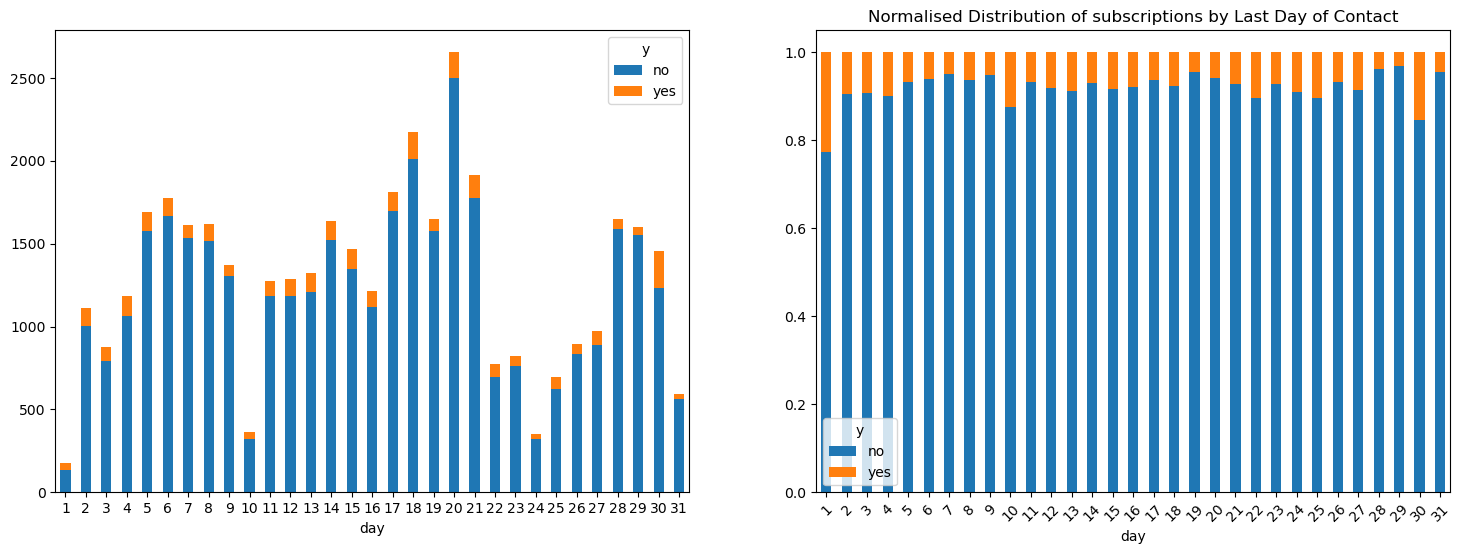

In [91]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (18,6))

pd.crosstab(data['day'], data['y']).plot(kind='bar', stacked=True, ax=axes[0], rot=0)
data.groupby('day')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 45,
                                                                             title = 'Normalised Distribution of subscriptions by Last Day of Contact')
plt.show();

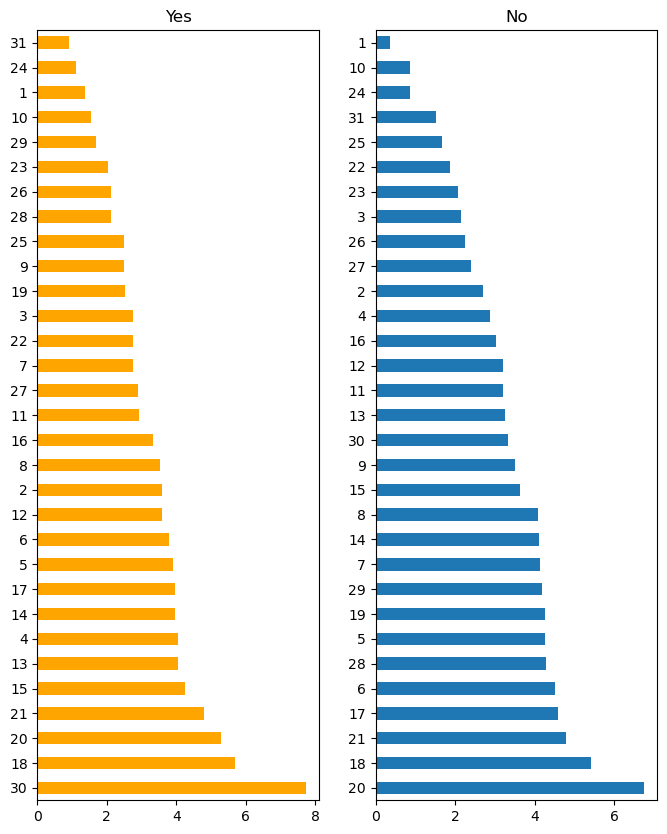

In [92]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (8, 10))
(data[data['y']=='yes']['day'].value_counts()/len(data[data['y']=='yes'])*100).plot(ax = axes[0], kind='barh', color = 'orange',
                                                                                   title = 'Yes')
(data[data['y']=='no']['day'].value_counts()/len(data[data['y']=='no'])*100).plot(ax = axes[1], kind='barh', title = 'No')
plt.show();

### Last Contact Month of the Year

Type of Data: Categorical

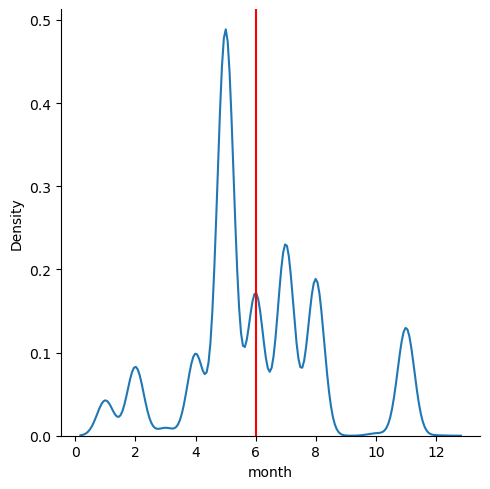

In [93]:
sns.displot(data['month'], kind='kde')
plt.axvline(np.mean(data['month']), c='red')
plt.show();

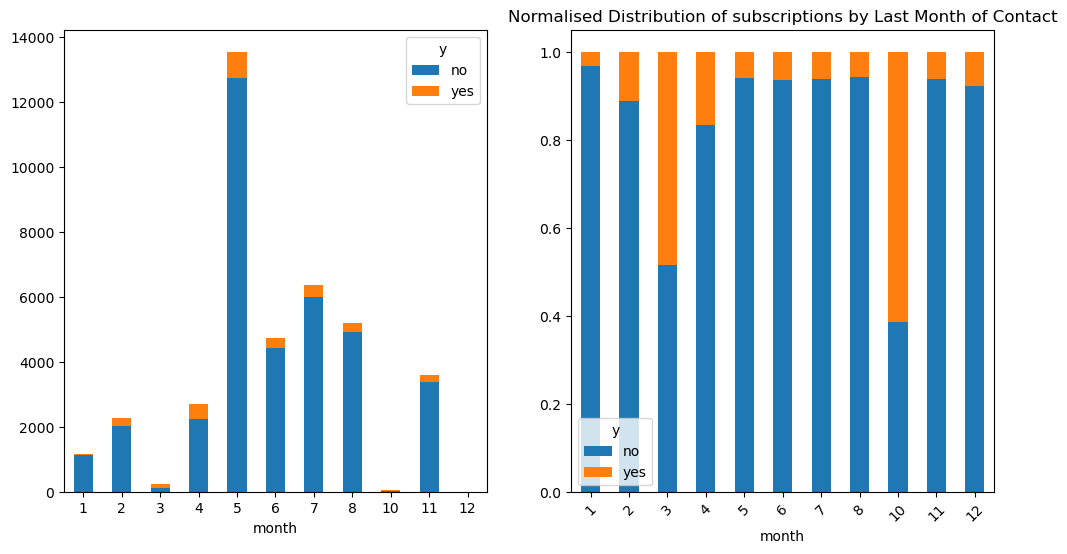

In [94]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (12,6))

pd.crosstab(data['month'], data['y']).plot(kind='bar', stacked=True, ax=axes[0], rot=0)
data.groupby('month')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 45,
                                                                             title = 'Normalised Distribution of subscriptions by Last Month of Contact')
plt.show();

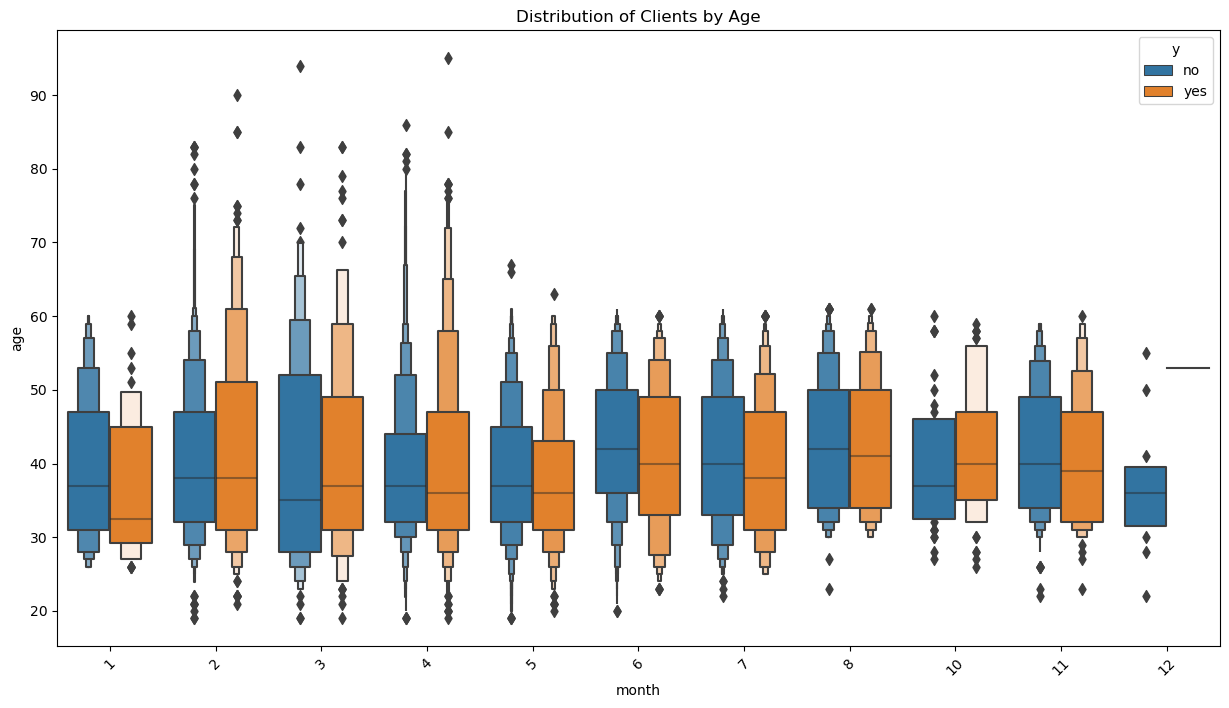

In [95]:
plt.figure(figsize=(15,8))
sns.boxenplot(y='age', x='month', data = data, hue = 'y')
plt.xticks(rotation = 45)
plt.title('Distribution of Clients by Age')
plt.show();

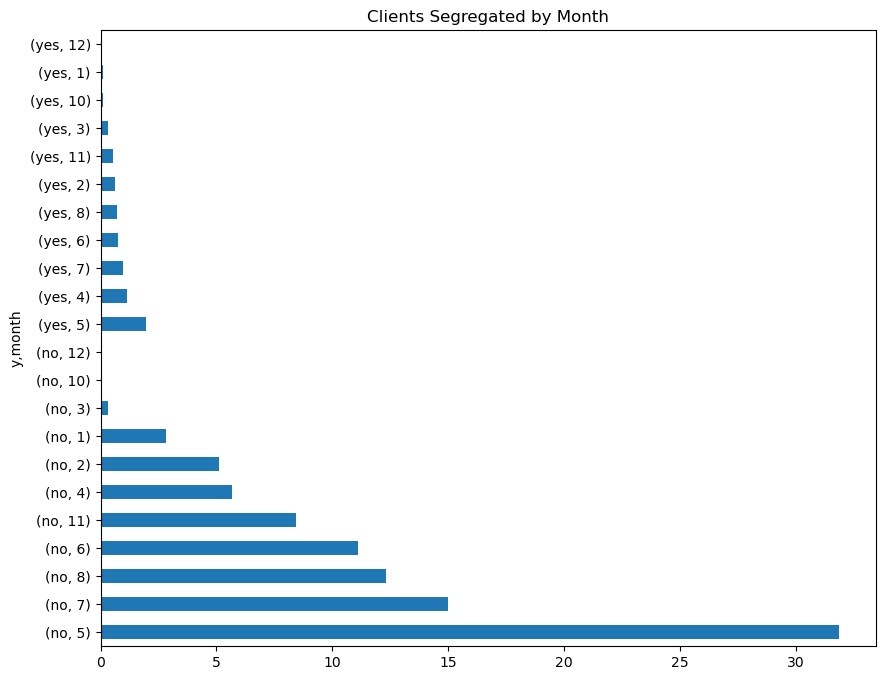

In [96]:
plt.figure(figsize = (10,8))
(data.groupby('y')['month'].value_counts()/len(data)*100).plot(kind='barh', title = 'Clients Segregated by Month')
plt.show();

We see that the highest number of customers who subscribed and those who didn't subscribe for term deposits all occured during the month of May. This is most likely due to there being a higher frequency of customers in may. This further supports the idea we should look at months of March and October as the months of higher subscription rates. 

### Duration of the Last Contact (Seconds)

Type of Data: Numeric

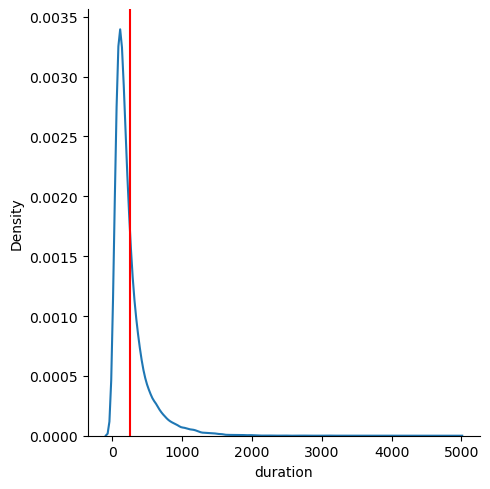

In [97]:
sns.displot(data['duration'], kind='kde')
plt.axvline(np.mean(data['duration']), c='red')
plt.show();

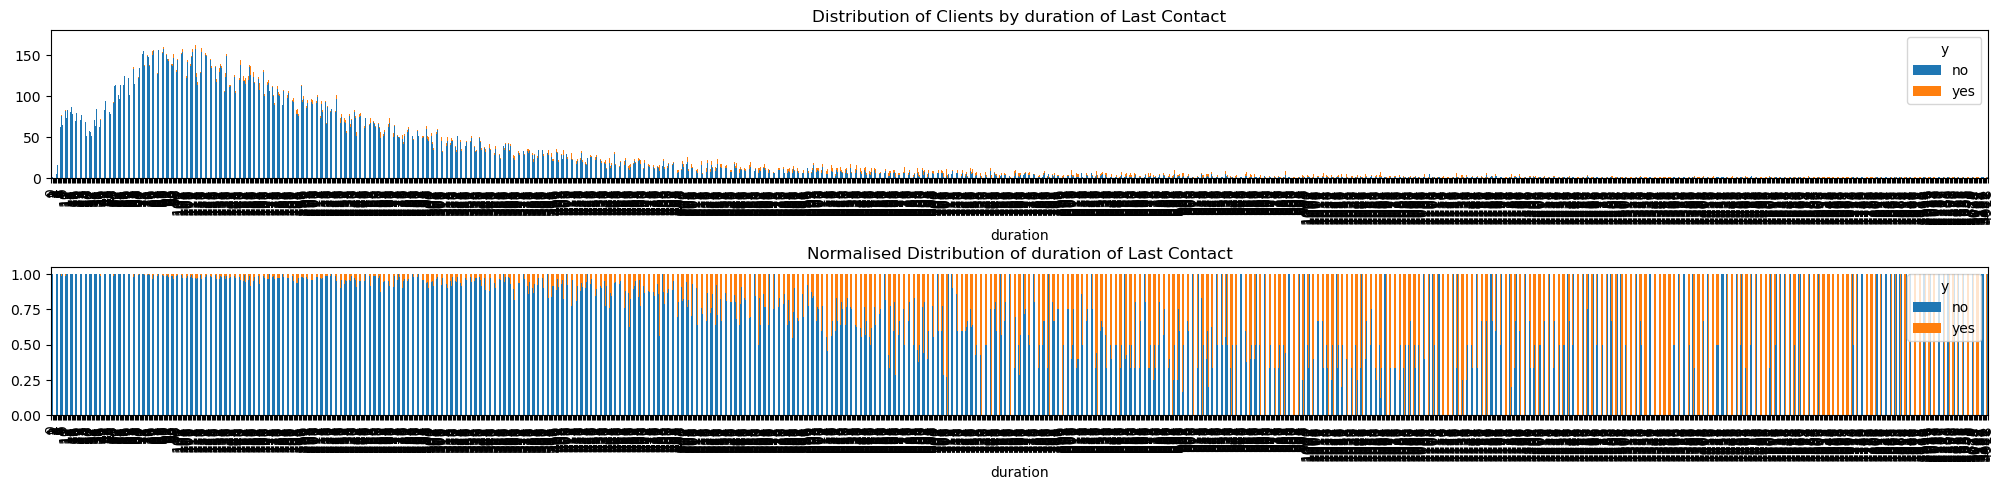

In [98]:
fig, axes = plt.subplots(nrows=2, ncols = 1, figsize = (25,5))
pd.crosstab(data['duration'], data['y']).plot(kind='bar', stacked=True, rot=90, ax = axes[0], 
                                         title = 'Distribution of Clients by duration of Last Contact')
data.groupby('duration')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 90,
                                                                             title = 'Normalised Distribution of duration of Last Contact')
plt.subplots_adjust(wspace=0.6, hspace=0.6)
plt.show();

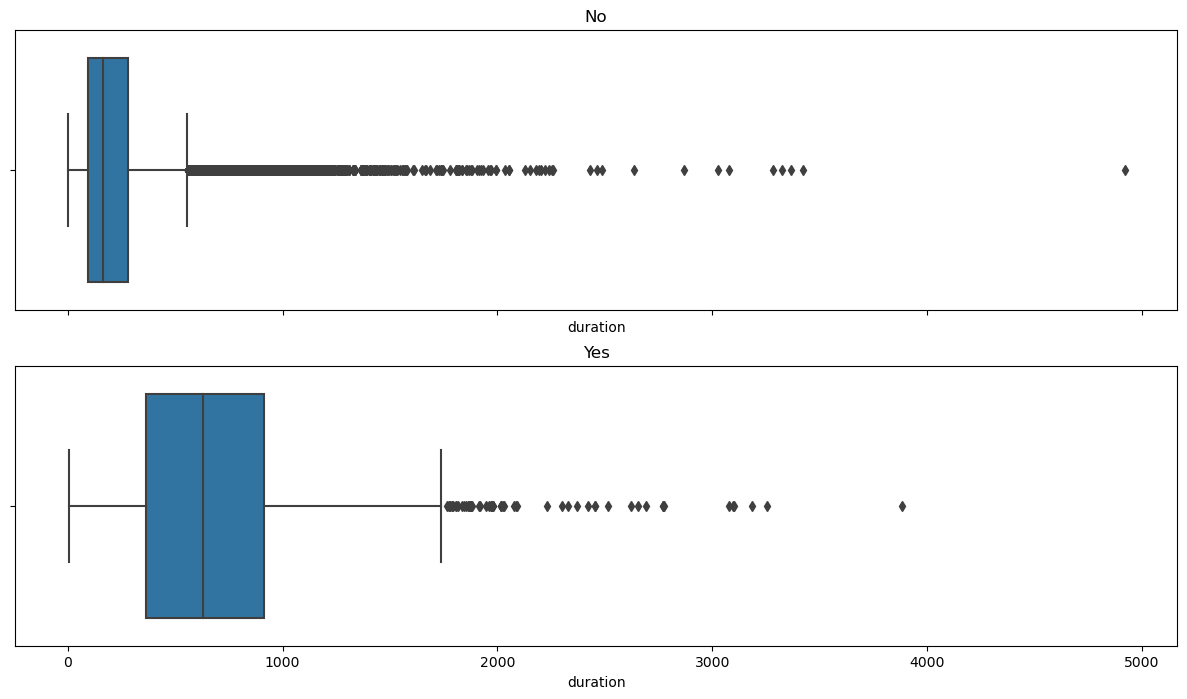

In [99]:
fig, axes = plt.subplots(2, 1, sharex = True, sharey = True, figsize = (15,8))
sns.boxplot(x='duration', data = data[data['y']=='no'], ax = axes[0])
axes[0].set_title('No')
sns.boxplot(x='duration', data = data[data['y']=='yes'], ax = axes[1] )
axes[1].set_title('Yes')
plt.show();

In [100]:
np.min(data[data['y']=='no']['duration'])

0

In [101]:
zero_duration = data[data['duration']==0]

In [102]:
zero_duration['y'].nunique()

1

In [103]:
np.max(data[data['y']=='no']['duration'])

4918

In [104]:
np.min(data[data['y']=='yes']['duration'])

8

In [105]:
np.max(data[data['y']=='yes']['duration'])

3881

<AxesSubplot:xlabel='balance', ylabel='duration'>

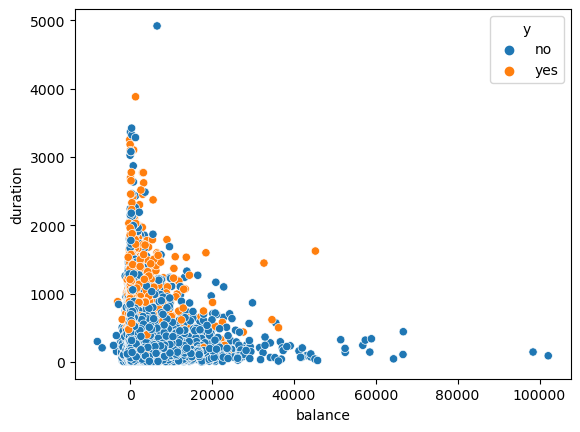

In [106]:
sns.scatterplot(x='balance', y='duration', data = data, hue = 'y')

### Number of Contacts for each client for this campaign

(note: this includes the last contact)

Type of Data: Numeric

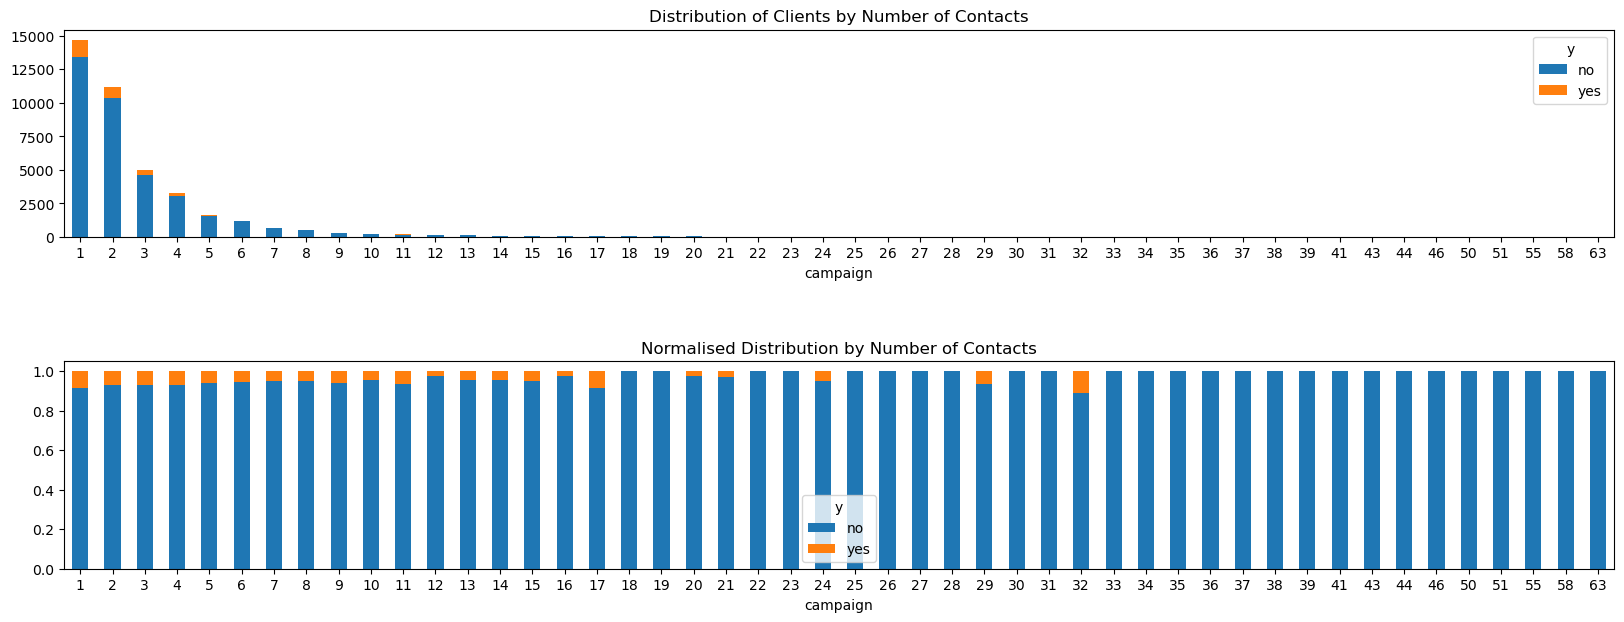

In [107]:
fig, axes = plt.subplots(nrows=2, ncols = 1, figsize = (20,7))
pd.crosstab(data['campaign'], data['y']).plot(kind='bar', stacked=True, rot=0, ax = axes[0], 
                                         title = 'Distribution of Clients by Number of Contacts')
data.groupby('campaign')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 0,
                                                                             title = 'Normalised Distribution by Number of Contacts')
plt.subplots_adjust(wspace=0.6, hspace=0.6)
plt.show();

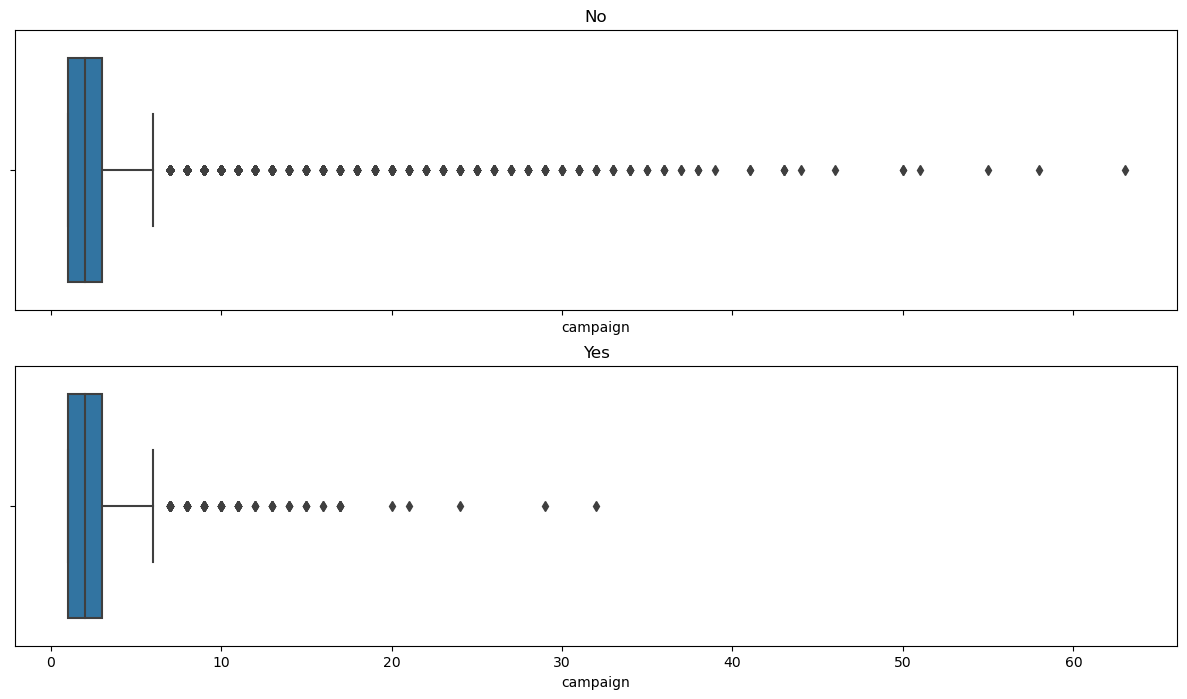

In [108]:
fig, axes = plt.subplots(2, 1, sharex = True, sharey = True, figsize = (15,8))
sns.boxplot(x='campaign', data = data[data['y']=='no'], ax = axes[0])
axes[0].set_title('No')
sns.boxplot(x='campaign', data = data[data['y']=='yes'], ax = axes[1] )
axes[1].set_title('Yes')
plt.show();


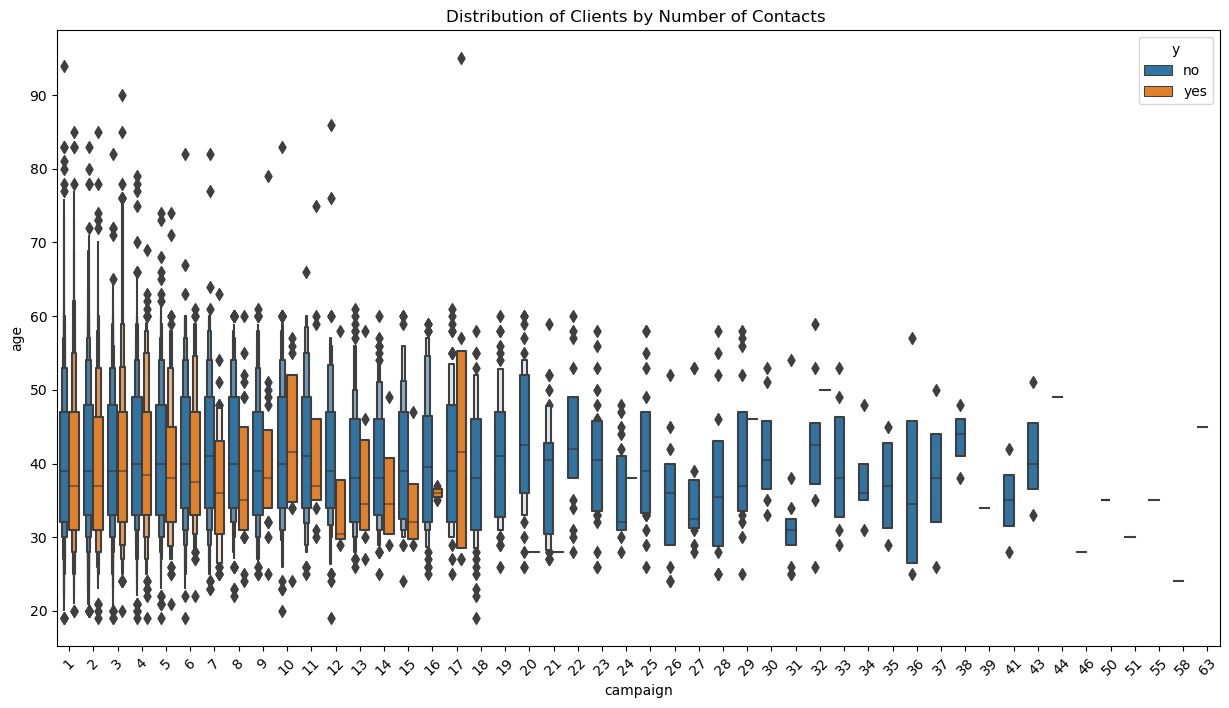

In [109]:
plt.figure(figsize=(15,8))
sns.boxenplot(y='age', x='campaign', data = data, hue = 'y')
plt.xticks(rotation = 45)
plt.title('Distribution of Clients by Number of Contacts ')
plt.show();

In [110]:
data[data['campaign']==17]['y'].nunique()

2

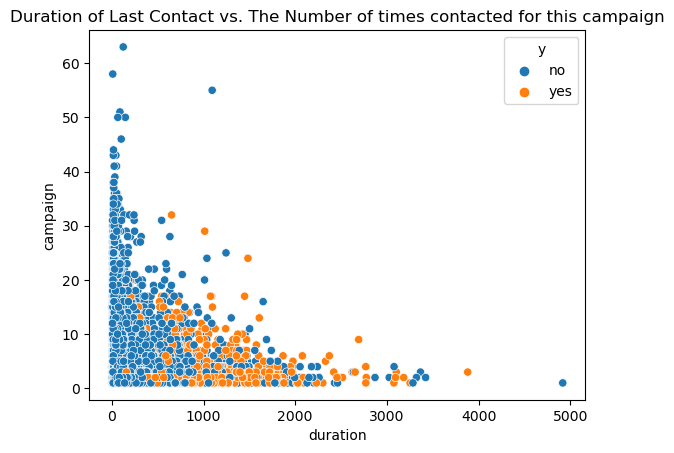

In [111]:
sns.scatterplot(x='duration', y='campaign', data = data, hue = 'y')
plt.title('Duration of Last Contact vs. The Number of times contacted for this campaign')
plt.show()

### Correlation

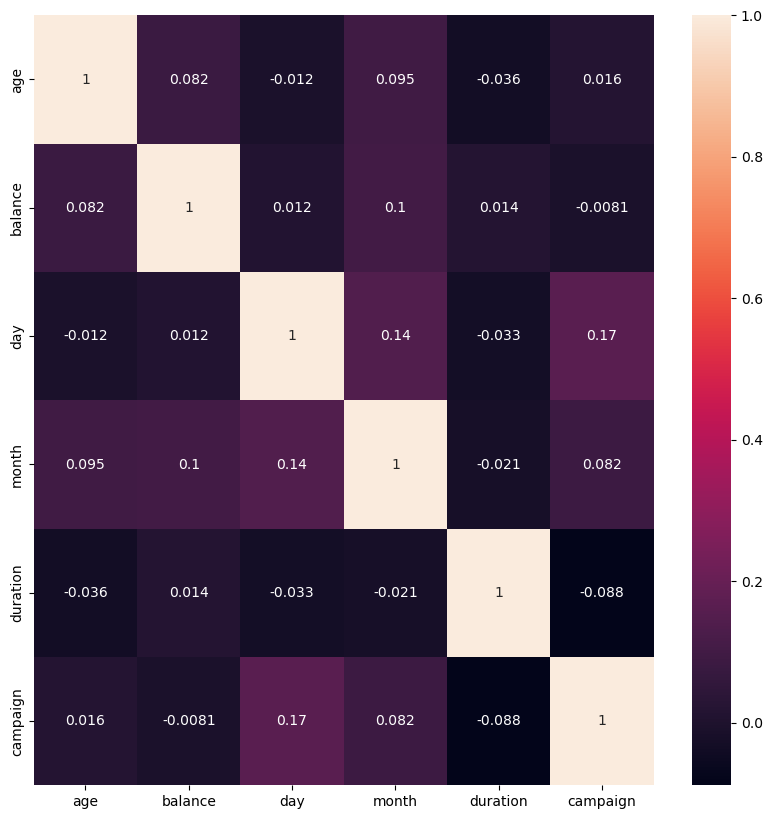

In [112]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot=True)
plt.show();

In [113]:
data_og = data

In [114]:
data_og

age          job  marital  education default  balance housing loan  \
20749   38   technician  married   tertiary      no      128      no   no   
22532   34   management   single  secondary      no        0      no   no   
16174   34   management   single   tertiary      no      184      no   no   
36796   31   technician   single  secondary      no        1     yes   no   
12882   47   technician   single  secondary      no     -239     yes  yes   
...    ...          ...      ...        ...     ...      ...     ...  ...   
17987   41   management   single   tertiary      no     1373      no   no   
28360   28  blue-collar  married  secondary      no      255     yes   no   
24250   45   technician  married  secondary      no     1477     yes   no   
28182   60   technician  married  secondary      no      478      no   no   
37990   30  blue-collar  married  secondary      no      378     yes   no   

        contact  day  month  duration  campaign    y  
20749  cellular   13      8       183         5   no  
22532  cellular   22      8       132         4   no  
16174  cellular   22      7       203         4   no  
36796  cellular   12      5       223         1   no  
12882  cellular    7      7       973         3  yes  
...         ...  ...    ...       ...       ...  ...  
17987  cellular   30      7        81         2   no  
28360  cellular   29      1       602         2   no  
24250  cellular   17     11        75         1   no  
28182  cellular   29      1       139         1   no  
37990  cellular   14      5       566         2  yes  

[40000 rows x 14 columns]

# Feature Engineering 

### Categorical Data

Categorical Features: job, marital, education, default, housing, loan, contact,y

In [115]:
label_encoding = LabelEncoder()
data['job'] = label_encoding.fit_transform(data['job'])
data['marital'] = label_encoding.fit_transform(data['marital'])
data['education'] = label_encoding.fit_transform(data['education'])
data['default'] = label_encoding.fit_transform(data['default'])
data['housing'] = label_encoding.fit_transform(data['housing'])
data['loan'] = label_encoding.fit_transform(data['loan'])
data['contact'] = label_encoding.fit_transform(data['contact'])
data['y'] = label_encoding.fit_transform(data['y'])

In [116]:
data.head()

age  job  marital  education  default  balance  housing  loan  contact  \
20749   38    9        1          2        0      128        0     0        0   
22532   34    4        2          1        0        0        0     0        0   
16174   34    4        2          2        0      184        0     0        0   
36796   31    9        2          1        0        1        1     0        0   
12882   47    9        2          1        0     -239        1     1        0   

       day  month  duration  campaign  y  
20749   13      8       183         5  0  
22532   22      8       132         4  0  
16174   22      7       203         4  0  
36796   12      5       223         1  0  
12882    7      7       973         3  1

### Numerical Data 

SCALING: robust vs standard scaler

* robust uses IQR so would be less influenced by outliers


Numerical Features: age, day, month, duration

In [117]:
from sklearn.preprocessing import RobustScaler
data_robust = data

In [118]:
rs = RobustScaler()
rs_data = rs.fit_transform(data_robust)
rs_data = pd.DataFrame(rs_data)
rs_data.columns = data.columns
rs_data.head()

age       job  marital  education  default   balance  housing  loan  \
0 -0.066667  0.833333      0.0        1.0      0.0 -0.220553     -1.0   0.0   
1 -0.333333  0.000000      1.0        0.0      0.0 -0.321739     -1.0   0.0   
2 -0.333333  0.000000      1.0        1.0      0.0 -0.176285     -1.0   0.0   
3 -0.533333  0.833333      1.0        0.0      0.0 -0.320949      0.0   0.0   
4  0.533333  0.833333      1.0        0.0      0.0 -0.510672      0.0   1.0   

   contact       day  month  duration  campaign    y  
0      0.0 -0.307692    1.0  0.037559       1.5  0.0  
1      0.0  0.384615    1.0 -0.201878       1.0  0.0  
2      0.0  0.384615    0.5  0.131455       1.0  0.0  
3      0.0 -0.384615   -0.5  0.225352      -0.5  0.0  
4      0.0 -0.769231    0.5  3.746479       0.5  1.0

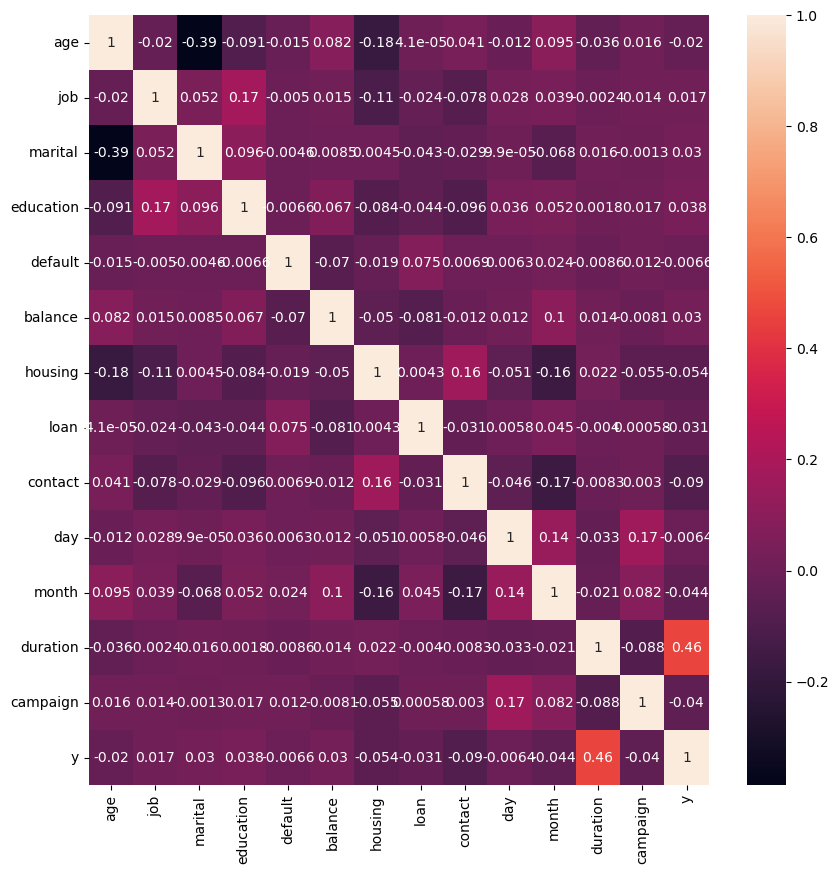

In [119]:
plt.figure(figsize=(10,10))
sns.heatmap(rs_data.corr(), annot=True)
plt.show();

In [120]:
from sklearn.preprocessing import StandardScaler

In [121]:
data_standard = data

In [122]:
ss = StandardScaler()
ss_data = ss.fit_transform(data_standard)
ss_data = pd.DataFrame(ss_data)
ss_data.columns = data.columns
ss_data.head()

age       job   marital  education   default   balance   housing  \
0 -0.263917  1.438371 -0.254510   1.078768 -0.143675 -0.394760 -1.226725   
1 -0.678784 -0.080837  1.397079  -0.269608 -0.143675 -0.438841 -1.226725   
2 -0.678784 -0.080837  1.397079   1.078768 -0.143675 -0.375474 -1.226725   
3 -0.989934  1.438371  1.397079  -0.269608 -0.143675 -0.438497  0.815179   
4  0.669532  1.438371  1.397079  -0.269608 -0.143675 -0.521149  0.815179   

       loan   contact       day     month  duration  campaign         y  
0 -0.457772 -0.755338 -0.364486  0.864904 -0.276926  0.653849 -0.279376  
1 -0.457772 -0.755338  0.722730  0.864904 -0.473561  0.345113 -0.279376  
2 -0.457772 -0.755338  0.722730  0.430322 -0.199814  0.345113 -0.279376  
3 -0.457772 -0.755338 -0.485288 -0.438840 -0.122702 -0.581096 -0.279376  
4  2.184492 -0.755338 -1.089297  0.430322  2.768996  0.036377  3.579407

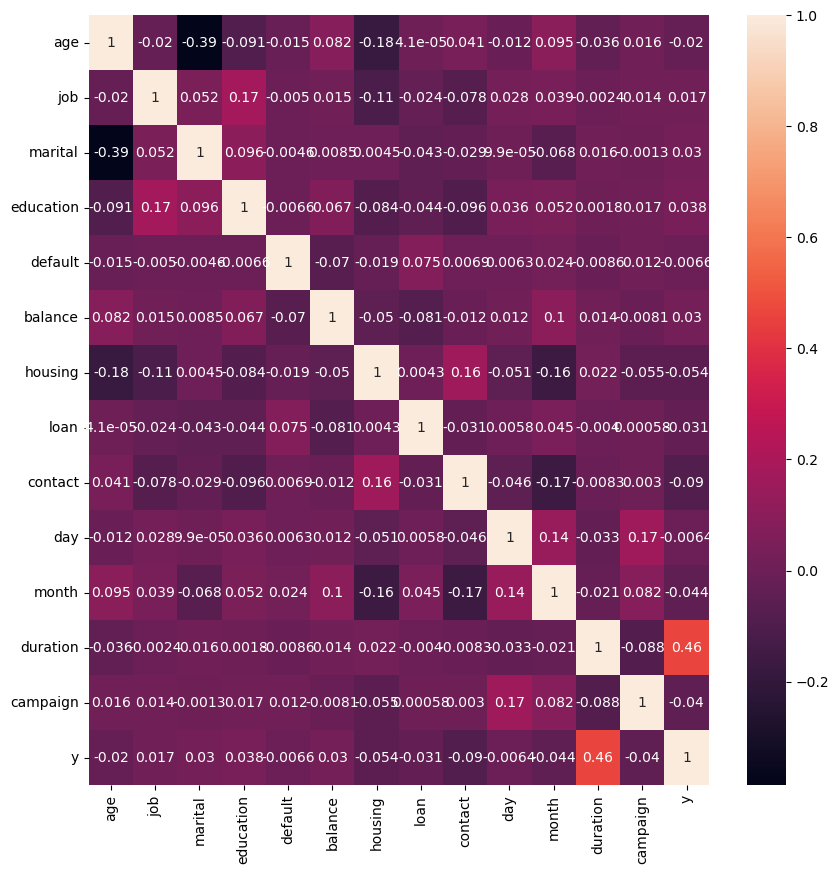

In [123]:
plt.figure(figsize=(10,10))
sns.heatmap(ss_data.corr(), annot=True)
plt.show();

# Train Test Split

In [124]:
X = data.drop('y', axis = 1)
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state = 10)

In [125]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(32000, 13) (32000,)
(8000, 13) (8000,)


In [126]:
print('Percentage of dataset in Class 0: ', data[data['y'] == 0].shape[0]/len(data)*100)
print('Percentage of dataset in Class 1: ', data[data['y'] == 1].shape[0]/len(data)*100)

Percentage of dataset in Class 0:  92.75999999999999
Percentage of dataset in Class 1:  7.24


In [127]:
print('Percentage of Class 0 in training set:', np.count_nonzero(y_train == 0)/len(y_train)*100)
print('Percentage of Class 1 in training set:', np.count_nonzero(y_train == 1)/len(y_train)*100)

Percentage of Class 0 in training set: 92.753125
Percentage of Class 1 in training set: 7.246875


In [128]:
print('Percentage of Class 0 in validation set:', np.count_nonzero(y_test == 0)/len(y_test)*100)
print('Percentage of Class 1 in validation set:', np.count_nonzero(y_test == 1)/len(y_test)*100)

Percentage of Class 0 in validation set: 92.7875
Percentage of Class 1 in validation set: 7.2124999999999995


### Scaled Data

In [129]:
X_rs = rs_data.drop('y', axis = 1)
y_rs = rs_data['y']

X_rs_train, X_rs_test, y_rs_train, y_rs_test = train_test_split(X_rs.values, y_rs.values, test_size = 0.2, random_state = 10)

In [130]:
X_ss = ss_data.drop('y', axis = 1)
y_ss = ss_data['y']

X_ss_train, X_ss_test, y_ss_train, y_ss_test = train_test_split(X_ss.values, y_ss.values, test_size = 0.2, random_state = 10)

# Classification Models 

1st attempt without scaling or stratefied sampling

## K Nearest Neighbors Classifier

In [131]:
base_knn = KNeighborsClassifier()
base_knn.fit(X_train, y_train)
y_pred = base_knn.predict(X_test)
training_score = base_knn.fit(X_train, y_train).score(X_train, y_train)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))
print('Micro F1 Score: ', f1_score(y_test, y_pred, average = 'micro'))

C:\Users\ibane\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\ibane\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



Accuracy Score:  0.9265
Training Set Score:  0.94271875
Macro F1 Score:  0.6524099576271187
Weighted F1 Score:  0.9165457163665254
Micro F1 Score:  0.9265


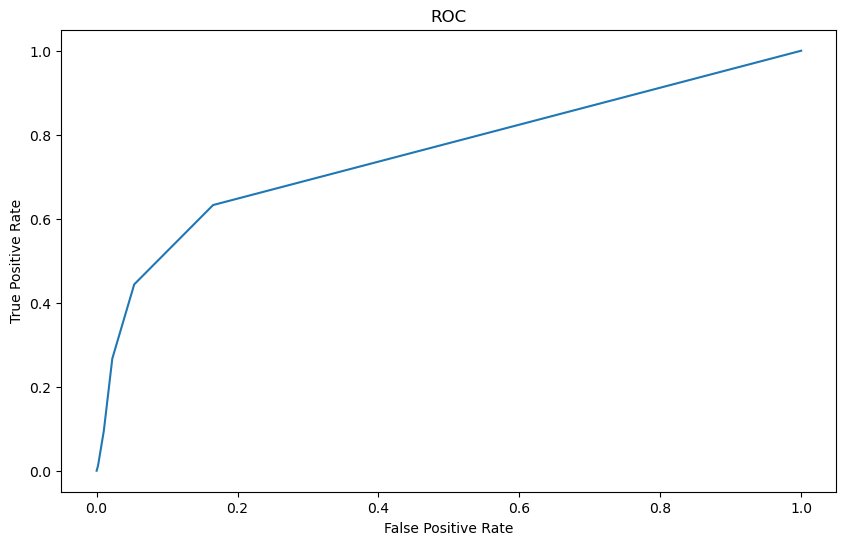

Area Under Curve:  0.7552852847874808


In [132]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = base_knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)

In [133]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      7423
           1       0.48      0.27      0.34       577

    accuracy                           0.93      8000
   macro avg       0.71      0.62      0.65      8000
weighted avg       0.91      0.93      0.92      8000



Using Scaled Dataset

In [134]:
rs_scaled_knn = KNeighborsClassifier()
rs_scaled_knn.fit(X_rs_train, y_rs_train)
y_pred = rs_scaled_knn.predict(X_test)
training_score = rs_scaled_knn.fit(X_rs_train, y_rs_train).score(X_rs_train, y_rs_train)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))

C:\Users\ibane\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\ibane\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



Accuracy Score:  0.91825
Training Set Score:  0.94975
Macro F1 Score:  0.4786915157044181
Weighted F1 Score:  0.8883317802684738


references: https://iopscience.iop.org/article/10.1088/1757-899X/719/1/012072/pdf

## Random Forest

In [135]:
base_rfc = RandomForestClassifier(random_state=10)
base_rfc.fit(X_train, y_train)
y_pred = base_rfc.predict(X_test)
training_score = base_rfc.fit(X_train, y_train).score(X_train, y_train)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))

Accuracy Score:  0.935875
Training Set Score:  0.9999375
Macro F1 Score:  0.700204925711964
Weighted F1 Score:  0.927668245686008


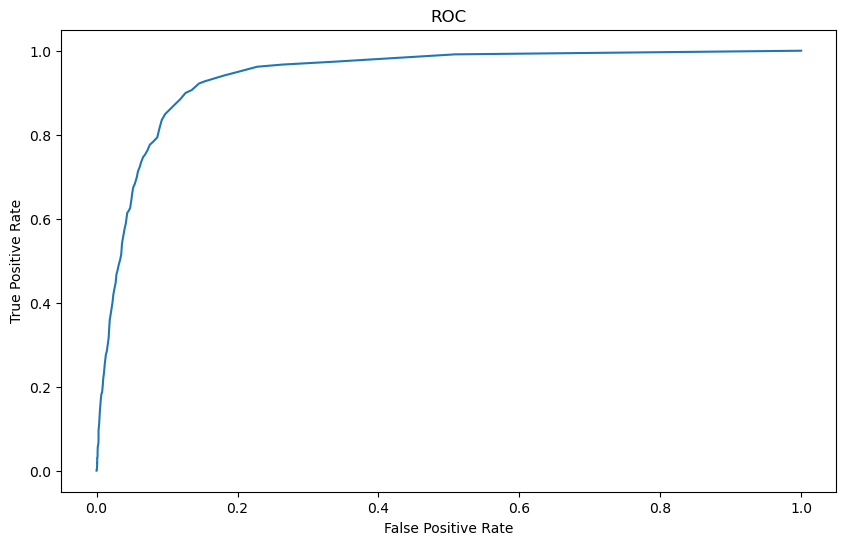

Area Under Curve:  0.940129874102017


In [136]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = base_rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)

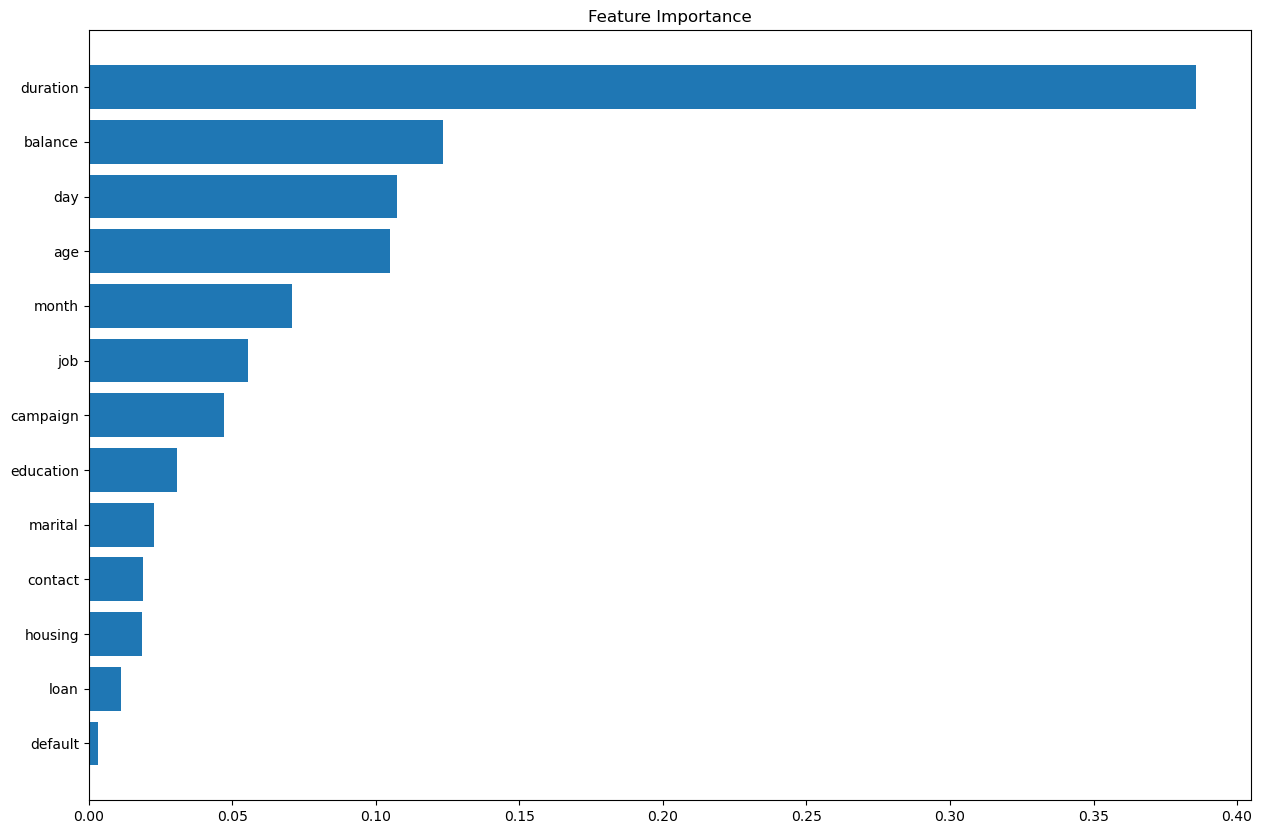

In [137]:
sorted_importances = base_rfc.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], base_rfc.feature_importances_[sorted_importances])
_ = plt.title('Feature Importance')
_ = plt.savefig('feature_imp_grid.png', bbox_inches='tight')
plt.show()

## AdaBoosting 

Accuracy Score:  0.91875
Training Set Score:  1.0
Macro F1 Score:  0.6988842038359373
Weighted F1 Score:  0.9190716293097778


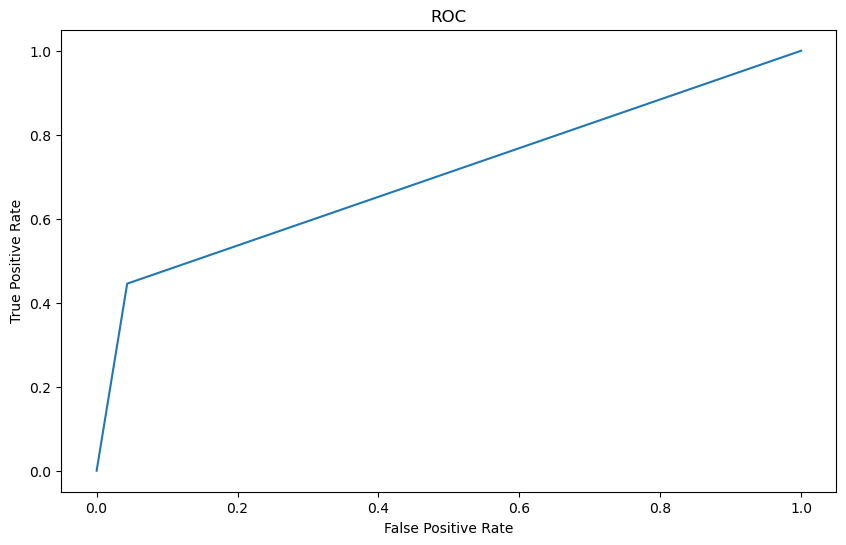

Area Under Curve:  0.7010142955837062


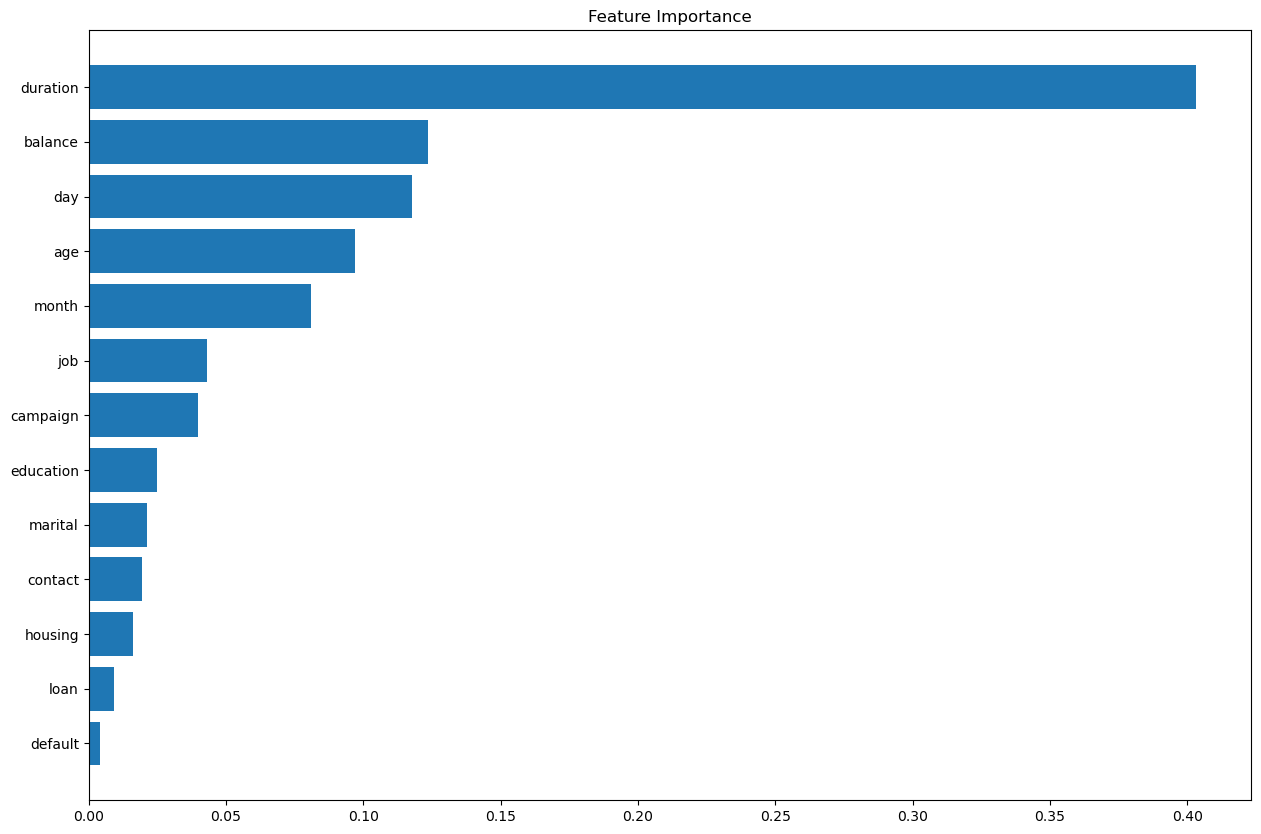

In [138]:
base_estimator = DecisionTreeClassifier(random_state=10)
base_adaboost = AdaBoostClassifier(base_estimator = base_estimator)
base_adaboost.fit(X_train, y_train)
y_pred = base_adaboost.predict(X_test)
training_score = base_adaboost.fit(X_train, y_train).score(X_train, y_train)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = base_adaboost.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)
sorted_importances = base_adaboost.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], base_adaboost.feature_importances_[sorted_importances])
_ = plt.title('Feature Importance')
_ = plt.savefig('feature_imp_grid.png', bbox_inches='tight')
plt.show()

## CatBoost

In [139]:
base_cb = CatBoostClassifier(random_state=10)
base_cb.fit(X_train, y_train)
y_pred = base_cb.predict(X_test)
training_score = base_cb.fit(X_train, y_train).score(X_train, y_train)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))

Learning rate set to 0.045252
0:	learn: 0.6305162	total: 94.4ms	remaining: 1m 34s
1:	learn: 0.5669482	total: 131ms	remaining: 1m 5s
2:	learn: 0.5204128	total: 166ms	remaining: 55s
3:	learn: 0.4766698	total: 196ms	remaining: 48.7s
4:	learn: 0.4371018	total: 230ms	remaining: 45.7s
5:	learn: 0.4038742	total: 264ms	remaining: 43.7s
6:	learn: 0.3740625	total: 295ms	remaining: 41.8s
7:	learn: 0.3521642	total: 328ms	remaining: 40.7s
8:	learn: 0.3301510	total: 359ms	remaining: 39.5s
9:	learn: 0.3087199	total: 390ms	remaining: 38.6s
10:	learn: 0.2928337	total: 420ms	remaining: 37.7s
11:	learn: 0.2798553	total: 447ms	remaining: 36.8s
12:	learn: 0.2674061	total: 474ms	remaining: 36s
13:	learn: 0.2571287	total: 502ms	remaining: 35.4s
14:	learn: 0.2435190	total: 532ms	remaining: 34.9s
15:	learn: 0.2341247	total: 559ms	remaining: 34.4s
16:	learn: 0.2255588	total: 588ms	remaining: 34s
17:	learn: 0.2194240	total: 618ms	remaining: 33.7s
18:	learn: 0.2100301	total: 653ms	remaining: 33.7s
19:	learn: 0.20

167:	learn: 0.1287109	total: 5.87s	remaining: 29.1s
168:	learn: 0.1286083	total: 5.9s	remaining: 29s
169:	learn: 0.1285293	total: 5.93s	remaining: 28.9s
170:	learn: 0.1284550	total: 5.96s	remaining: 28.9s
171:	learn: 0.1284155	total: 5.98s	remaining: 28.8s
172:	learn: 0.1283437	total: 6.01s	remaining: 28.7s
173:	learn: 0.1281473	total: 6.08s	remaining: 28.8s
174:	learn: 0.1280711	total: 6.11s	remaining: 28.8s
175:	learn: 0.1279830	total: 6.14s	remaining: 28.8s
176:	learn: 0.1278637	total: 6.17s	remaining: 28.7s
177:	learn: 0.1277766	total: 6.2s	remaining: 28.6s
178:	learn: 0.1276807	total: 6.25s	remaining: 28.7s
179:	learn: 0.1275720	total: 6.34s	remaining: 28.9s
180:	learn: 0.1274728	total: 6.43s	remaining: 29.1s
181:	learn: 0.1273712	total: 6.49s	remaining: 29.2s
182:	learn: 0.1272788	total: 6.57s	remaining: 29.3s
183:	learn: 0.1272085	total: 6.63s	remaining: 29.4s
184:	learn: 0.1270950	total: 6.68s	remaining: 29.4s
185:	learn: 0.1270077	total: 6.73s	remaining: 29.5s
186:	learn: 0.12

328:	learn: 0.1174322	total: 12.7s	remaining: 25.8s
329:	learn: 0.1173704	total: 12.7s	remaining: 25.8s
330:	learn: 0.1173691	total: 12.7s	remaining: 25.7s
331:	learn: 0.1172954	total: 12.8s	remaining: 25.7s
332:	learn: 0.1172940	total: 12.8s	remaining: 25.7s
333:	learn: 0.1172229	total: 12.9s	remaining: 25.6s
334:	learn: 0.1171532	total: 12.9s	remaining: 25.6s
335:	learn: 0.1170836	total: 12.9s	remaining: 25.5s
336:	learn: 0.1170646	total: 12.9s	remaining: 25.5s
337:	learn: 0.1170324	total: 13.1s	remaining: 25.6s
338:	learn: 0.1170031	total: 13.1s	remaining: 25.6s
339:	learn: 0.1169383	total: 13.2s	remaining: 25.6s
340:	learn: 0.1168548	total: 13.2s	remaining: 25.5s
341:	learn: 0.1168536	total: 13.2s	remaining: 25.5s
342:	learn: 0.1168523	total: 13.3s	remaining: 25.4s
343:	learn: 0.1168067	total: 13.4s	remaining: 25.5s
344:	learn: 0.1167477	total: 13.4s	remaining: 25.4s
345:	learn: 0.1166735	total: 13.4s	remaining: 25.4s
346:	learn: 0.1166691	total: 13.4s	remaining: 25.3s
347:	learn: 

490:	learn: 0.1088543	total: 19.9s	remaining: 20.6s
491:	learn: 0.1087899	total: 19.9s	remaining: 20.6s
492:	learn: 0.1087799	total: 19.9s	remaining: 20.5s
493:	learn: 0.1087479	total: 20s	remaining: 20.5s
494:	learn: 0.1086965	total: 20s	remaining: 20.4s
495:	learn: 0.1086786	total: 20s	remaining: 20.3s
496:	learn: 0.1086344	total: 20s	remaining: 20.3s
497:	learn: 0.1085890	total: 20.1s	remaining: 20.2s
498:	learn: 0.1085654	total: 20.1s	remaining: 20.2s
499:	learn: 0.1085151	total: 20.2s	remaining: 20.2s
500:	learn: 0.1084465	total: 20.2s	remaining: 20.1s
501:	learn: 0.1083993	total: 20.2s	remaining: 20.1s
502:	learn: 0.1083384	total: 20.3s	remaining: 20s
503:	learn: 0.1083100	total: 20.3s	remaining: 20s
504:	learn: 0.1082566	total: 20.3s	remaining: 19.9s
505:	learn: 0.1081922	total: 20.4s	remaining: 19.9s
506:	learn: 0.1081462	total: 20.4s	remaining: 19.8s
507:	learn: 0.1081201	total: 20.4s	remaining: 19.8s
508:	learn: 0.1080587	total: 20.5s	remaining: 19.7s
509:	learn: 0.1080257	to

653:	learn: 0.1021409	total: 27.2s	remaining: 14.4s
654:	learn: 0.1021014	total: 27.2s	remaining: 14.3s
655:	learn: 0.1020606	total: 27.3s	remaining: 14.3s
656:	learn: 0.1020395	total: 27.3s	remaining: 14.2s
657:	learn: 0.1020034	total: 27.3s	remaining: 14.2s
658:	learn: 0.1019289	total: 27.4s	remaining: 14.2s
659:	learn: 0.1019064	total: 27.4s	remaining: 14.1s
660:	learn: 0.1018806	total: 27.5s	remaining: 14.1s
661:	learn: 0.1018400	total: 27.5s	remaining: 14s
662:	learn: 0.1018165	total: 27.6s	remaining: 14s
663:	learn: 0.1017868	total: 27.6s	remaining: 14s
664:	learn: 0.1017377	total: 27.6s	remaining: 13.9s
665:	learn: 0.1016976	total: 27.7s	remaining: 13.9s
666:	learn: 0.1016528	total: 27.7s	remaining: 13.8s
667:	learn: 0.1016228	total: 27.8s	remaining: 13.8s
668:	learn: 0.1015870	total: 27.8s	remaining: 13.8s
669:	learn: 0.1015364	total: 27.8s	remaining: 13.7s
670:	learn: 0.1014922	total: 27.9s	remaining: 13.7s
671:	learn: 0.1014620	total: 27.9s	remaining: 13.6s
672:	learn: 0.1014

814:	learn: 0.0959428	total: 33.9s	remaining: 7.69s
815:	learn: 0.0959198	total: 33.9s	remaining: 7.65s
816:	learn: 0.0958827	total: 34s	remaining: 7.61s
817:	learn: 0.0958430	total: 34s	remaining: 7.56s
818:	learn: 0.0958099	total: 34s	remaining: 7.52s
819:	learn: 0.0957689	total: 34.1s	remaining: 7.48s
820:	learn: 0.0957230	total: 34.1s	remaining: 7.44s
821:	learn: 0.0956775	total: 34.2s	remaining: 7.4s
822:	learn: 0.0956500	total: 34.2s	remaining: 7.36s
823:	learn: 0.0956220	total: 34.2s	remaining: 7.31s
824:	learn: 0.0955724	total: 34.3s	remaining: 7.27s
825:	learn: 0.0955234	total: 34.3s	remaining: 7.22s
826:	learn: 0.0954705	total: 34.3s	remaining: 7.18s
827:	learn: 0.0954297	total: 34.4s	remaining: 7.14s
828:	learn: 0.0953739	total: 34.4s	remaining: 7.1s
829:	learn: 0.0953489	total: 34.5s	remaining: 7.06s
830:	learn: 0.0952821	total: 34.5s	remaining: 7.02s
831:	learn: 0.0952607	total: 34.5s	remaining: 6.98s
832:	learn: 0.0952249	total: 34.6s	remaining: 6.93s
833:	learn: 0.095176

974:	learn: 0.0904117	total: 39.1s	remaining: 1s
975:	learn: 0.0903950	total: 39.1s	remaining: 963ms
976:	learn: 0.0903719	total: 39.2s	remaining: 923ms
977:	learn: 0.0903533	total: 39.2s	remaining: 882ms
978:	learn: 0.0903338	total: 39.3s	remaining: 842ms
979:	learn: 0.0902944	total: 39.3s	remaining: 802ms
980:	learn: 0.0902727	total: 39.3s	remaining: 762ms
981:	learn: 0.0902381	total: 39.4s	remaining: 721ms
982:	learn: 0.0902110	total: 39.4s	remaining: 681ms
983:	learn: 0.0901776	total: 39.4s	remaining: 641ms
984:	learn: 0.0901374	total: 39.5s	remaining: 601ms
985:	learn: 0.0900754	total: 39.5s	remaining: 561ms
986:	learn: 0.0900422	total: 39.5s	remaining: 520ms
987:	learn: 0.0899910	total: 39.5s	remaining: 480ms
988:	learn: 0.0899595	total: 39.6s	remaining: 440ms
989:	learn: 0.0899396	total: 39.6s	remaining: 400ms
990:	learn: 0.0899135	total: 39.6s	remaining: 360ms
991:	learn: 0.0898810	total: 39.7s	remaining: 320ms
992:	learn: 0.0898359	total: 39.7s	remaining: 280ms
993:	learn: 0.0

136:	learn: 0.1317709	total: 4.3s	remaining: 27.1s
137:	learn: 0.1315802	total: 4.33s	remaining: 27s
138:	learn: 0.1315181	total: 4.36s	remaining: 27s
139:	learn: 0.1313416	total: 4.38s	remaining: 26.9s
140:	learn: 0.1311903	total: 4.41s	remaining: 26.9s
141:	learn: 0.1310863	total: 4.43s	remaining: 26.8s
142:	learn: 0.1309832	total: 4.46s	remaining: 26.7s
143:	learn: 0.1308774	total: 4.48s	remaining: 26.7s
144:	learn: 0.1307292	total: 4.52s	remaining: 26.7s
145:	learn: 0.1305585	total: 4.56s	remaining: 26.7s
146:	learn: 0.1305037	total: 4.59s	remaining: 26.6s
147:	learn: 0.1303558	total: 4.62s	remaining: 26.6s
148:	learn: 0.1302534	total: 4.64s	remaining: 26.5s
149:	learn: 0.1301637	total: 4.67s	remaining: 26.5s
150:	learn: 0.1300385	total: 4.71s	remaining: 26.5s
151:	learn: 0.1299534	total: 4.74s	remaining: 26.4s
152:	learn: 0.1298258	total: 4.77s	remaining: 26.4s
153:	learn: 0.1297551	total: 4.8s	remaining: 26.4s
154:	learn: 0.1296771	total: 4.84s	remaining: 26.4s
155:	learn: 0.1295

301:	learn: 0.1190510	total: 9.27s	remaining: 21.4s
302:	learn: 0.1189676	total: 9.3s	remaining: 21.4s
303:	learn: 0.1189149	total: 9.33s	remaining: 21.4s
304:	learn: 0.1188328	total: 9.37s	remaining: 21.3s
305:	learn: 0.1187570	total: 9.39s	remaining: 21.3s
306:	learn: 0.1187553	total: 9.42s	remaining: 21.3s
307:	learn: 0.1187474	total: 9.45s	remaining: 21.2s
308:	learn: 0.1187020	total: 9.48s	remaining: 21.2s
309:	learn: 0.1187006	total: 9.52s	remaining: 21.2s
310:	learn: 0.1186336	total: 9.55s	remaining: 21.2s
311:	learn: 0.1185976	total: 9.58s	remaining: 21.1s
312:	learn: 0.1185519	total: 9.61s	remaining: 21.1s
313:	learn: 0.1184882	total: 9.63s	remaining: 21s
314:	learn: 0.1184312	total: 9.66s	remaining: 21s
315:	learn: 0.1183538	total: 9.68s	remaining: 21s
316:	learn: 0.1182526	total: 9.71s	remaining: 20.9s
317:	learn: 0.1181716	total: 9.74s	remaining: 20.9s
318:	learn: 0.1181465	total: 9.76s	remaining: 20.8s
319:	learn: 0.1180667	total: 9.79s	remaining: 20.8s
320:	learn: 0.11798

462:	learn: 0.1102315	total: 13.9s	remaining: 16.2s
463:	learn: 0.1102049	total: 14s	remaining: 16.1s
464:	learn: 0.1101557	total: 14s	remaining: 16.1s
465:	learn: 0.1101016	total: 14s	remaining: 16.1s
466:	learn: 0.1100585	total: 14.1s	remaining: 16.1s
467:	learn: 0.1100030	total: 14.1s	remaining: 16s
468:	learn: 0.1099500	total: 14.1s	remaining: 16s
469:	learn: 0.1098759	total: 14.2s	remaining: 16s
470:	learn: 0.1098509	total: 14.2s	remaining: 15.9s
471:	learn: 0.1098018	total: 14.2s	remaining: 15.9s
472:	learn: 0.1097686	total: 14.3s	remaining: 15.9s
473:	learn: 0.1097389	total: 14.3s	remaining: 15.9s
474:	learn: 0.1097159	total: 14.3s	remaining: 15.8s
475:	learn: 0.1096874	total: 14.3s	remaining: 15.8s
476:	learn: 0.1096384	total: 14.4s	remaining: 15.8s
477:	learn: 0.1095798	total: 14.4s	remaining: 15.7s
478:	learn: 0.1095185	total: 14.4s	remaining: 15.7s
479:	learn: 0.1094503	total: 14.5s	remaining: 15.7s
480:	learn: 0.1094065	total: 14.5s	remaining: 15.7s
481:	learn: 0.1093216	to

623:	learn: 0.1032814	total: 18.9s	remaining: 11.4s
624:	learn: 0.1032352	total: 18.9s	remaining: 11.4s
625:	learn: 0.1032001	total: 19s	remaining: 11.3s
626:	learn: 0.1031611	total: 19s	remaining: 11.3s
627:	learn: 0.1031185	total: 19s	remaining: 11.3s
628:	learn: 0.1030718	total: 19.1s	remaining: 11.2s
629:	learn: 0.1030673	total: 19.1s	remaining: 11.2s
630:	learn: 0.1030256	total: 19.1s	remaining: 11.2s
631:	learn: 0.1030069	total: 19.1s	remaining: 11.1s
632:	learn: 0.1029860	total: 19.2s	remaining: 11.1s
633:	learn: 0.1029355	total: 19.2s	remaining: 11.1s
634:	learn: 0.1028958	total: 19.2s	remaining: 11.1s
635:	learn: 0.1028631	total: 19.3s	remaining: 11s
636:	learn: 0.1028271	total: 19.3s	remaining: 11s
637:	learn: 0.1028119	total: 19.3s	remaining: 11s
638:	learn: 0.1027877	total: 19.3s	remaining: 10.9s
639:	learn: 0.1027431	total: 19.4s	remaining: 10.9s
640:	learn: 0.1027010	total: 19.4s	remaining: 10.9s
641:	learn: 0.1026681	total: 19.4s	remaining: 10.8s
642:	learn: 0.1026279	to

782:	learn: 0.0970525	total: 25.6s	remaining: 7.08s
783:	learn: 0.0970218	total: 25.6s	remaining: 7.05s
784:	learn: 0.0969726	total: 25.7s	remaining: 7.03s
785:	learn: 0.0969355	total: 25.7s	remaining: 7s
786:	learn: 0.0969047	total: 25.8s	remaining: 6.97s
787:	learn: 0.0968660	total: 25.8s	remaining: 6.94s
788:	learn: 0.0968227	total: 25.8s	remaining: 6.91s
789:	learn: 0.0967796	total: 25.9s	remaining: 6.87s
790:	learn: 0.0967442	total: 25.9s	remaining: 6.84s
791:	learn: 0.0967196	total: 25.9s	remaining: 6.81s
792:	learn: 0.0966903	total: 25.9s	remaining: 6.77s
793:	learn: 0.0966783	total: 26s	remaining: 6.74s
794:	learn: 0.0966581	total: 26s	remaining: 6.7s
795:	learn: 0.0966307	total: 26s	remaining: 6.67s
796:	learn: 0.0966097	total: 26.1s	remaining: 6.64s
797:	learn: 0.0965610	total: 26.1s	remaining: 6.61s
798:	learn: 0.0965196	total: 26.2s	remaining: 6.59s
799:	learn: 0.0964750	total: 26.3s	remaining: 6.57s
800:	learn: 0.0964239	total: 26.3s	remaining: 6.54s
801:	learn: 0.0963782	

948:	learn: 0.0912742	total: 30.9s	remaining: 1.66s
949:	learn: 0.0912353	total: 31s	remaining: 1.63s
950:	learn: 0.0912042	total: 31s	remaining: 1.6s
951:	learn: 0.0911799	total: 31s	remaining: 1.56s
952:	learn: 0.0911460	total: 31.1s	remaining: 1.53s
953:	learn: 0.0911052	total: 31.1s	remaining: 1.5s
954:	learn: 0.0910825	total: 31.1s	remaining: 1.47s
955:	learn: 0.0910490	total: 31.2s	remaining: 1.43s
956:	learn: 0.0910369	total: 31.2s	remaining: 1.4s
957:	learn: 0.0910085	total: 31.2s	remaining: 1.37s
958:	learn: 0.0909877	total: 31.2s	remaining: 1.33s
959:	learn: 0.0909617	total: 31.3s	remaining: 1.3s
960:	learn: 0.0909236	total: 31.3s	remaining: 1.27s
961:	learn: 0.0909039	total: 31.3s	remaining: 1.24s
962:	learn: 0.0908618	total: 31.4s	remaining: 1.21s
963:	learn: 0.0908313	total: 31.4s	remaining: 1.17s
964:	learn: 0.0907967	total: 31.4s	remaining: 1.14s
965:	learn: 0.0907569	total: 31.5s	remaining: 1.11s
966:	learn: 0.0907350	total: 31.5s	remaining: 1.08s
967:	learn: 0.0906803	

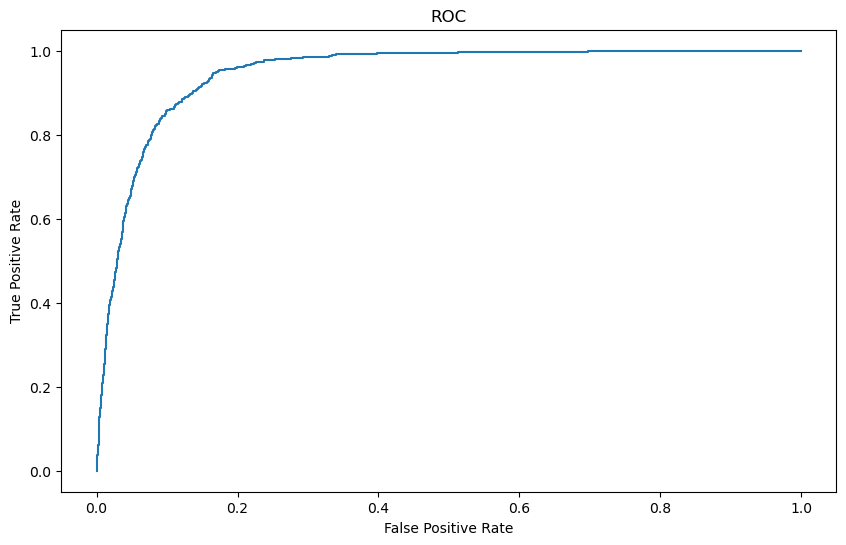

Area Under Curve:  0.9470092837592466


In [140]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = base_cb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)

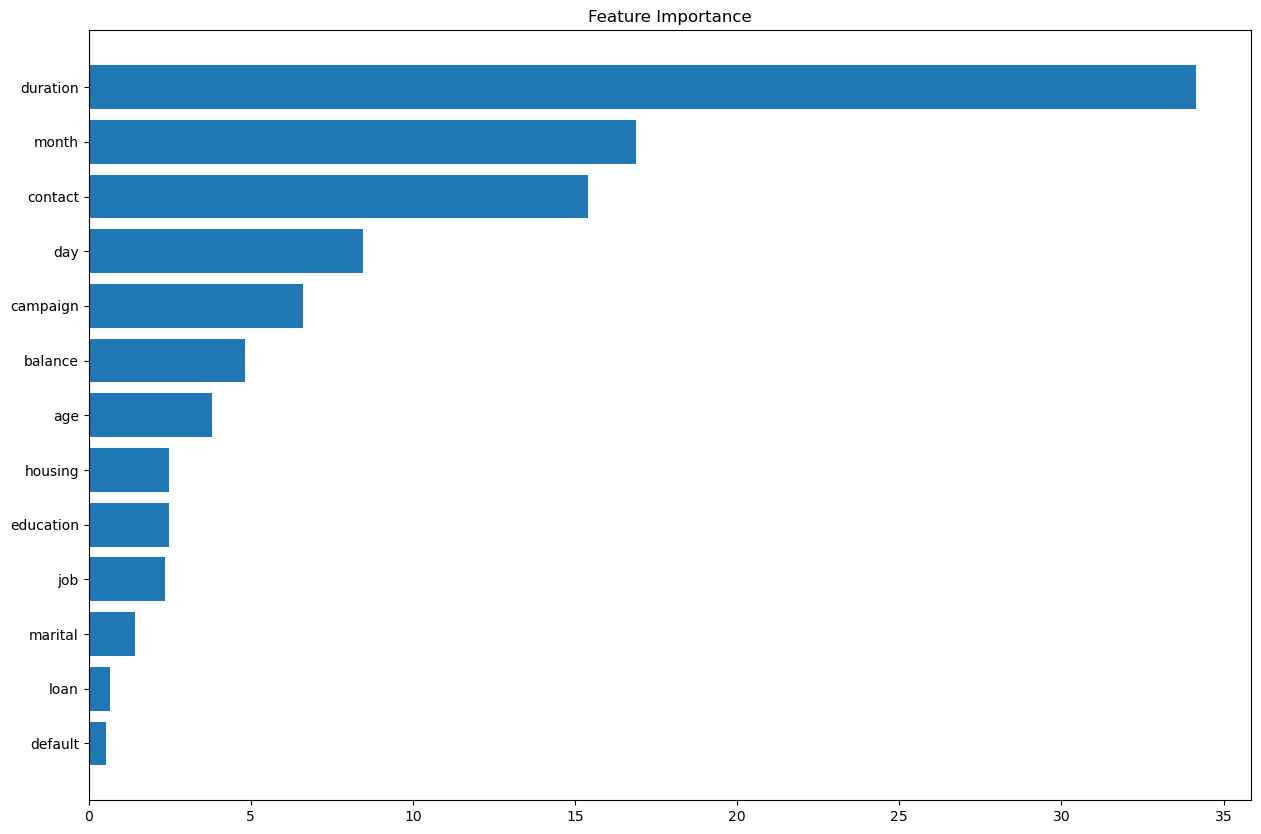

In [141]:
sorted_importances = base_cb.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], base_cb.feature_importances_[sorted_importances])
_ = plt.title('Feature Importance')
_ = plt.savefig('feature_imp_grid.png', bbox_inches='tight')
plt.show()

## HistGradBoost

In [142]:
base_histgradboost = HistGradientBoostingClassifier(random_state=10)
base_histgradboost.fit(X_train, y_train)
y_pred = base_histgradboost.predict(X_test)
training_score = base_histgradboost.fit(X_train, y_train).score(X_train, y_train)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))

Accuracy Score:  0.936125
Training Set Score:  0.95596875
Macro F1 Score:  0.7287321312742722
Weighted F1 Score:  0.9317073391793949


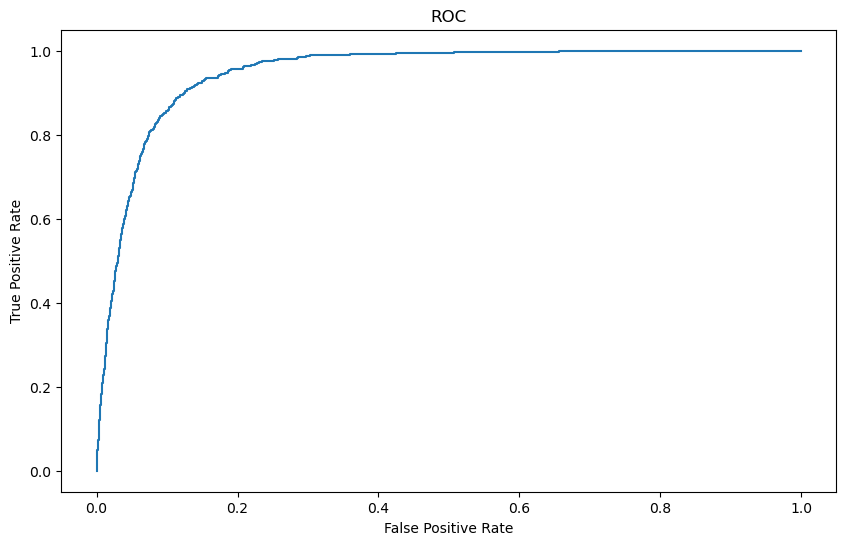

Area Under Curve:  0.947653447724775


In [143]:
y_pred_prob = base_histgradboost.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)

## LightGBM 

Accuracy Score:  0.938375
Training Set Score:  0.95953125
Macro F1 Score:  0.7338341893628022
Weighted F1 Score:  0.9335042862717223


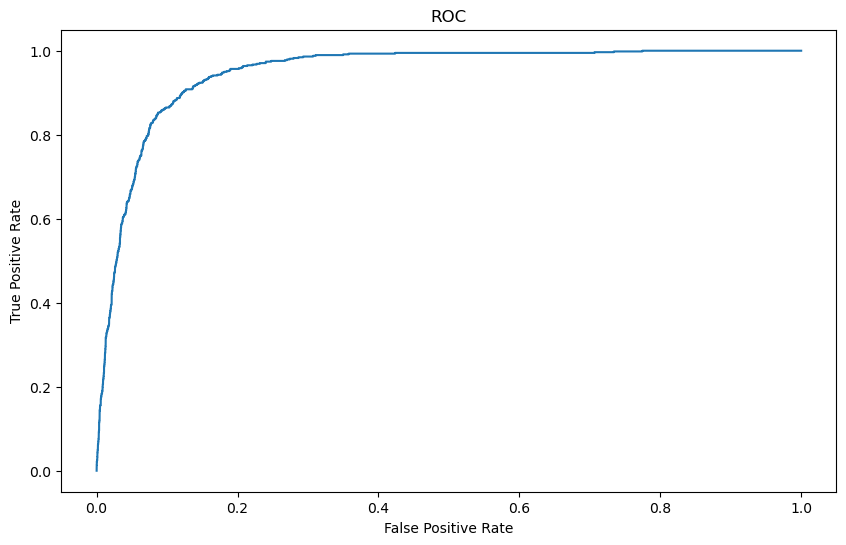

Area Under Curve:  0.9480140534677104


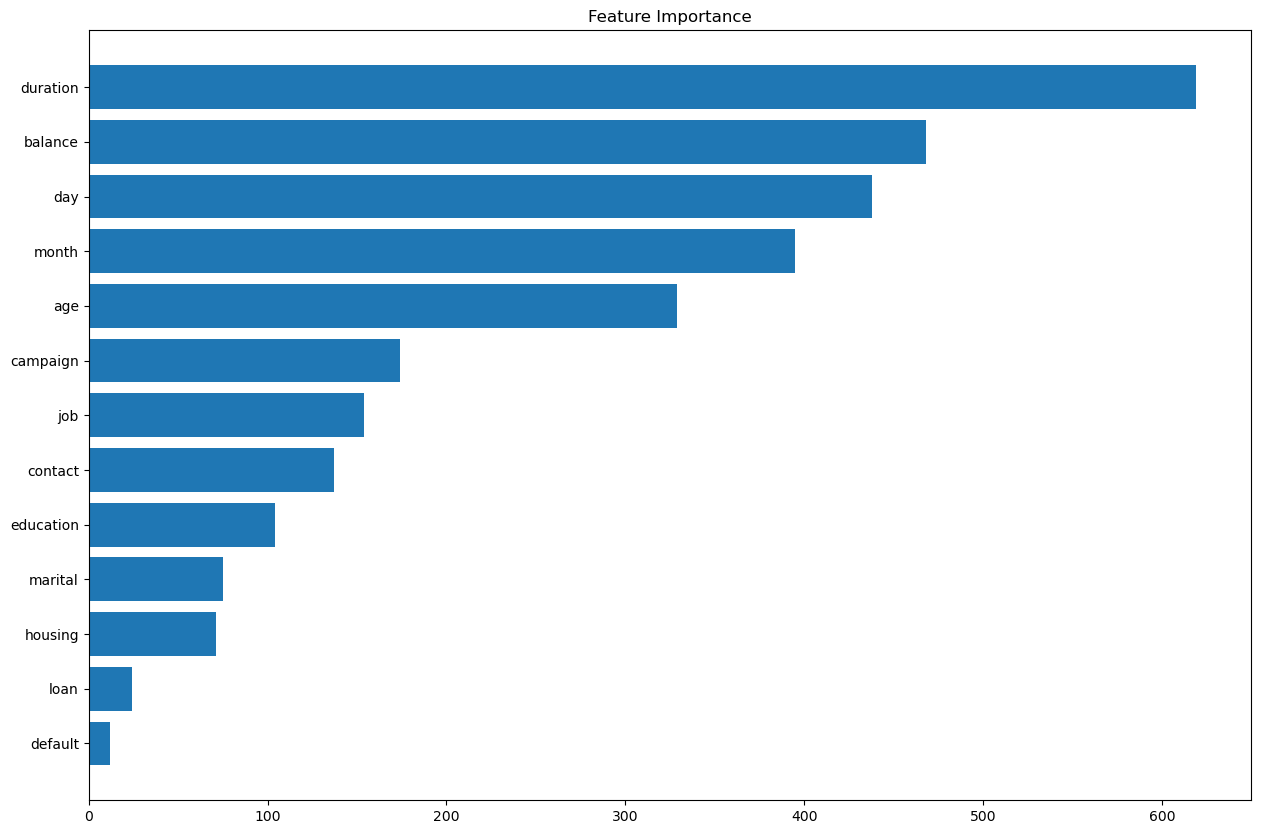

In [144]:
base_lgbm = LGBMClassifier(random_state=10)
base_lgbm.fit(X_train, y_train)
y_pred = base_lgbm.predict(X_test)
training_score = base_lgbm.fit(X_train, y_train).score(X_train, y_train)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))
y_pred_prob = base_lgbm.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)
sorted_importances = base_lgbm.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], base_lgbm.feature_importances_[sorted_importances])
_ = plt.title('Feature Importance')
_ = plt.savefig('feature_imp_grid.png', bbox_inches='tight')
plt.show()

References: 
https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/
https://towardsdatascience.com/boosting-showdown-scikit-learn-vs-xgboost-vs-lightgbm-vs-catboost-in-sentiment-classification-f7c7f46fd956
https://www.projectpro.io/recipes/use-catboost-classifier-and-regressor-in-python
https://www.kaggle.com/code/prashant111/catboost-classifier-in-python


# Sampling Methods

RandomOverSampler VS SMOTE

## SMOTE

In [145]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [146]:
smt = SMOTE()

In [147]:
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

In [148]:
counter = Counter(y_train)
print(counter)

Counter({0: 29681, 1: 2319})


In [149]:
counter = Counter(y_train_sm)
print(counter)

Counter({0: 29681, 1: 29681})


### KNN

C:\Users\ibane\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\ibane\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



Accuracy Score:  0.813625
Training Set Score:  0.9250530642498568
Macro F1 Score:  0.6048469850451083
Weighted F1 Score:  0.8506413600031805


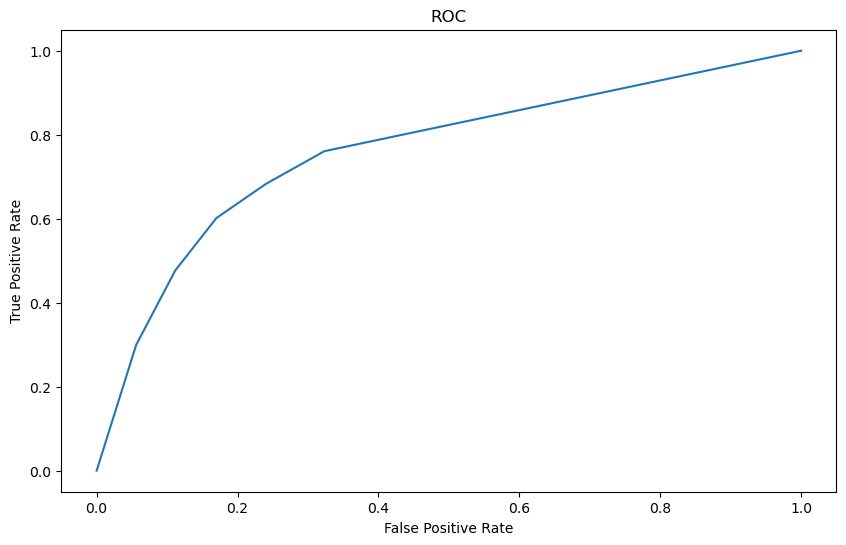

Area Under Curve:  0.7622715103251849


In [150]:
sm_knn = KNeighborsClassifier()
sm_knn.fit(X_train_sm, y_train_sm)
y_pred = sm_knn.predict(X_test)
training_score = sm_knn.fit(X_train_sm, y_train_sm).score(X_train_sm, y_train_sm)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = sm_knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)

### Random Forest Classifier 

Accuracy Score:  0.935875
Training Set Score:  1.0
Macro F1 Score:  0.700204925711964
Weighted F1 Score:  0.927668245686008


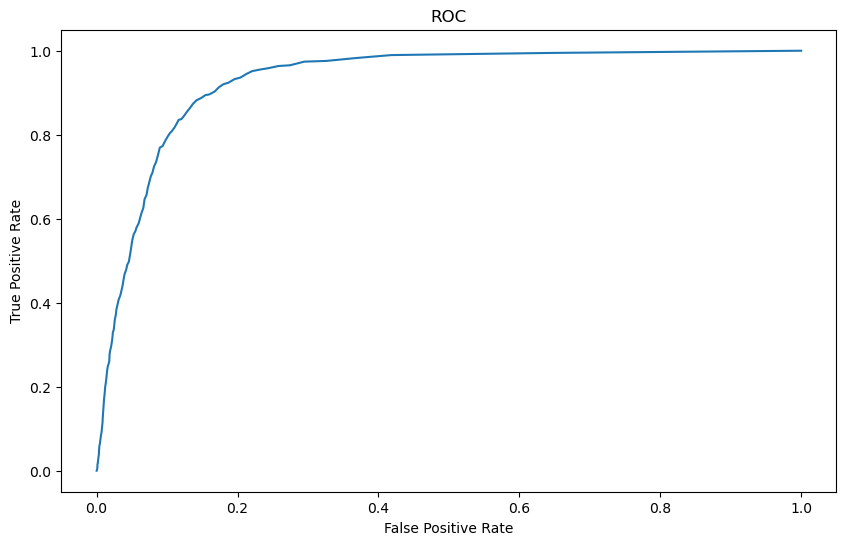

Area Under Curve:  0.9287226384993383


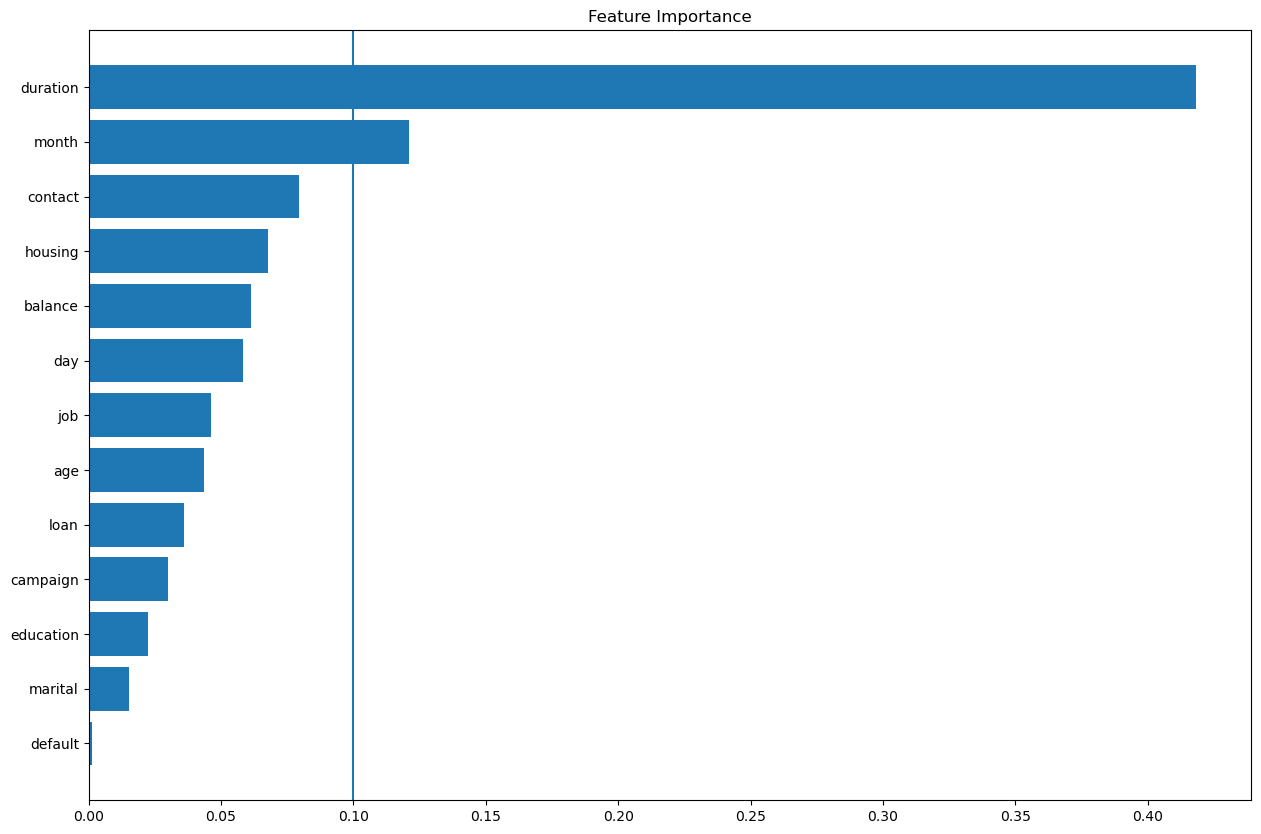

In [151]:
sm_rfc = RandomForestClassifier(random_state=10)
sm_rfc.fit(X_train_sm, y_train_sm)
y_pred = base_rfc.predict(X_test)
training_score = base_rfc.fit(X_train_sm, y_train_sm).score(X_train_sm, y_train_sm)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = sm_rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)
sorted_importances = sm_rfc.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], sm_rfc.feature_importances_[sorted_importances])
_ = plt.axvline(x=0.10)
_ = plt.title('Feature Importance')
_ = plt.savefig('feature_imp_grid.png', bbox_inches='tight')
plt.show()

### ADABoost

Accuracy Score:  0.897875
Training Set Score:  1.0
Macro F1 Score:  0.6884580623607243
Weighted F1 Score:  0.9070383878796268


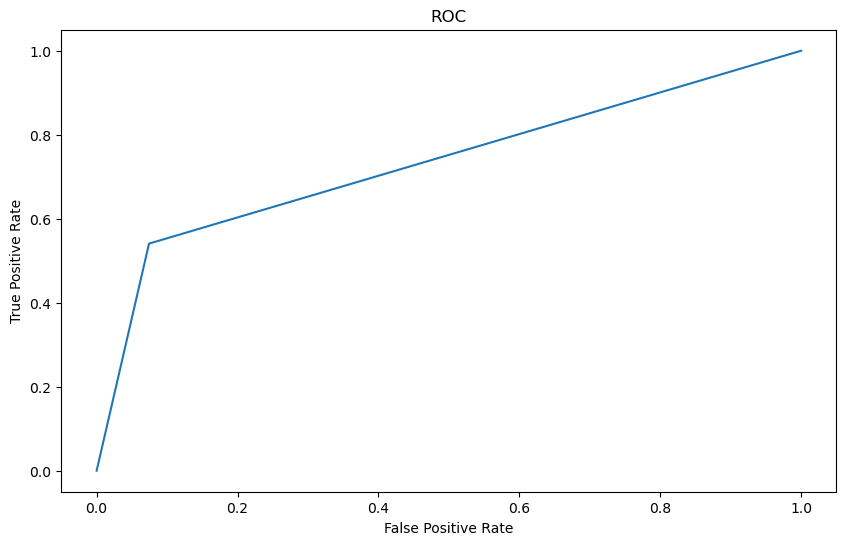

Area Under Curve:  0.7331822190199507


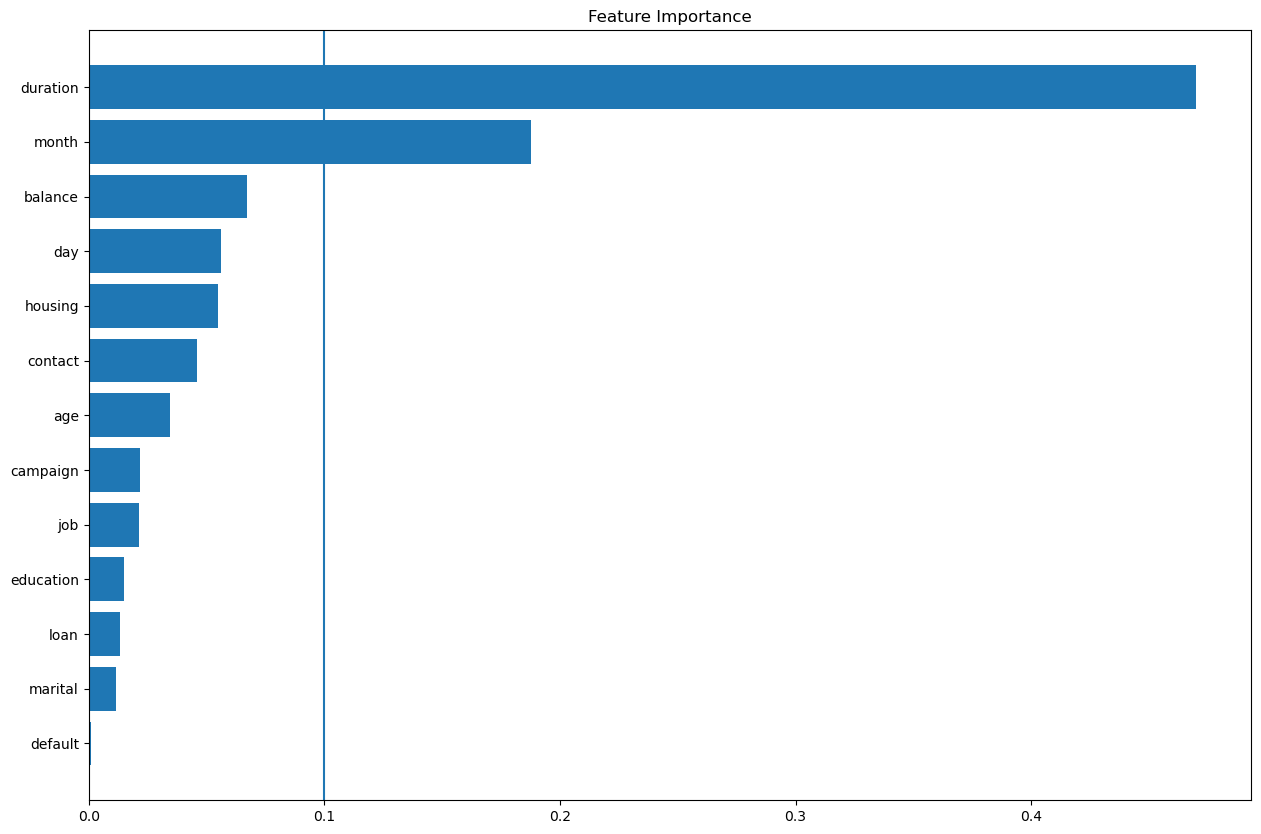

In [152]:
base_estimator = DecisionTreeClassifier(random_state=10)
sm_adaboost = AdaBoostClassifier(base_estimator = base_estimator)
sm_adaboost.fit(X_train_sm, y_train_sm)
y_pred = sm_adaboost.predict(X_test)
training_score = base_adaboost.fit(X_train_sm, y_train_sm).score(X_train_sm, y_train_sm)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = sm_adaboost.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)
sorted_importances = sm_adaboost.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], sm_adaboost.feature_importances_[sorted_importances])
_ = plt.title('Feature Importance')
_ = plt.axvline(x=0.10)
_ = plt.savefig('feature_imp_grid.png', bbox_inches='tight')
plt.show()

## CatBoost

Learning rate set to 0.058914
0:	learn: 0.6230801	total: 40.9ms	remaining: 40.9s
1:	learn: 0.5671801	total: 76ms	remaining: 37.9s
2:	learn: 0.5274302	total: 120ms	remaining: 39.9s
3:	learn: 0.4935214	total: 157ms	remaining: 39s
4:	learn: 0.4654640	total: 193ms	remaining: 38.5s
5:	learn: 0.4359928	total: 231ms	remaining: 38.3s
6:	learn: 0.4172376	total: 267ms	remaining: 37.9s
7:	learn: 0.3984120	total: 304ms	remaining: 37.6s
8:	learn: 0.3832252	total: 348ms	remaining: 38.3s
9:	learn: 0.3651908	total: 386ms	remaining: 38.2s
10:	learn: 0.3536958	total: 434ms	remaining: 39s
11:	learn: 0.3433730	total: 484ms	remaining: 39.8s
12:	learn: 0.3336719	total: 534ms	remaining: 40.5s
13:	learn: 0.3252348	total: 593ms	remaining: 41.8s
14:	learn: 0.3150711	total: 654ms	remaining: 42.9s
15:	learn: 0.3070647	total: 720ms	remaining: 44.3s
16:	learn: 0.3007940	total: 840ms	remaining: 48.6s
17:	learn: 0.2956996	total: 963ms	remaining: 52.5s
18:	learn: 0.2894268	total: 1.02s	remaining: 52.5s
19:	learn: 0.28

164:	learn: 0.1652119	total: 10.1s	remaining: 50.9s
165:	learn: 0.1649794	total: 10.1s	remaining: 50.9s
166:	learn: 0.1648152	total: 10.2s	remaining: 50.7s
167:	learn: 0.1646679	total: 10.2s	remaining: 50.6s
168:	learn: 0.1644036	total: 10.3s	remaining: 50.5s
169:	learn: 0.1642123	total: 10.3s	remaining: 50.5s
170:	learn: 0.1639724	total: 10.4s	remaining: 50.5s
171:	learn: 0.1637390	total: 10.5s	remaining: 50.4s
172:	learn: 0.1635998	total: 10.5s	remaining: 50.3s
173:	learn: 0.1634403	total: 10.6s	remaining: 50.2s
174:	learn: 0.1632186	total: 10.6s	remaining: 50.1s
175:	learn: 0.1628639	total: 10.7s	remaining: 49.9s
176:	learn: 0.1627246	total: 10.7s	remaining: 49.8s
177:	learn: 0.1625089	total: 10.8s	remaining: 49.7s
178:	learn: 0.1623826	total: 10.8s	remaining: 49.6s
179:	learn: 0.1621901	total: 10.9s	remaining: 49.5s
180:	learn: 0.1621240	total: 10.9s	remaining: 49.3s
181:	learn: 0.1619179	total: 10.9s	remaining: 49.2s
182:	learn: 0.1617212	total: 11s	remaining: 49s
183:	learn: 0.16

324:	learn: 0.1424743	total: 20.1s	remaining: 41.7s
325:	learn: 0.1423949	total: 20.2s	remaining: 41.9s
326:	learn: 0.1423013	total: 20.4s	remaining: 41.9s
327:	learn: 0.1422612	total: 20.5s	remaining: 42s
328:	learn: 0.1421093	total: 20.6s	remaining: 42.1s
329:	learn: 0.1419922	total: 20.7s	remaining: 42.1s
330:	learn: 0.1418944	total: 20.8s	remaining: 42s
331:	learn: 0.1417274	total: 20.8s	remaining: 41.9s
332:	learn: 0.1416192	total: 20.9s	remaining: 41.9s
333:	learn: 0.1415260	total: 21s	remaining: 41.8s
334:	learn: 0.1414245	total: 21.1s	remaining: 41.9s
335:	learn: 0.1413424	total: 21.2s	remaining: 41.8s
336:	learn: 0.1412344	total: 21.2s	remaining: 41.8s
337:	learn: 0.1410606	total: 21.3s	remaining: 41.7s
338:	learn: 0.1410087	total: 21.4s	remaining: 41.6s
339:	learn: 0.1409203	total: 21.5s	remaining: 41.7s
340:	learn: 0.1408307	total: 21.5s	remaining: 41.6s
341:	learn: 0.1406777	total: 21.6s	remaining: 41.7s
342:	learn: 0.1406306	total: 21.8s	remaining: 41.7s
343:	learn: 0.1405

486:	learn: 0.1278593	total: 35.8s	remaining: 37.8s
487:	learn: 0.1277935	total: 35.9s	remaining: 37.7s
488:	learn: 0.1277157	total: 36s	remaining: 37.6s
489:	learn: 0.1276598	total: 36s	remaining: 37.5s
490:	learn: 0.1276145	total: 36.1s	remaining: 37.4s
491:	learn: 0.1274991	total: 36.1s	remaining: 37.3s
492:	learn: 0.1274480	total: 36.2s	remaining: 37.2s
493:	learn: 0.1274017	total: 36.3s	remaining: 37.1s
494:	learn: 0.1273296	total: 36.3s	remaining: 37.1s
495:	learn: 0.1272470	total: 36.4s	remaining: 37s
496:	learn: 0.1271434	total: 36.4s	remaining: 36.9s
497:	learn: 0.1270660	total: 36.5s	remaining: 36.8s
498:	learn: 0.1269529	total: 36.5s	remaining: 36.7s
499:	learn: 0.1269252	total: 36.6s	remaining: 36.6s
500:	learn: 0.1268042	total: 36.6s	remaining: 36.5s
501:	learn: 0.1267455	total: 36.7s	remaining: 36.4s
502:	learn: 0.1266588	total: 36.7s	remaining: 36.3s
503:	learn: 0.1265914	total: 36.8s	remaining: 36.2s
504:	learn: 0.1265314	total: 36.8s	remaining: 36.1s
505:	learn: 0.1264

646:	learn: 0.1174581	total: 47.2s	remaining: 25.7s
647:	learn: 0.1173716	total: 47.2s	remaining: 25.7s
648:	learn: 0.1173120	total: 47.3s	remaining: 25.6s
649:	learn: 0.1172658	total: 47.3s	remaining: 25.5s
650:	learn: 0.1172119	total: 47.4s	remaining: 25.4s
651:	learn: 0.1171566	total: 47.4s	remaining: 25.3s
652:	learn: 0.1171022	total: 47.5s	remaining: 25.2s
653:	learn: 0.1170599	total: 47.6s	remaining: 25.2s
654:	learn: 0.1170144	total: 47.6s	remaining: 25.1s
655:	learn: 0.1169866	total: 47.7s	remaining: 25s
656:	learn: 0.1169420	total: 47.7s	remaining: 24.9s
657:	learn: 0.1168890	total: 47.8s	remaining: 24.8s
658:	learn: 0.1168337	total: 47.9s	remaining: 24.8s
659:	learn: 0.1167557	total: 47.9s	remaining: 24.7s
660:	learn: 0.1167031	total: 48s	remaining: 24.6s
661:	learn: 0.1166544	total: 48.1s	remaining: 24.5s
662:	learn: 0.1165951	total: 48.1s	remaining: 24.5s
663:	learn: 0.1165575	total: 48.2s	remaining: 24.4s
664:	learn: 0.1165018	total: 48.3s	remaining: 24.3s
665:	learn: 0.11

808:	learn: 0.1083938	total: 59.5s	remaining: 14.1s
809:	learn: 0.1083420	total: 59.6s	remaining: 14s
810:	learn: 0.1082566	total: 59.7s	remaining: 13.9s
811:	learn: 0.1082332	total: 59.8s	remaining: 13.8s
812:	learn: 0.1082089	total: 59.9s	remaining: 13.8s
813:	learn: 0.1081443	total: 59.9s	remaining: 13.7s
814:	learn: 0.1081074	total: 1m	remaining: 13.6s
815:	learn: 0.1080180	total: 1m	remaining: 13.5s
816:	learn: 0.1079499	total: 1m	remaining: 13.5s
817:	learn: 0.1079312	total: 1m	remaining: 13.4s
818:	learn: 0.1078727	total: 1m	remaining: 13.3s
819:	learn: 0.1077975	total: 1m	remaining: 13.3s
820:	learn: 0.1077476	total: 1m	remaining: 13.2s
821:	learn: 0.1076808	total: 1m	remaining: 13.1s
822:	learn: 0.1076081	total: 1m	remaining: 13.1s
823:	learn: 0.1075705	total: 1m	remaining: 13s
824:	learn: 0.1074977	total: 1m	remaining: 12.9s
825:	learn: 0.1074581	total: 1m	remaining: 12.8s
826:	learn: 0.1074519	total: 1m 1s	remaining: 12.8s
827:	learn: 0.1073514	total: 1m 1s	remaining: 12.7s


966:	learn: 0.1004815	total: 1m 14s	remaining: 2.55s
967:	learn: 0.1004308	total: 1m 14s	remaining: 2.48s
968:	learn: 0.1003719	total: 1m 14s	remaining: 2.4s
969:	learn: 0.1003358	total: 1m 15s	remaining: 2.32s
970:	learn: 0.1002807	total: 1m 15s	remaining: 2.24s
971:	learn: 0.1002109	total: 1m 15s	remaining: 2.17s
972:	learn: 0.1001540	total: 1m 15s	remaining: 2.09s
973:	learn: 0.1000690	total: 1m 15s	remaining: 2.01s
974:	learn: 0.1000165	total: 1m 15s	remaining: 1.94s
975:	learn: 0.0999696	total: 1m 15s	remaining: 1.86s
976:	learn: 0.0999012	total: 1m 15s	remaining: 1.78s
977:	learn: 0.0998761	total: 1m 15s	remaining: 1.71s
978:	learn: 0.0998176	total: 1m 15s	remaining: 1.63s
979:	learn: 0.0997791	total: 1m 16s	remaining: 1.55s
980:	learn: 0.0997405	total: 1m 16s	remaining: 1.47s
981:	learn: 0.0997105	total: 1m 16s	remaining: 1.4s
982:	learn: 0.0996232	total: 1m 16s	remaining: 1.32s
983:	learn: 0.0996091	total: 1m 16s	remaining: 1.24s
984:	learn: 0.0995811	total: 1m 16s	remaining: 1

125:	learn: 0.1759292	total: 12.3s	remaining: 1m 25s
126:	learn: 0.1756666	total: 12.4s	remaining: 1m 25s
127:	learn: 0.1754623	total: 12.5s	remaining: 1m 24s
128:	learn: 0.1752805	total: 12.5s	remaining: 1m 24s
129:	learn: 0.1750723	total: 12.6s	remaining: 1m 24s
130:	learn: 0.1748802	total: 12.7s	remaining: 1m 23s
131:	learn: 0.1746482	total: 12.7s	remaining: 1m 23s
132:	learn: 0.1742205	total: 12.8s	remaining: 1m 23s
133:	learn: 0.1739526	total: 12.8s	remaining: 1m 23s
134:	learn: 0.1736477	total: 12.9s	remaining: 1m 22s
135:	learn: 0.1734802	total: 13s	remaining: 1m 22s
136:	learn: 0.1731925	total: 13s	remaining: 1m 21s
137:	learn: 0.1729033	total: 13.1s	remaining: 1m 21s
138:	learn: 0.1726337	total: 13.1s	remaining: 1m 21s
139:	learn: 0.1723404	total: 13.2s	remaining: 1m 21s
140:	learn: 0.1721704	total: 13.3s	remaining: 1m 20s
141:	learn: 0.1719780	total: 13.4s	remaining: 1m 20s
142:	learn: 0.1717431	total: 13.5s	remaining: 1m 20s
143:	learn: 0.1715719	total: 13.6s	remaining: 1m 2

281:	learn: 0.1469324	total: 29.1s	remaining: 1m 14s
282:	learn: 0.1468148	total: 29.2s	remaining: 1m 14s
283:	learn: 0.1467419	total: 29.3s	remaining: 1m 13s
284:	learn: 0.1466306	total: 29.4s	remaining: 1m 13s
285:	learn: 0.1465624	total: 29.4s	remaining: 1m 13s
286:	learn: 0.1464252	total: 29.6s	remaining: 1m 13s
287:	learn: 0.1463434	total: 29.7s	remaining: 1m 13s
288:	learn: 0.1462380	total: 29.7s	remaining: 1m 13s
289:	learn: 0.1461016	total: 29.8s	remaining: 1m 12s
290:	learn: 0.1460465	total: 29.9s	remaining: 1m 12s
291:	learn: 0.1459284	total: 30s	remaining: 1m 12s
292:	learn: 0.1457988	total: 30.1s	remaining: 1m 12s
293:	learn: 0.1457256	total: 30.2s	remaining: 1m 12s
294:	learn: 0.1456510	total: 30.3s	remaining: 1m 12s
295:	learn: 0.1455438	total: 30.4s	remaining: 1m 12s
296:	learn: 0.1453718	total: 30.5s	remaining: 1m 12s
297:	learn: 0.1451825	total: 30.7s	remaining: 1m 12s
298:	learn: 0.1451227	total: 30.8s	remaining: 1m 12s
299:	learn: 0.1449920	total: 30.9s	remaining: 1m

441:	learn: 0.1314832	total: 43s	remaining: 54.3s
442:	learn: 0.1314196	total: 43.2s	remaining: 54.3s
443:	learn: 0.1313707	total: 43.4s	remaining: 54.3s
444:	learn: 0.1312666	total: 43.5s	remaining: 54.2s
445:	learn: 0.1308987	total: 43.6s	remaining: 54.2s
446:	learn: 0.1308041	total: 43.7s	remaining: 54.1s
447:	learn: 0.1307320	total: 43.8s	remaining: 54s
448:	learn: 0.1306440	total: 43.9s	remaining: 53.9s
449:	learn: 0.1305818	total: 44s	remaining: 53.7s
450:	learn: 0.1304851	total: 44s	remaining: 53.6s
451:	learn: 0.1303976	total: 44.1s	remaining: 53.4s
452:	learn: 0.1302181	total: 44.2s	remaining: 53.3s
453:	learn: 0.1301393	total: 44.3s	remaining: 53.2s
454:	learn: 0.1300661	total: 44.4s	remaining: 53.2s
455:	learn: 0.1299948	total: 44.5s	remaining: 53.1s
456:	learn: 0.1299075	total: 44.5s	remaining: 52.9s
457:	learn: 0.1298563	total: 44.6s	remaining: 52.8s
458:	learn: 0.1297390	total: 44.8s	remaining: 52.8s
459:	learn: 0.1297068	total: 44.9s	remaining: 52.7s
460:	learn: 0.129616

603:	learn: 0.1201378	total: 53.5s	remaining: 35s
604:	learn: 0.1200603	total: 53.5s	remaining: 34.9s
605:	learn: 0.1199827	total: 53.6s	remaining: 34.8s
606:	learn: 0.1199059	total: 53.6s	remaining: 34.7s
607:	learn: 0.1198636	total: 53.7s	remaining: 34.6s
608:	learn: 0.1198164	total: 53.7s	remaining: 34.5s
609:	learn: 0.1197771	total: 53.8s	remaining: 34.4s
610:	learn: 0.1196994	total: 53.8s	remaining: 34.3s
611:	learn: 0.1196375	total: 53.9s	remaining: 34.2s
612:	learn: 0.1195867	total: 53.9s	remaining: 34s
613:	learn: 0.1195721	total: 54s	remaining: 33.9s
614:	learn: 0.1195451	total: 54s	remaining: 33.8s
615:	learn: 0.1194798	total: 54.1s	remaining: 33.7s
616:	learn: 0.1193985	total: 54.2s	remaining: 33.6s
617:	learn: 0.1193369	total: 54.3s	remaining: 33.5s
618:	learn: 0.1193033	total: 54.4s	remaining: 33.5s
619:	learn: 0.1192852	total: 54.5s	remaining: 33.4s
620:	learn: 0.1191863	total: 54.6s	remaining: 33.3s
621:	learn: 0.1191311	total: 54.6s	remaining: 33.2s
622:	learn: 0.119054

763:	learn: 0.1108298	total: 1m 5s	remaining: 20.1s
764:	learn: 0.1107647	total: 1m 5s	remaining: 20s
765:	learn: 0.1106969	total: 1m 5s	remaining: 19.9s
766:	learn: 0.1106267	total: 1m 5s	remaining: 19.8s
767:	learn: 0.1105921	total: 1m 5s	remaining: 19.8s
768:	learn: 0.1105339	total: 1m 5s	remaining: 19.7s
769:	learn: 0.1104466	total: 1m 5s	remaining: 19.6s
770:	learn: 0.1103740	total: 1m 5s	remaining: 19.5s
771:	learn: 0.1103397	total: 1m 5s	remaining: 19.4s
772:	learn: 0.1102753	total: 1m 5s	remaining: 19.3s
773:	learn: 0.1102206	total: 1m 5s	remaining: 19.2s
774:	learn: 0.1101758	total: 1m 5s	remaining: 19.1s
775:	learn: 0.1101104	total: 1m 5s	remaining: 19s
776:	learn: 0.1100832	total: 1m 5s	remaining: 18.9s
777:	learn: 0.1100396	total: 1m 6s	remaining: 18.8s
778:	learn: 0.1099916	total: 1m 6s	remaining: 18.8s
779:	learn: 0.1099596	total: 1m 6s	remaining: 18.7s
780:	learn: 0.1099082	total: 1m 6s	remaining: 18.6s
781:	learn: 0.1098574	total: 1m 6s	remaining: 18.5s
782:	learn: 0.10

920:	learn: 0.1025412	total: 1m 16s	remaining: 6.54s
921:	learn: 0.1025126	total: 1m 16s	remaining: 6.46s
922:	learn: 0.1024874	total: 1m 16s	remaining: 6.37s
923:	learn: 0.1024428	total: 1m 16s	remaining: 6.29s
924:	learn: 0.1023903	total: 1m 16s	remaining: 6.21s
925:	learn: 0.1023087	total: 1m 16s	remaining: 6.13s
926:	learn: 0.1022657	total: 1m 16s	remaining: 6.05s
927:	learn: 0.1022432	total: 1m 17s	remaining: 5.98s
928:	learn: 0.1022000	total: 1m 17s	remaining: 5.91s
929:	learn: 0.1021615	total: 1m 17s	remaining: 5.83s
930:	learn: 0.1020937	total: 1m 17s	remaining: 5.75s
931:	learn: 0.1020706	total: 1m 17s	remaining: 5.66s
932:	learn: 0.1020182	total: 1m 17s	remaining: 5.58s
933:	learn: 0.1019853	total: 1m 17s	remaining: 5.5s
934:	learn: 0.1019194	total: 1m 17s	remaining: 5.42s
935:	learn: 0.1018650	total: 1m 18s	remaining: 5.33s
936:	learn: 0.1018427	total: 1m 18s	remaining: 5.25s
937:	learn: 0.1017960	total: 1m 18s	remaining: 5.17s
938:	learn: 0.1017426	total: 1m 18s	remaining: 

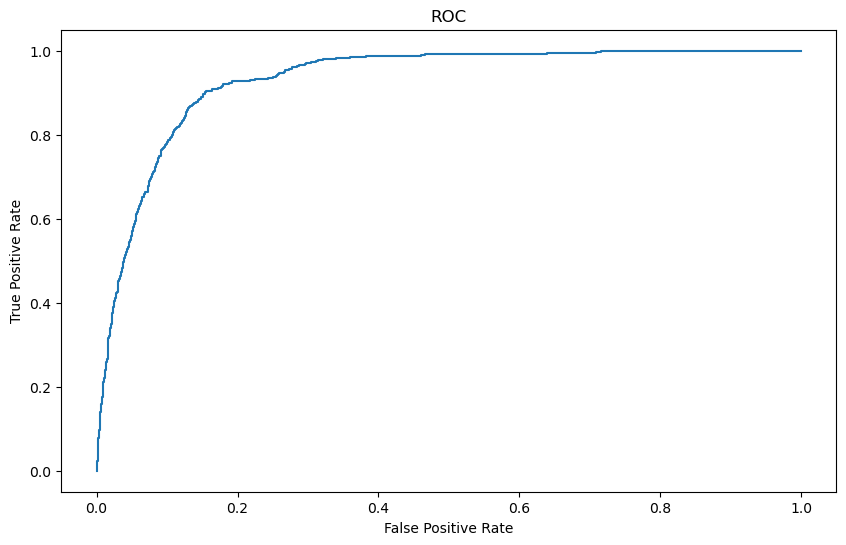

Area Under Curve:  0.9298031716028055


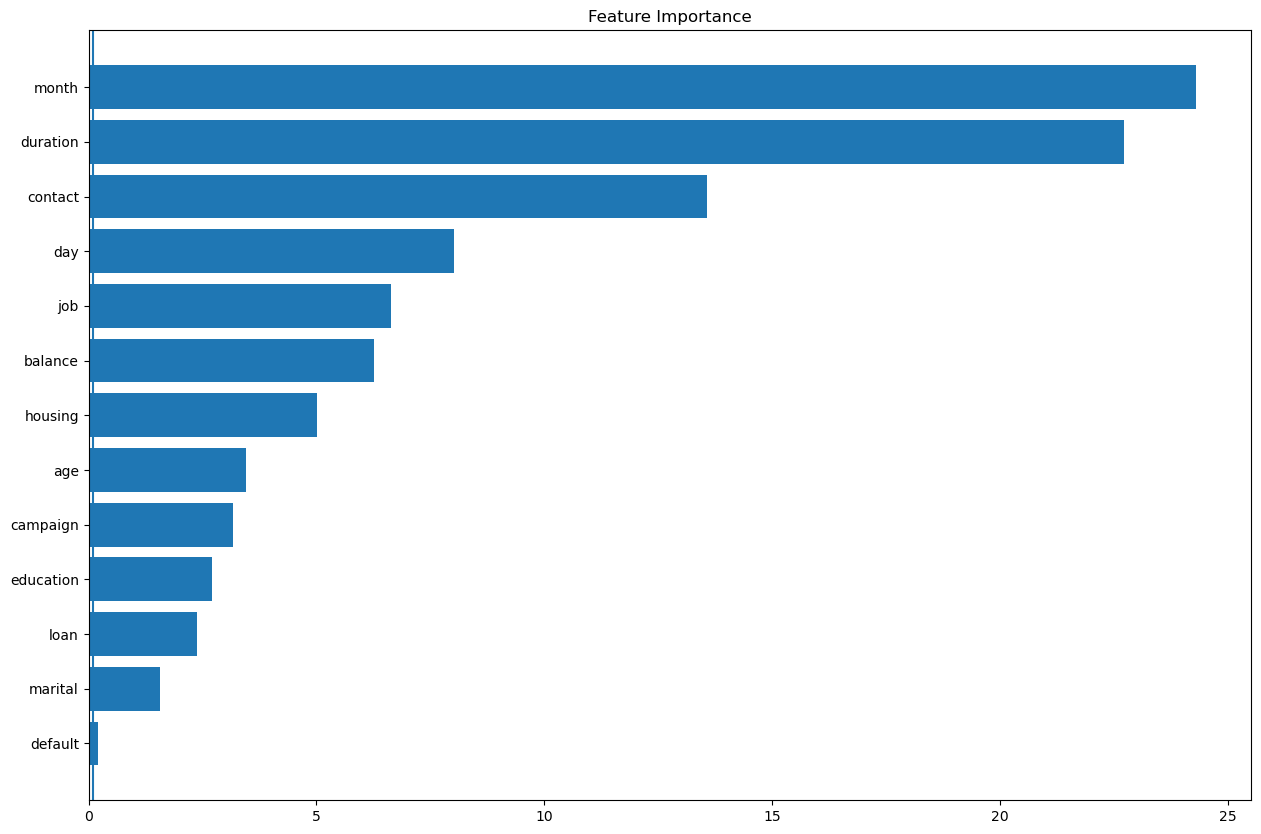

In [153]:
sm_cb = CatBoostClassifier(random_state=10)
sm_cb.fit(X_train_sm, y_train_sm)
y_pred = sm_cb.predict(X_test)
training_score = sm_cb.fit(X_train_sm, y_train_sm).score(X_train_sm, y_train_sm)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = sm_cb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)
sorted_importances = sm_cb.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], sm_cb.feature_importances_[sorted_importances])
_ = plt.axvline(x=0.10)
_ = plt.title('Feature Importance')
_ = plt.savefig('feature_imp_grid.png', bbox_inches='tight')
plt.show()

## LightGBM

Accuracy Score:  0.90775
Training Set Score:  0.9487045584717496
Macro F1 Score:  0.7348709381904404
Weighted F1 Score:  0.9180799253650914


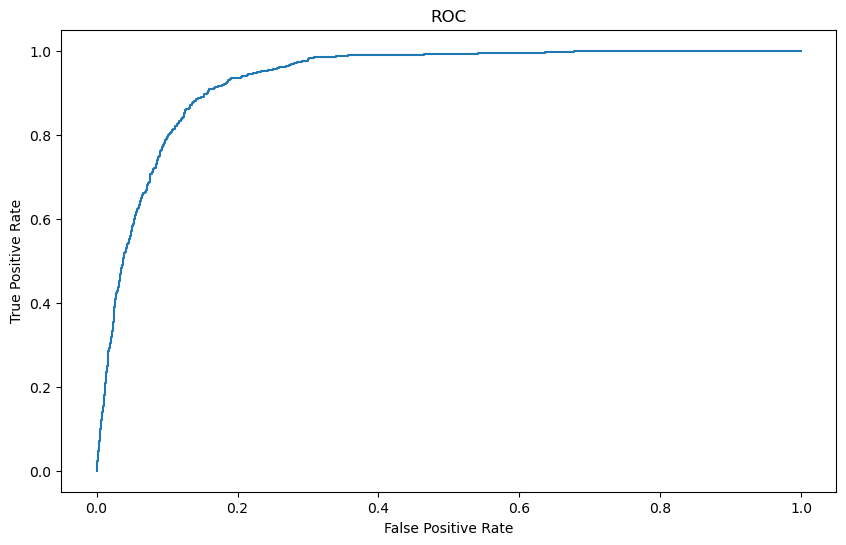

Area Under Curve:  0.9321391123331833


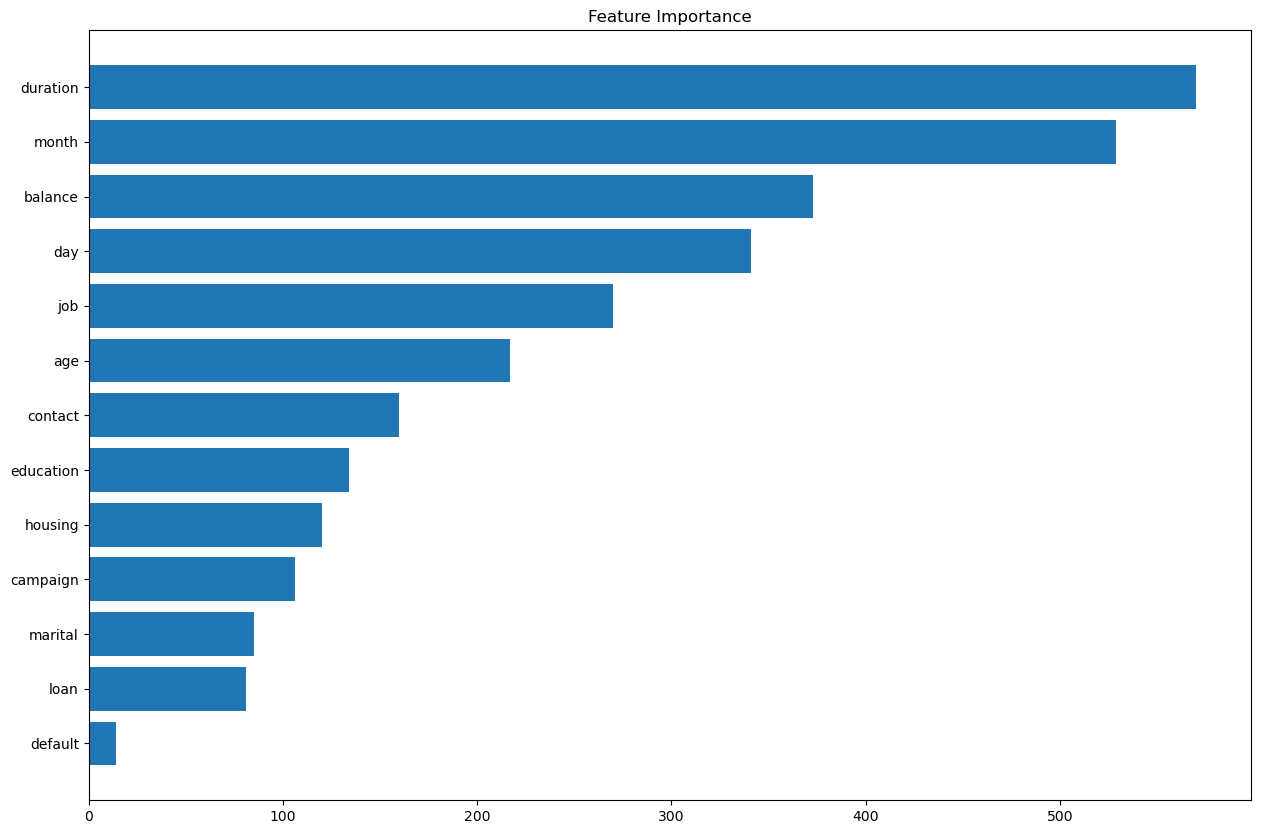

In [154]:
sm_lgbm = LGBMClassifier(random_state=10)
sm_lgbm.fit(X_train_sm, y_train_sm)
y_pred = sm_lgbm.predict(X_test)
training_score = sm_lgbm.fit(X_train_sm, y_train_sm).score(X_train_sm, y_train_sm)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))
y_pred_prob = sm_lgbm.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)
sorted_importances = sm_lgbm.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], sm_lgbm.feature_importances_[sorted_importances])
_ = plt.title('Feature Importance')
_ = plt.savefig('feature_imp_grid.png', bbox_inches='tight')
plt.show()

### Hyperparameter Tuning of Best Model
The Random Forest Classifier is the best performing model as it has the highest area under the curve and the highest weighted F1 score. 


In [155]:
param_grid = {'n_estimators':np.arange(1,50), 
              'max_depth': np.arange(1,10),
             'criterion': ['gini', 'entropy']}
grid_rfc = GridSearchCV(RandomForestClassifier(random_state = 10), param_grid, cv=5, scoring = 'accuracy')
grid_rfc.fit(X_train, y_train)
print('Mean Cross Validation Score:' ,grid_rfc.best_score_)
print('Parameters with Highest Cross Validation Score: ',grid_rfc.best_params_)
print("Random Forest Classifier Model's Best Accuracy: ", grid_rfc.score(X_test,y_test))

Mean Cross Validation Score: 0.93378125
Parameters with Highest Cross Validation Score:  {'criterion': 'gini', 'max_depth': 9, 'n_estimators': 27}
Random Forest Classifier Model's Best Accuracy:  0.93275


Accuracy Score:  0.918
Training Set Score:  1.0
Macro F1 Score:  0.7280463216710393
Weighted F1 Score:  0.9225457057332686


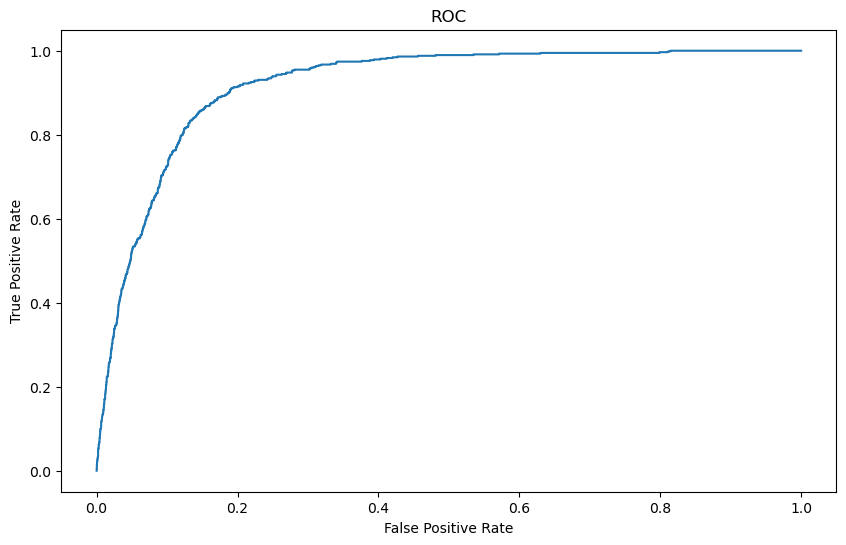

Area Under Curve:  0.9185007673232594


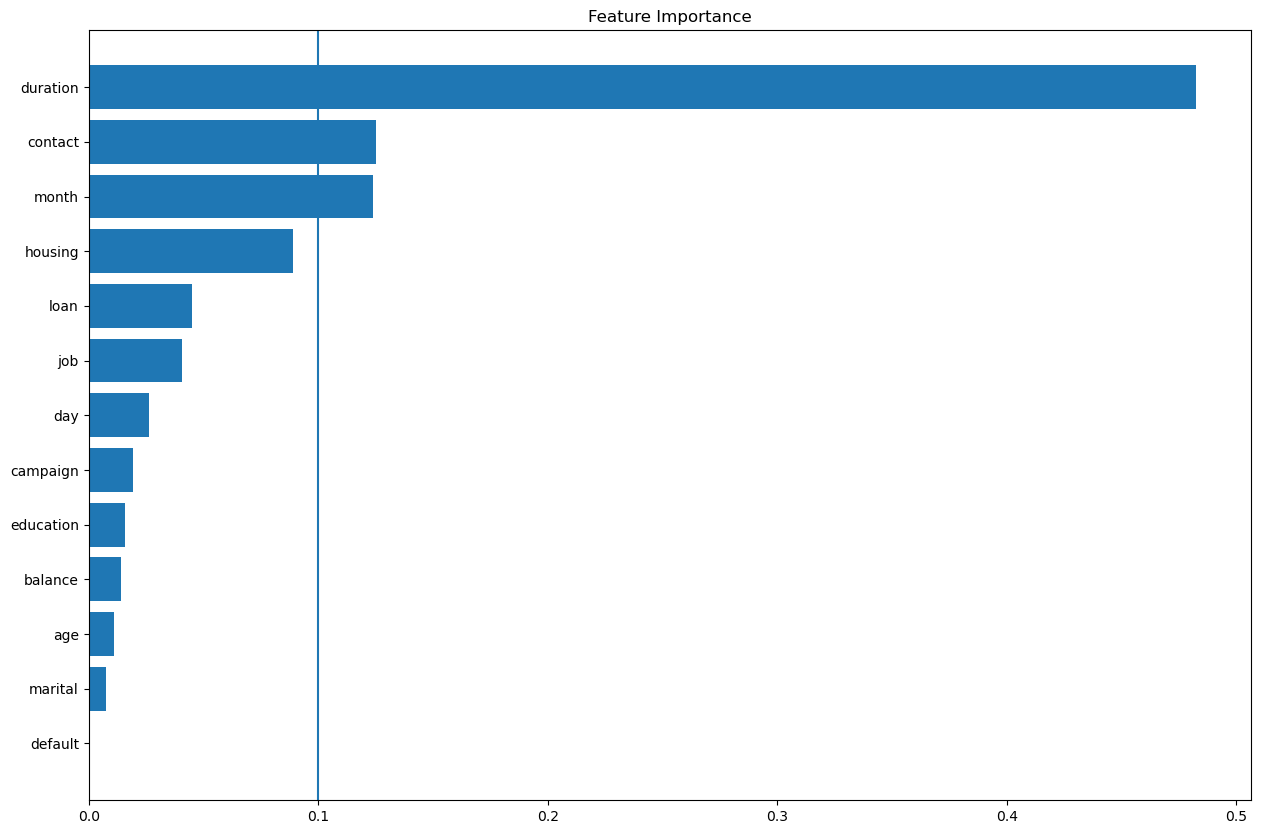

In [156]:
sm_rfc = RandomForestClassifier(random_state=10, criterion = 'gini', max_depth = 9, n_estimators = 34)
sm_rfc.fit(X_train_sm, y_train_sm)
y_pred = base_rfc.predict(X_test)
training_score = base_rfc.fit(X_train_sm, y_train_sm).score(X_train_sm, y_train_sm)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = sm_rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)
sorted_importances = sm_rfc.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], sm_rfc.feature_importances_[sorted_importances])
_ = plt.axvline(x=0.10)
_ = plt.title('Feature Importance')
_ = plt.savefig('feature_imp_grid.png', bbox_inches='tight')
plt.show()

<AxesSubplot:>

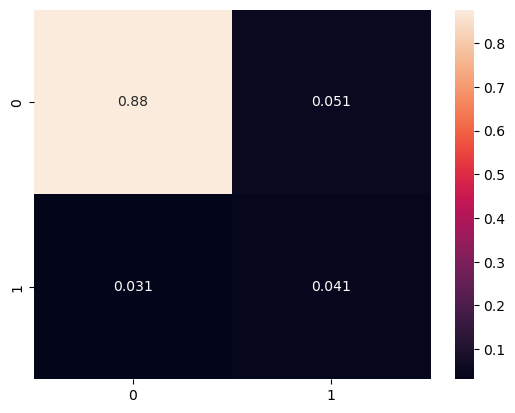

In [157]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True)

# Customer Segmentation

## KMeans Clustering

In [158]:
data.head()
features = data.drop('y', axis = 1)
target = data['y']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 10)

In [159]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)

In [160]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
silhouette_avg = []
inertia = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state = 10, init = 'k-means++')
    kmeans.fit(scaled_X_train)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(scaled_X_train, cluster_labels))
    inertia.append(kmeans.inertia_)

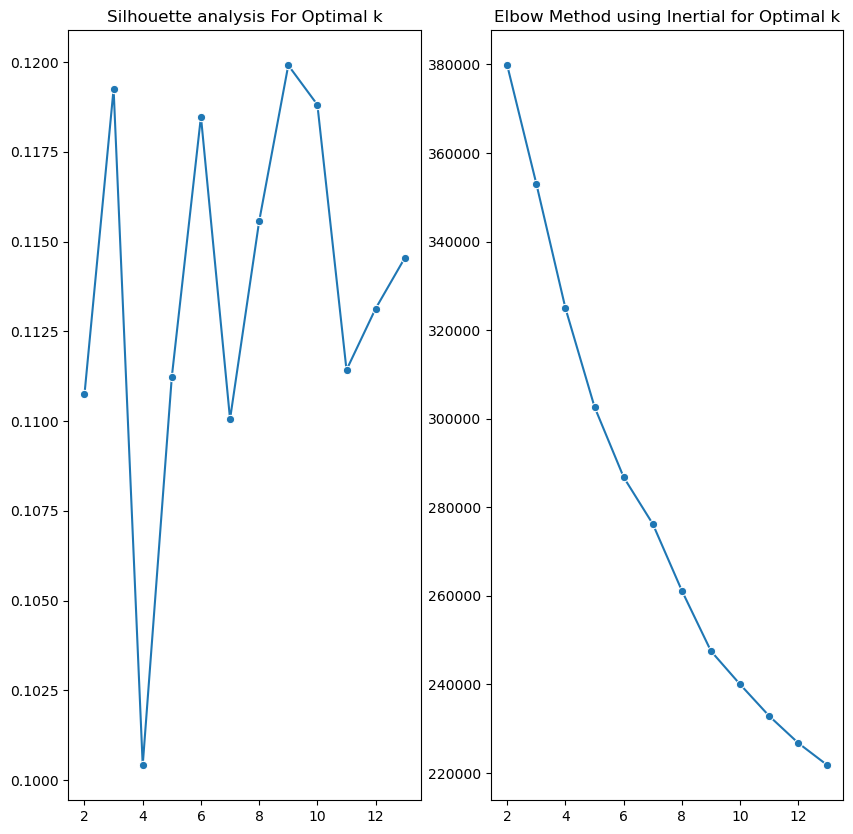

In [161]:
fig, axes = plt.subplots(1, 2, figsize=(10,10))
sns.lineplot(x=range_n_clusters,y=silhouette_avg, ax = axes[0], marker = 'o')
axes[0].set_title('Silhouette analysis For Optimal k')
sns.lineplot(x= range_n_clusters, y = inertia, ax= axes[1], marker = 'o')
axes[1].set_title('Elbow Method using Inertial for Optimal k')
plt.show();

In [162]:
kmeans2 = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
kmeans2.fit(scaled_X_train)
scaled_X_train_2 = pd.DataFrame(scaled_X_train)
scaled_X_train_2.columns = X_train.columns
scaled_X_train_2['Segment KMeans'] = kmeans2.labels_
scaled_X_train_2['y_true'] = y_train.values

In [163]:
scaled_X_train_2['Segment KMeans'].value_counts()/len(scaled_X_train)*100

1    61.171875
0    38.828125
Name: Segment KMeans, dtype: float64

In [164]:
scaled_X_train_2['y_true'].value_counts()/len(scaled_X_train)*100

0    92.753125
1     7.246875
Name: y_true, dtype: float64

In [165]:
accuracy_score(scaled_X_train_2['y_true'], scaled_X_train_2['Segment KMeans'])

0.4020625

<AxesSubplot:xlabel='y_true', ylabel='count'>

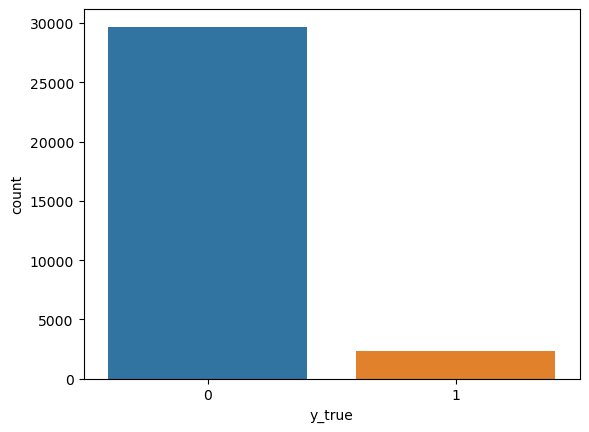

In [166]:
fig, ax
sns.countplot(x = 'y_true', data = scaled_X_train_2)

In [167]:
scaled_X_train_2.head(2)

age       job   marital  education   default   balance   housing  \
0 -0.678175  1.437132 -1.902177  -0.272884 -0.142971  0.946280  0.811986   
1 -0.574490 -1.296069  1.393509  -1.619419 -0.142971  0.376746  0.811986   

       loan   contact       day     month  duration  campaign  Segment KMeans  \
0 -0.457173  1.414975  0.483082 -0.437060  0.251215 -0.573307               1   
1 -0.457173  1.414975  0.000532 -0.002201 -0.593977 -0.573307               1   

   y_true  
0       0  
1       0

In [168]:
kmeans2_results = pd.DataFrame(y_test)
kmeans2_results['y_pred'] = kmeans2.predict(X_test)

C:\Users\ibane\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but KMeans was fitted without feature names



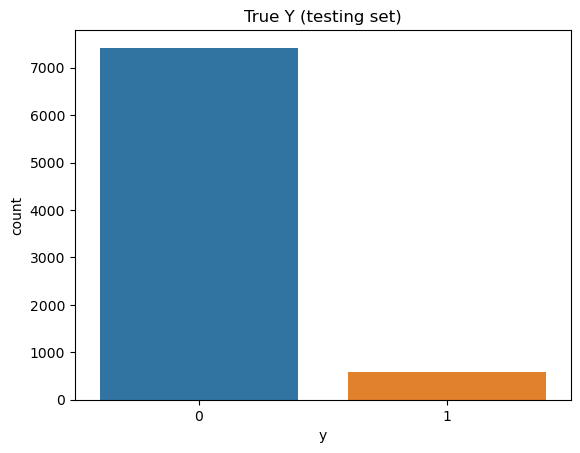

In [169]:
sns.countplot(x = kmeans2_results['y'])
plt.title('True Y (testing set)')
plt.show();

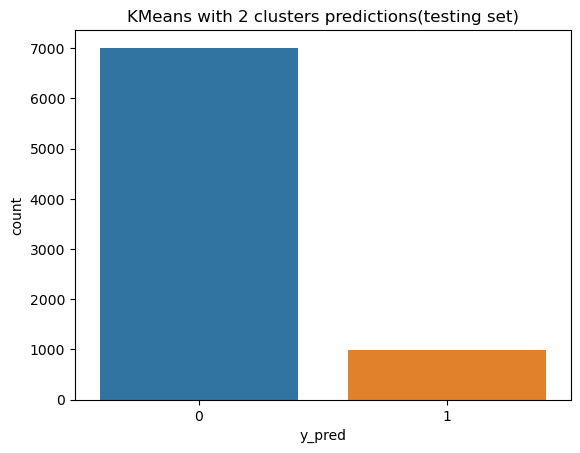

In [170]:
sns.countplot(x = kmeans2_results['y_pred'])
plt.title('KMeans with 2 clusters predictions(testing set)')
plt.show();

### 4 Clusters

In [171]:
kmeans4 = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans4.fit(scaled_X_train)
scaled_X_train4 = pd.DataFrame(scaled_X_train)
scaled_X_train4.columns = X_train.columns
scaled_X_train4['Segment KMeans'] = kmeans4.labels_
scaled_X_train4['y_true'] = y_train.values

In [172]:
scaled_X_train4['Segment KMeans'].value_counts()/len(scaled_X_train)*100

2    48.365625
1    33.100000
0    16.531250
3     2.003125
Name: Segment KMeans, dtype: float64

In [173]:
scaled_X_train4['y_true'].value_counts()/len(scaled_X_train)*100

0    92.753125
1     7.246875
Name: y_true, dtype: float64

In [174]:
accuracy_score(scaled_X_train4['y_true'], scaled_X_train4['Segment KMeans'])

0.1833125

In [175]:
scaled_X_train4.head()

age       job   marital  education   default   balance   housing  \
0 -0.678175  1.437132 -1.902177  -0.272884 -0.142971  0.946280  0.811986   
1 -0.574490 -1.296069  1.393509  -1.619419 -0.142971  0.376746  0.811986   
2 -0.989230 -0.385002 -0.254334  -1.619419 -0.142971 -0.424140 -1.231549   
3  1.188156 -1.296069 -0.254334  -1.619419 -0.142971  0.351079  0.811986   
4 -0.367119 -1.296069 -0.254334  -1.619419 -0.142971 -0.356156  0.811986   

       loan   contact       day     month  duration  campaign  Segment KMeans  \
0 -0.457173  1.414975  0.483082 -0.437060  0.251215 -0.573307               2   
1 -0.457173  1.414975  0.000532 -0.002201 -0.593977 -0.573307               2   
2 -0.457173  1.414975 -1.447121  0.432657 -0.497494  0.345546               2   
3  2.187356  0.330079 -1.447121 -1.741634 -0.667304 -0.573307               0   
4 -0.457173  1.414975 -0.964570 -0.437060 -0.362418  1.570685               2   

   y_true  
0       0  
1       0  
2       0  
3       0  
4       0

## PCA and Kmeans Clustering Analysis

In [176]:
data.head()

age  job  marital  education  default  balance  housing  loan  contact  \
20749   38    9        1          2        0      128        0     0        0   
22532   34    4        2          1        0        0        0     0        0   
16174   34    4        2          2        0      184        0     0        0   
36796   31    9        2          1        0        1        1     0        0   
12882   47    9        2          1        0     -239        1     1        0   

       day  month  duration  campaign  y  
20749   13      8       183         5  0  
22532   22      8       132         4  0  
16174   22      7       203         4  0  
36796   12      5       223         1  0  
12882    7      7       973         3  1

In [177]:
features = data.drop('y', axis = 1)
target = data['y']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 10)

In [178]:
X_train

age  job  marital  education  default  balance  housing  loan  contact  \
4465    34    9        0          1        0     3997        1     0        2   
10637   35    0        2          0        0     2355        1     0        2   
12625   31    3        1          0        0       46        0     0        2   
29752   52    0        1          0        0     2281        1     1        1   
1386    37    0        1          0        0      242        1     0        2   
...    ...  ...      ...        ...      ...      ...      ...   ...      ...   
16700   47    9        1          3        0      751        1     0        0   
33960   34    7        1          1        0     1337        0     0        0   
21279   36    4        2          2        0     1283        0     0        0   
7875    40    0        1          1        0     1538        1     0        2   
39068   24    7        1          1        0     1354        1     1        0   

       day  month  duration  campaign  
4465    20      5       320         1  
10637   16      6       101         1  
12625    4      7       126         4  
29752    4      2        82         1  
1386     8      5       161         8  
...    ...    ...       ...       ...  
16700   24      7        99         1  
33960   30      4       442         1  
21279   18      8        92         5  
7875    30      5       390         2  
39068   18      5       239         2  

[32000 rows x 13 columns]

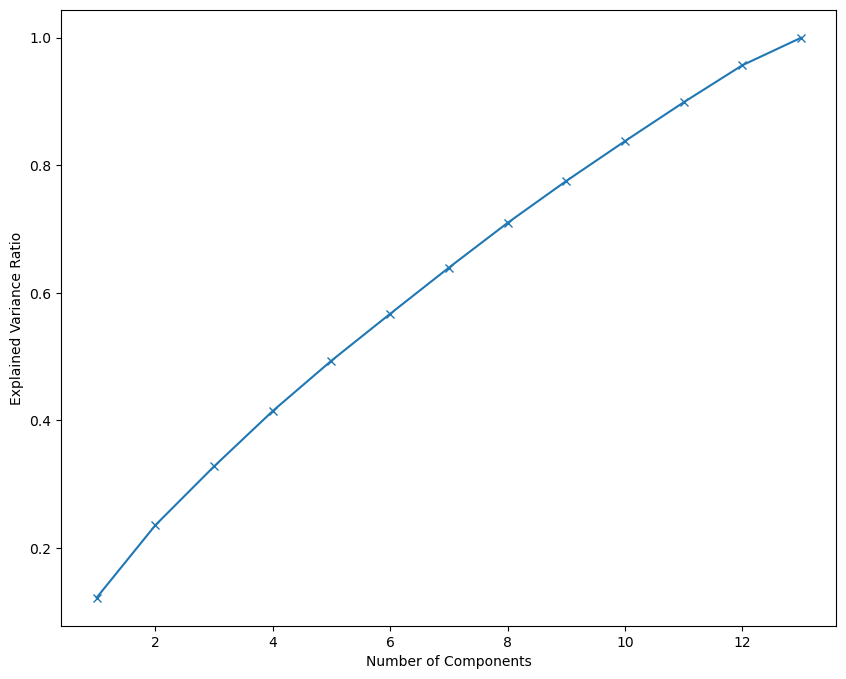

In [179]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
pca = PCA()
pca.fit(scaled_X_train)
plt.figure(figsize=(10,8))
plt.plot(range(1,14), pca.explained_variance_ratio_.cumsum(), marker = 'x')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show();

Not abundantly clear how many clusters we should go with. I know from the feature importances extracted that we are looking for around 3 or 4 clusters. 

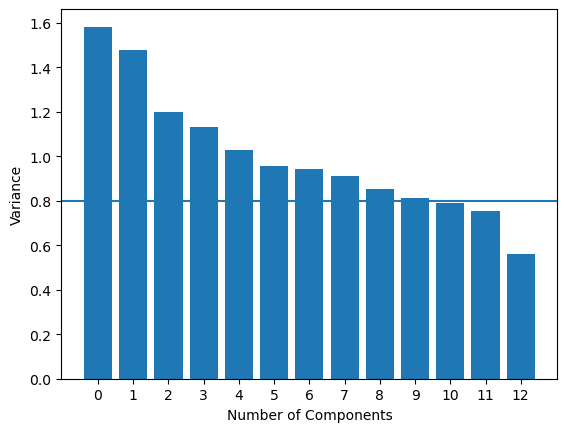

In [180]:
features_pca = range(pca.n_components_)
plt.bar(features_pca, pca.explained_variance_)
plt.xticks(features_pca)
plt.ylabel('Variance')
plt.xlabel('Number of Components')
plt.axhline(0.8)
plt.show()

Will keep at least 80% variance. 

### PCA with 2 components

(32000, 13)
(32000, 2)


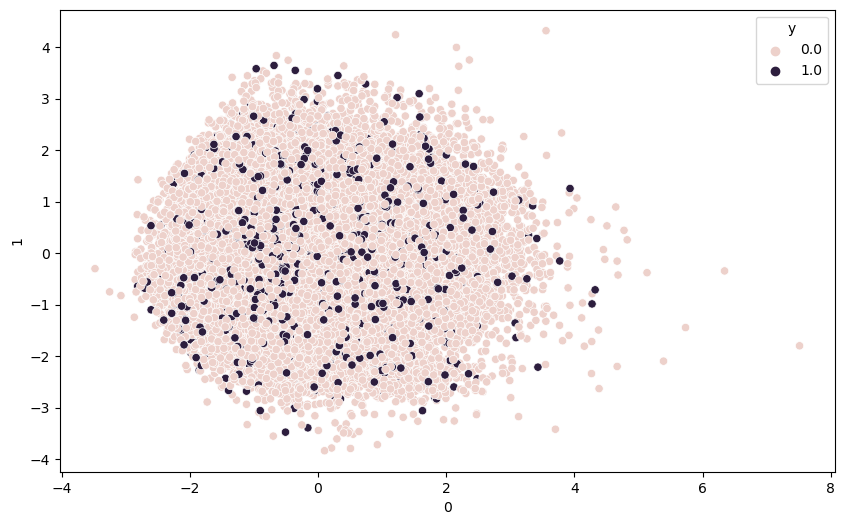

In [181]:
pca2 = PCA(n_components = 2)
pca2.fit(scaled_X_train)
transformed2 = pca2.transform(scaled_X_train)
print(scaled_X_train.shape)
print(transformed2.shape)
trans_df2 = pd.DataFrame(transformed2)
plt.figure(figsize=(10,6))
sns.scatterplot(x= trans_df2[0], y= trans_df2[1], hue = y_train)
plt.show()

(32000, 13)
(32000, 3)


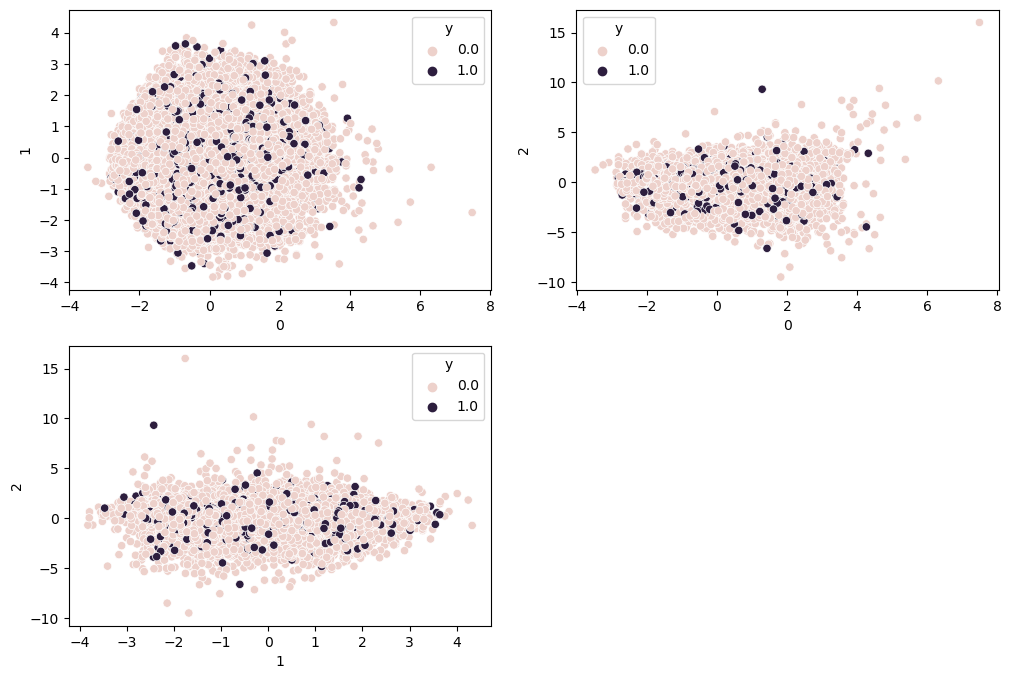

In [182]:
pca3 = PCA(n_components = 3)
pca3.fit(scaled_X_train)
transformed3 = pca3.transform(scaled_X_train)
print(scaled_X_train.shape)
print(transformed3.shape)
trans_df3 = pd.DataFrame(transformed3)
fig, axes = plt.subplots(nrows=2,ncols=2, figsize = (12, 8))
sns.scatterplot(x= trans_df3[0], y= trans_df3[1], hue = y_train, ax = axes[0,0])
sns.scatterplot(x= trans_df3[0], y= trans_df3[2], hue = y_train, ax = axes[0,1])
sns.scatterplot(x= trans_df3[1], y= trans_df3[2], hue = y_train, ax = axes[1,0])
axes[-1,-1].axis('off')
plt.show();

### PCA with 4 components

(32000, 13)
(32000, 4)


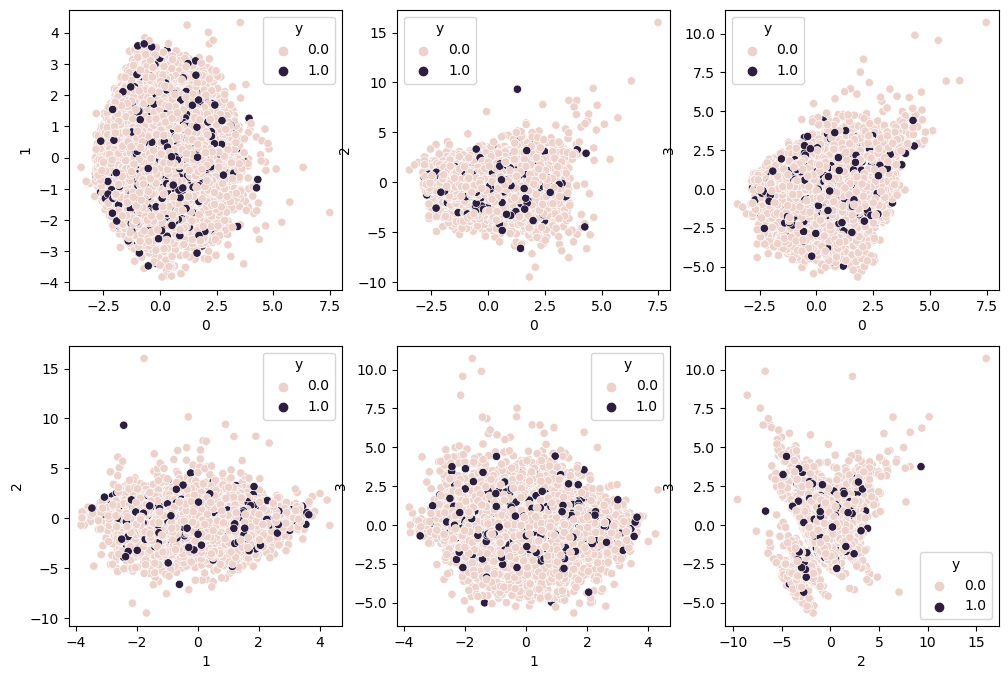

In [183]:
pca4 = PCA(n_components = 4)
pca4.fit(scaled_X_train)
transformed4 = pca4.transform(scaled_X_train)
print(scaled_X_train.shape)
print(transformed4.shape)
trans_df4 = pd.DataFrame(transformed4)
fig, axes = plt.subplots(nrows=2,ncols=3, figsize = (12, 8))
sns.scatterplot(x= trans_df4[0], y= trans_df4[1], hue = y_train, ax = axes[0,0])
sns.scatterplot(x= trans_df4[0], y= trans_df4[2], hue = y_train, ax = axes[0,1])
sns.scatterplot(x= trans_df4[0], y= trans_df4[3], hue = y_train, ax = axes[0,2])
sns.scatterplot(x= trans_df4[1], y= trans_df4[2], hue = y_train, ax = axes[1,0])
sns.scatterplot(x= trans_df4[1], y= trans_df4[3], hue = y_train, ax = axes[1,1])
sns.scatterplot(x= trans_df4[2], y= trans_df4[3], hue = y_train, ax = axes[1,2])
plt.show();

### PCA with 8 components

(32000, 13)
(32000, 8)


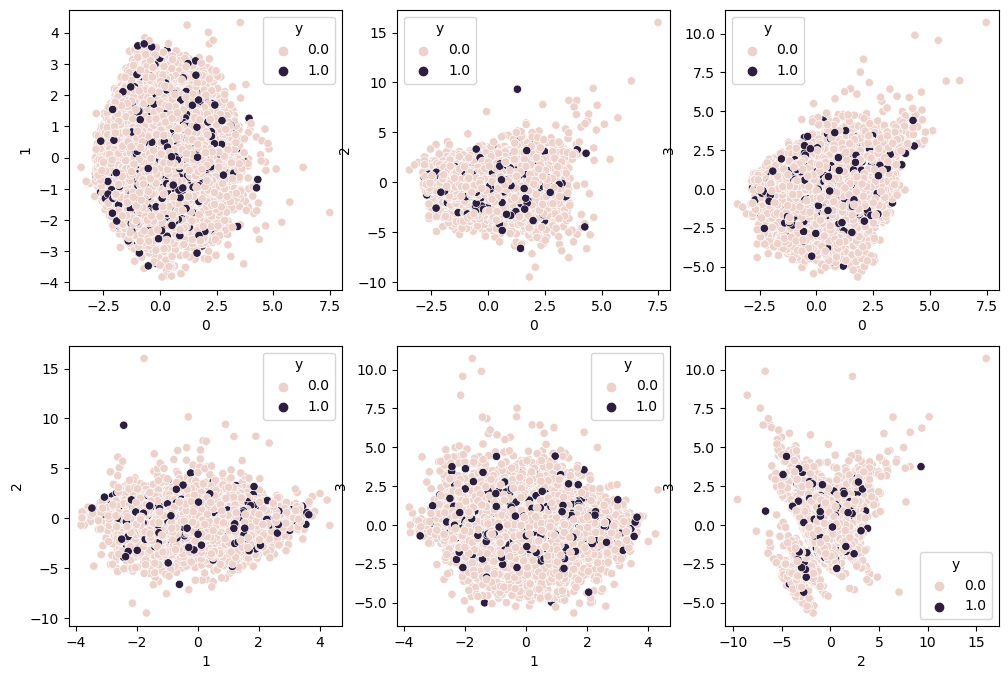

In [184]:
pca8 = PCA(n_components = 8)
pca8.fit(scaled_X_train)
transformed8 = pca8.transform(scaled_X_train)
print(scaled_X_train.shape)
print(transformed8.shape)
trans_df8 = pd.DataFrame(transformed8)
fig, axes = plt.subplots(nrows=2,ncols=3, figsize = (12, 8))
sns.scatterplot(x= trans_df8[0], y= trans_df8[1], hue = y_train, ax = axes[0,0])
sns.scatterplot(x= trans_df8[0], y= trans_df8[2], hue = y_train, ax = axes[0,1])
sns.scatterplot(x= trans_df8[0], y= trans_df8[3], hue = y_train, ax = axes[0,2])
sns.scatterplot(x= trans_df8[1], y= trans_df8[2], hue = y_train, ax = axes[1,0])
sns.scatterplot(x= trans_df8[1], y= trans_df8[3], hue = y_train, ax = axes[1,1])
sns.scatterplot(x= trans_df8[2], y= trans_df8[3], hue = y_train, ax = axes[1,2])
plt.show()

We don't see any further imporvements from 4 to 8 so I'll go ahead with 4 components

In [185]:
scores_pca = transformed4

In [186]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
silhouette_avg = []
inertia = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state = 10, init = 'k-means++')
    kmeans.fit(scores_pca)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(scores_pca, cluster_labels))
    inertia.append(kmeans.inertia_)

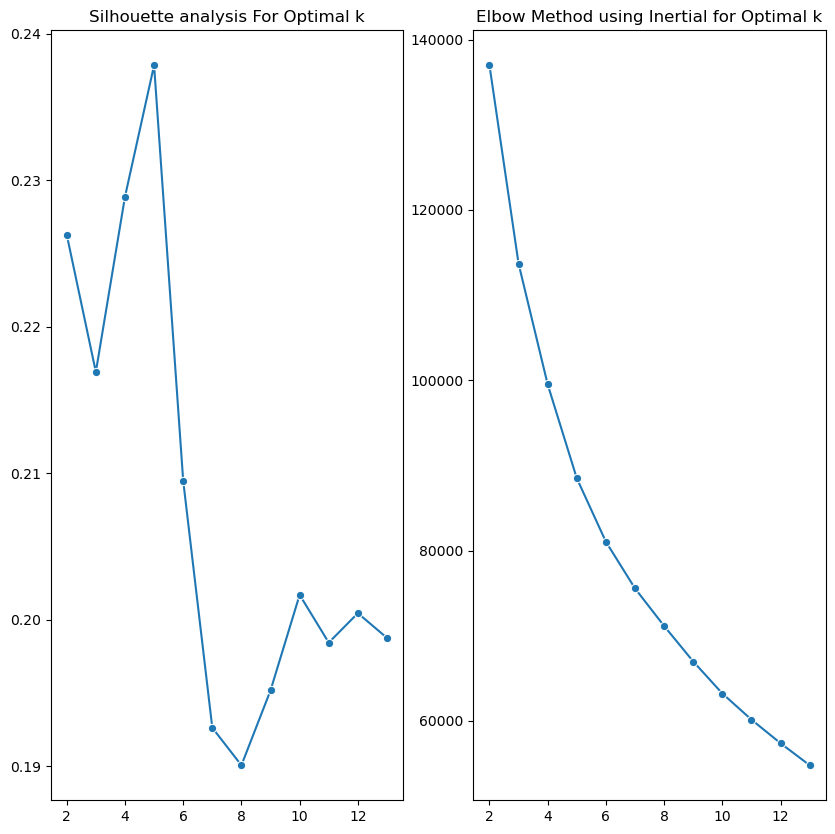

In [187]:
fig, axes = plt.subplots(1, 2, figsize=(10,10))
sns.lineplot(x=range_n_clusters,y=silhouette_avg, ax = axes[0], marker = 'o')
axes[0].set_title('Silhouette analysis For Optimal k')
sns.lineplot(x= range_n_clusters, y = inertia, ax= axes[1], marker= 'o')
axes[1].set_title('Elbow Method using Inertial for Optimal k')
plt.show();

In [188]:
kmeans_pca_4 = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans_pca_4.fit(scores_pca)

KMeans(n_clusters=4, random_state=42)

In [189]:
scaled_X_train = pd.DataFrame(scaled_X_train)
scaled_X_train.columns = X_train.columns

In [190]:
kmeans_pca4_df = pd.concat([scaled_X_train.reset_index(drop=True), pd.DataFrame(scores_pca)], axis = 1)
kmeans_pca4_df.columns.values[-4:] = ['Component 1', 'Component 2', 'Component 3', 'Component 4']
kmeans_pca4_df['Segment K-means PCA'] = kmeans_pca_4.labels_
kmeans_pca4_df['Segment'] = kmeans_pca4_df['Segment K-means PCA'].map({0:'first', 1:'second', 2: 'third', 3: 'fourth'})
kmeans_pca4_df['Segment K-means PCA'].value_counts()

0    10373
2     9184
1     8544
3     3899
Name: Segment K-means PCA, dtype: int64

In [191]:
kmeans_pca4_df.head(2)

age       job   marital  education   default   balance   housing  \
0 -0.678175  1.437132 -1.902177  -0.272884 -0.142971  0.946280  0.811986   
1 -0.574490 -1.296069  1.393509  -1.619419 -0.142971  0.376746  0.811986   

       loan   contact       day     month  duration  campaign  Component 1  \
0 -0.457173  1.414975  0.483082 -0.437060  0.251215 -0.573307    -0.426062   
1 -0.457173  1.414975  0.000532 -0.002201 -0.593977 -0.573307    -1.952110   

   Component 2  Component 3  Component 4  Segment K-means PCA Segment  
0     0.725885     0.850632     0.774374                    0   first  
1     0.456991    -0.362952     1.207262                    0   first

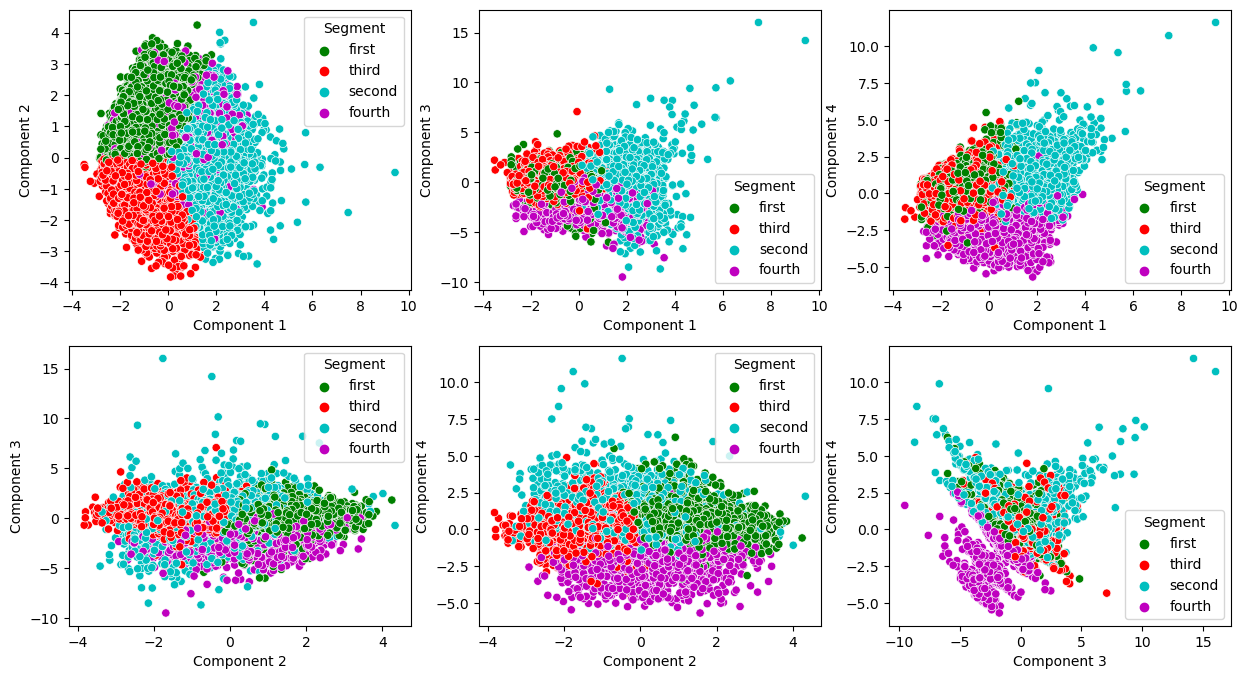

In [192]:
fig, axes = plt.subplots(nrows= 2, ncols = 3, figsize = (15,8))
sns.scatterplot(ax = axes[0,0] ,x ='Component 1', y ='Component 2', data = kmeans_pca4_df, hue = kmeans_pca4_df['Segment'], palette = ['g','r','c', 'm'])
sns.scatterplot(ax = axes[0,1] ,x ='Component 1', y ='Component 3', data = kmeans_pca4_df, hue = kmeans_pca4_df['Segment'], palette = ['g','r','c', 'm'])
sns.scatterplot(ax = axes[0,2] ,x ='Component 1', y ='Component 4', data = kmeans_pca4_df, hue = kmeans_pca4_df['Segment'], palette = ['g','r','c', 'm'])
sns.scatterplot(ax = axes[1,0] ,x ='Component 2', y ='Component 3', data = kmeans_pca4_df, hue = kmeans_pca4_df['Segment'], palette = ['g','r','c', 'm'])
sns.scatterplot(ax = axes[1,1] ,x ='Component 2', y ='Component 4', data = kmeans_pca4_df, hue = kmeans_pca4_df['Segment'], palette = ['g','r','c', 'm'])
sns.scatterplot(ax = axes[1,2] ,x ='Component 3', y ='Component 4', data = kmeans_pca4_df, hue = kmeans_pca4_df['Segment'], palette = ['g','r','c', 'm'])
plt.show();

reference: https://365datascience.com/tutorials/python-tutorials/pca-k-means/

In [193]:
features_kmeans = X_train.assign(segment = kmeans_pca_4.labels_).groupby(['segment']).mean().round()
features_kmeans

age  job  marital  education  default  balance  housing  loan  \
segment                                                                   
0        43.0  3.0      1.0        1.0      0.0    989.0      1.0   0.0   
1        45.0  5.0      1.0        1.0      0.0   2315.0      0.0   0.0   
2        33.0  5.0      2.0        1.0      0.0   1010.0      1.0   0.0   
3        41.0  4.0      1.0        1.0      0.0    331.0      0.0   1.0   

         contact   day  month  duration  campaign  
segment                                            
0            1.0  14.0    5.0     248.0       3.0  
1            0.0  19.0    8.0     223.0       4.0  
2            1.0  15.0    5.0     296.0       2.0  
3            0.0  16.0    7.0     247.0       3.0

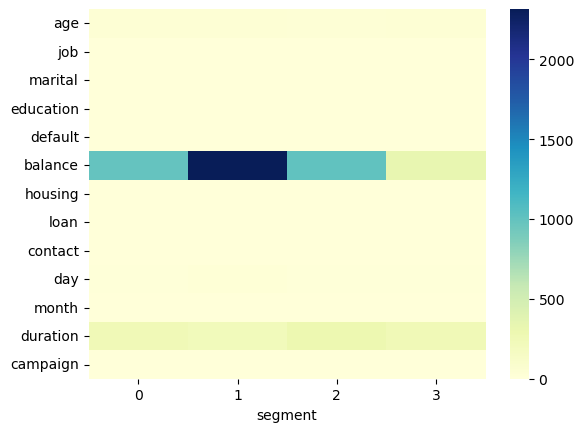

In [194]:
sns.heatmap(features_kmeans.T, cmap = 'YlGnBu')
plt.show();

Checking with 3 clusters

In [195]:
kmeans_pca_3 = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
kmeans_pca_3.fit(scores_pca)
scaled_X_train = pd.DataFrame(scaled_X_train)
scaled_X_train.columns = X_train.columns

In [196]:
kmeans_pca3_df = pd.concat([scaled_X_train.reset_index(drop=True), pd.DataFrame(scores_pca)], axis = 1)
kmeans_pca3_df.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
kmeans_pca3_df['Segment K-means PCA'] = kmeans_pca_3.labels_
kmeans_pca3_df['Segment'] = kmeans_pca3_df['Segment K-means PCA'].map({0:'first', 1:'second', 2: 'third'})
kmeans_pca3_df['Segment K-means PCA'].value_counts()

0    11640
2    10250
1    10110
Name: Segment K-means PCA, dtype: int64

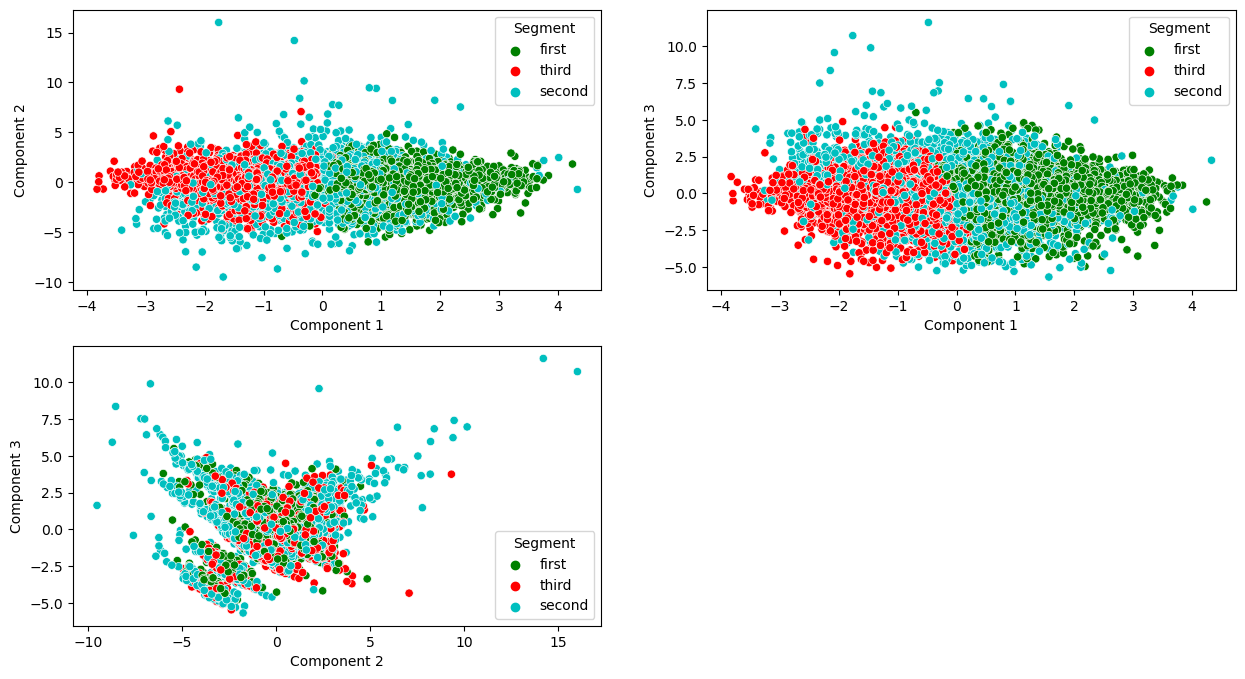

In [197]:
fig, axes = plt.subplots(nrows= 2, ncols = 2, figsize = (15,8))
sns.scatterplot(ax = axes[0,0] ,x ='Component 1', y ='Component 2', data = kmeans_pca3_df, hue = kmeans_pca3_df['Segment'], palette = ['g','r','c'])
sns.scatterplot(ax = axes[0,1] ,x ='Component 1', y ='Component 3', data = kmeans_pca3_df, hue = kmeans_pca3_df['Segment'], palette = ['g','r','c'])
sns.scatterplot(ax = axes[1,0] ,x ='Component 2', y ='Component 3', data = kmeans_pca3_df, hue = kmeans_pca3_df['Segment'], palette = ['g','r','c'])
axes[-1,-1].axis('off')
plt.show();

K Means with 5 clusters as it had the highest sihouette score

In [198]:
kmeans5 = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
kmeans5.fit(scores_pca)

KMeans(n_clusters=5, random_state=42)

In [199]:
scaled_X_train = pd.DataFrame(scaled_X_train)
scaled_X_train.columns = X_train.columns

In [200]:
kmeans_pca5_df = pd.concat([scaled_X_train.reset_index(drop=True), pd.DataFrame(scores_pca)], axis = 1)
kmeans_pca5_df.columns.values[-4:] = ['Component 1', 'Component 2', 'Component 3', 'Component 4']
kmeans_pca5_df['Segment K-means PCA'] = kmeans5.labels_
kmeans_pca5_df['Segment'] = kmeans_pca5_df['Segment K-means PCA'].map({0:'first', 1:'second', 2: 'third', 3: 'fourth', 4: 'fifth'})
kmeans_pca5_df['Segment K-means PCA'].value_counts()

1    9795
2    8715
3    7909
4    3787
0    1794
Name: Segment K-means PCA, dtype: int64

In [201]:
kmeans_pca5_df

age       job   marital  education   default   balance   housing  \
0     -0.678175  1.437132 -1.902177  -0.272884 -0.142971  0.946280  0.811986   
1     -0.574490 -1.296069  1.393509  -1.619419 -0.142971  0.376746  0.811986   
2     -0.989230 -0.385002 -0.254334  -1.619419 -0.142971 -0.424140 -1.231549   
3      1.188156 -1.296069 -0.254334  -1.619419 -0.142971  0.351079  0.811986   
4     -0.367119 -1.296069 -0.254334  -1.619419 -0.142971 -0.356156  0.811986   
...         ...       ...       ...        ...       ...       ...       ...   
31995  0.669731  1.437132 -0.254334   2.420187 -0.142971 -0.179608  0.811986   
31996 -0.678175  0.829754 -0.254334  -0.272884 -0.142971  0.023649 -1.231549   
31997 -0.470804 -0.081313  1.393509   1.073651 -0.142971  0.004919 -1.231549   
31998 -0.056064 -1.296069 -0.254334  -0.272884 -0.142971  0.093366  0.811986   
31999 -1.715025  0.829754 -0.254334  -0.272884 -0.142971  0.029545  0.811986   

           loan   contact       day     month  duration  campaign  \
0     -0.457173  1.414975  0.483082 -0.437060  0.251215 -0.573307   
1     -0.457173  1.414975  0.000532 -0.002201 -0.593977 -0.573307   
2     -0.457173  1.414975 -1.447121  0.432657 -0.497494  0.345546   
3      2.187356  0.330079 -1.447121 -1.741634 -0.667304 -0.573307   
4     -0.457173  1.414975 -0.964570 -0.437060 -0.362418  1.570685   
...         ...       ...       ...       ...       ...       ...   
31995 -0.457173 -0.754816  0.965633  0.432657 -0.601696 -0.573307   
31996 -0.457173 -0.754816  1.689459 -0.871918  0.722052 -0.573307   
31997 -0.457173 -0.754816  0.241807  0.867515 -0.628711  0.651831   
31998 -0.457173  1.414975  1.689459 -0.437060  0.521368 -0.267023   
31999  2.187356 -0.754816  0.241807 -0.437060 -0.061390 -0.267023   

       Component 1  Component 2  Component 3  Component 4  \
0        -0.426062     0.725885     0.850632     0.774374   
1        -1.952110     0.456991    -0.362952     1.207262   
2        -0.697983     0.841184    -0.179916     0.218410   
3        -1.719242     2.532470    -0.217021    -0.892092   
4        -1.644853     1.518025    -1.008797     1.419126   
...            ...          ...          ...          ...   
31995     1.264464    -1.246430     0.602325     0.060922   
31996     0.590484    -0.880355     0.233962    -0.135778   
31997     1.169680    -1.895882    -0.250358     0.355269   
31998    -0.979518     0.846663    -0.476643     1.415852   
31999    -0.720053    -0.848713    -1.014575    -1.153320   

       Segment K-means PCA Segment  
0                        1  second  
1                        1  second  
2                        1  second  
3                        1  second  
4                        1  second  
...                    ...     ...  
31995                    3  fourth  
31996                    3  fourth  
31997                    2   third  
31998                    1  second  
31999                    4   fifth  

[32000 rows x 19 columns]

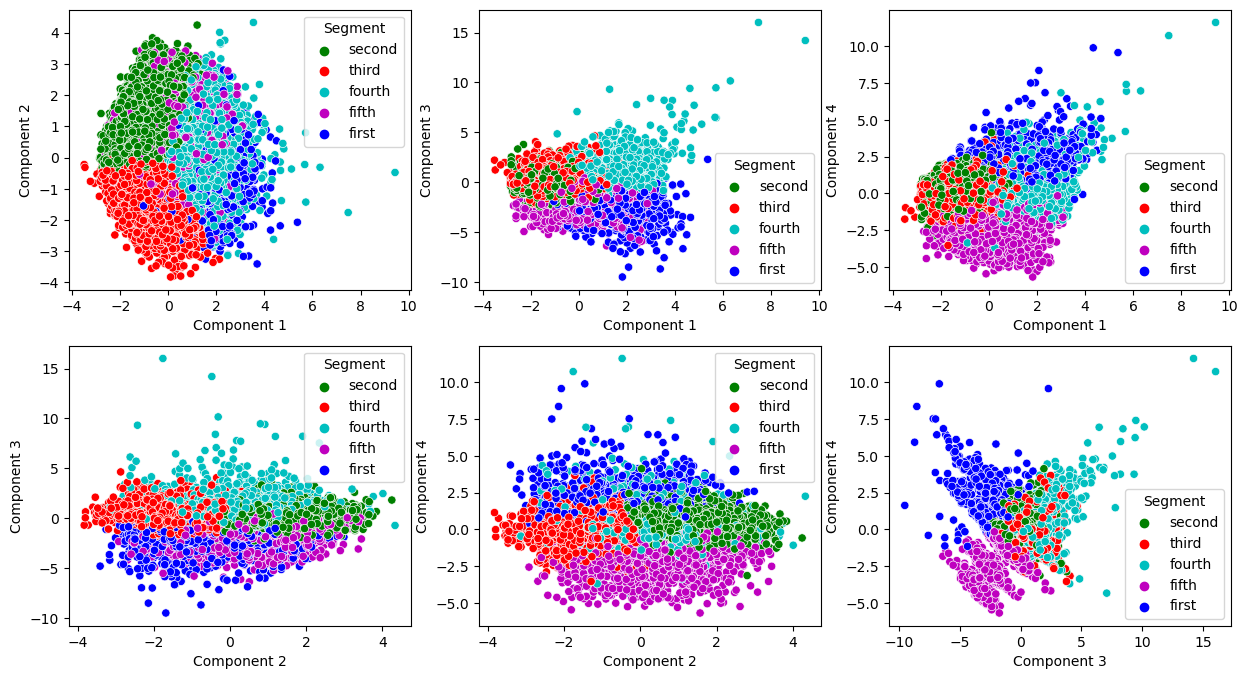

In [202]:
fig, axes = plt.subplots(nrows= 2, ncols = 3, figsize = (15,8))
sns.scatterplot(ax = axes[0,0] ,x ='Component 1', y ='Component 2', data = kmeans_pca5_df, hue = kmeans_pca5_df['Segment'], palette = ['g','r','c', 'm', 'b'])
sns.scatterplot(ax = axes[0,1] ,x ='Component 1', y ='Component 3', data = kmeans_pca5_df, hue = kmeans_pca5_df['Segment'], palette = ['g','r','c', 'm', 'b'])
sns.scatterplot(ax = axes[0,2] ,x ='Component 1', y ='Component 4', data = kmeans_pca5_df, hue = kmeans_pca5_df['Segment'], palette = ['g','r','c', 'm', 'b'])
sns.scatterplot(ax = axes[1,0] ,x ='Component 2', y ='Component 3', data = kmeans_pca5_df, hue = kmeans_pca5_df['Segment'], palette = ['g','r','c', 'm', 'b'])
sns.scatterplot(ax = axes[1,1] ,x ='Component 2', y ='Component 4', data = kmeans_pca5_df, hue = kmeans_pca5_df['Segment'], palette = ['g','r','c', 'm', 'b'])
sns.scatterplot(ax = axes[1,2] ,x ='Component 3', y ='Component 4', data = kmeans_pca5_df, hue = kmeans_pca5_df['Segment'], palette = ['g','r','c', 'm', 'b'])
plt.show();

# Conclusion
The best performing model here is a Random Forest Classifier which yield an accuracy score 92% after SMOTE analysis was conducted to account for the imbalance in the dataset. It is important to note that whilst the success metrics outlined in aims of the project is accuracy, the weighted f1 score was prioritised due to the imbalance in the dataset. For this model, the weighted f1 score is 92% as well. 
The Random Forest Classifier, along side other classification algorigthms highlighted the month of last contact, the duration of the last contact, the means of last contact, and the balance as important features in the dataset for the classifcation. This was in line with the results of KMeans clustering with PCA. 3 to 4 clusters look visible. To gain a better idea of the problem, it's worth looking into how many clients signed up for subscriptions who then tried to withdraw their deposits before the maturity time. This alongisde the duration of the contacts can help gain a better understanding of the relationship duration and subscription. Otherwise, it does look like the longer a customer is spoken with the higher the chance of them subscribing for term deposits. October and March have the highest subscription rates and therefore is worth driving more attention to these two months through telephone/cellphone contact. 


pick two or three and do 2D plots; 